## Adapted from Jupyter notebook 7_latent_space_visualization.ipynb

In [1]:
# Automatically reload modules before code execution
%load_ext autoreload
%autoreload 2

In [2]:
# Set plotting style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import os
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt

import tifffile

from integrated_cell.utils.plots import tensor2im, imshow
import integrated_cell
from integrated_cell import model_utils, utils

In [5]:
pd.options.display.max_rows = 200

In [88]:
def imshow_subplot(im, argAx, scale_channels=True, scale_global=True, color_transform=None):
    # assume CYX image
    im = tensor2im(im, scale_channels, scale_global)
    argAx.imshow(im)
    argAx.axis("off")

In [6]:
gpu_ids = [7]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()

image_parent = '/allen/aics/modeling/gregj/results/ipp/scp_19_04_10/'

#load the reference model
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
#parent_dir = '/allen/aics/modeling/caleb/results/integrated_cell/'

ref_model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04'
ref_suffix = '_94544'    
#ref_model_dir = '/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/examples/training_scripts/bvae3D_actk_ref_seg_mito_beta_1_2021-02-02'

networks, dp_ref, args_ref = utils.load_network_from_dir(ref_model_dir, parent_dir, suffix=ref_suffix)

ref_enc = networks['enc']
ref_dec = networks['dec']

#load the target model
target_model_dir = "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/"
target_suffix = '_93300'

networks, dp_target, args_target = utils.load_network_from_dir(target_model_dir, parent_dir, suffix=target_suffix)
    
target_enc = networks['enc']
target_dec = networks['dec']


results_dir = '{}/results/latent_space_vizualization/'.format(parent_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
print("Results dir: {}".format(results_dir))

save_dir = results_dir

recon_loss = utils.load_losses(args_target)['crit_recon']

args file exists and overwrite is not set to True. Using existing args file.
args file exists and overwrite is not set to True. Using existing args file.


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/enc_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/dec_94544.pth


args file exists and overwrite is not set to True. Using existing args file.


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/enc_93300.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/dec_93300.pth
Results dir: /allen/aics/modeling/gregj/results/integrated_cell//results/latent_space_vizualization/


## Get metadata for all splits

In [7]:
# Add column ControlMask to indicate whether the dataframe row contains a control cell
dfControlMask = dp_ref.csv_data['save_reg_path'].str.contains('control')
dfControlMask.name = 'ControlMask'

dp_ref.csv_data = pd.concat([dp_ref.csv_data,dfControlMask], axis=1)

In [8]:
dfs_split = {
    split: pd.concat(
        [
            dp_ref.csv_data.loc[
                dp_ref.data[split]["inds"],
                ["CellId", "PlateId", "CellIndex", 'Gene', 'Protein', 'ProteinDisplayName', 'Structure', 'StructureDisplayName', 'StructureShortName', 'ProteinId/Name', 'StructureId/Name', 'save_reg_path', 'ControlMask']  # CC: Add column for image path here?
            ].reset_index(
            ).rename(
                columns={"index":"UnsplitCsvIndex"}
            ),
            pd.DataFrame({"split":[split]*len(dp_ref.data[split]["inds"])})
        ],
        axis=1
    ) for split in dp_ref.data.keys()
}

## Get features for all splits

In [9]:
import json

with open('/raid/shared/ipp/scp_19_04_10/feats_out_with_units.json') as f:
    feats = json.load(f)

df_feats_all = pd.DataFrame.from_dict(feats["rows_with_units"])
my_feats = ["CellId", "dna_volume", "cell_volume"]
df_feats = df_feats_all[my_feats].copy()

df_feats["cell_height"] = df_feats_all["cell_position_highest_z"] - df_feats_all["cell_position_lowest_z"]
df_feats["dna_height"] = df_feats_all["dna_position_highest_z"] - df_feats_all["dna_position_lowest_z"]

## Get mito annotations for each split

In [10]:
dfs_mito_all = {
    split: pd.DataFrame(
        {
            feat:dp_ref.data[split][feat] for feat in ["inds", "CellId", "mito_state_resolved"]
        }
    ).rename(
        columns={"inds":"UnsplitCsvIndex"}
    ) for split in dp_ref.data.keys()
}

## Find the embeddings for each split

In [11]:
ref_embeds_test_path = '/allen/aics/modeling/caleb/data/7_latent_space_visualization_ref_embeds_test.pth'

if (os.path.exists(ref_embeds_test_path)):
    embeds_test = torch.load(ref_embeds_test_path)
    
else:
    from integrated_cell.metrics.embeddings_reference import get_latent_embeddings

    embeds_test = get_latent_embeddings(
        ref_enc,
        ref_dec,
        dp_ref,
        recon_loss,
        modes=['test', 'validate', 'train'],
        batch_size=32,
    )
    
    torch.save(embeds_test, ref_embeds_test_path)

In [12]:
dfs_embeds = {
    split: pd.DataFrame(
        embeds_test[split]["ref"]["mu"].numpy(),
        columns=[f"mu_{i}" for i in range(embeds_test[split]["ref"]["mu"].numpy().shape[1])]
    ) for split in embeds_test.keys()
}

In [13]:
for split, df_embed in dfs_embeds.items():
    assert len(dfs_embeds[split]) == len(dfs_split[split])
    dfs_embeds[split]["UnsplitCsvIndex"] = dfs_split[split]["UnsplitCsvIndex"]

In [14]:
print(f"CellIds (dp_ref) = {len(dp_ref.csv_data['CellId'])}")
print(f"Unique CellIds (dp_ref) = {len(dp_ref.csv_data['CellId'].unique())}")
print(f'Non-control cells (dp_ref) = {np.sum(~dfControlMask)}')
print(f"CellIds (df_feats_all) = {len(df_feats_all['CellId'])}")
print(f"Unique CellIds (df_feats_all) = {len(df_feats_all['CellId'].unique())}")

CellIds (dp_ref) = 49340
Unique CellIds (dp_ref) = 39200
Non-control cells (dp_ref) = 39200
CellIds (df_feats_all) = 39190
Unique CellIds (df_feats_all) = 39190


## Merge embeddings in to metadata

In [15]:
# This is for training set only
df_embeddings_plus_meta_train = dfs_split["train"].merge(
    dfs_mito_all["train"]
).merge(
    dfs_embeds['train']
)

In [16]:
# This is for training set only
df_embeddings_plus_meta_and_feats_train = dfs_split["train"].merge(
    dfs_mito_all["train"]
).merge(
    dfs_embeds['train']
).merge(
    df_feats, how='left'  # Some cells don't have features, but we still want to include those rows
)

In [17]:
df_embeddings_plus_meta_train_pretty_names = df_embeddings_plus_meta_and_feats_train.rename(
    columns={
        "mito_state_resolved": "Mitotic state",
        'dna_volume': 'DNA volume',
        'cell_volume': 'Cell volume',
        'dna_height': 'DNA height',
        'cell_height': 'Cell height'
    }
)

In [18]:
df_embeddings_plus_meta_train_pretty_names[
    df_embeddings_plus_meta_train_pretty_names["Mitotic state"] != 'u'
].sort_values(by="Mitotic state")

,UnsplitCsvIndex,CellId,PlateId,CellIndex,Gene,Protein,ProteinDisplayName,Structure,StructureDisplayName,StructureShortName,...,mu_506,mu_507,mu_508,mu_509,mu_510,mu_511,DNA volume,Cell volume,Cell height,DNA height
0,0,3,3500001454,3,LAMP1,LAMP-1,LAMP-1,Lysosome,Lysosome,Lysosome,...,0.045677,0.064711,0.057460,0.080174,-0.236040,-0.059527,876.345548,2732.007002,33.0,25.0
25992,32314,147380,3500002422,5,SLC25A17,Peroxisomal membrane protein PMP34,Peroxisomal membrane protein PMP34,Peroxisomes,Peroxisomes,Peroxisomes,...,0.004591,-0.010587,-0.021720,-0.023392,1.119753,-0.002641,486.438605,1501.264895,26.0,20.0
25993,32315,147383,3500002422,8,SLC25A17,Peroxisomal membrane protein PMP34,Peroxisomal membrane protein PMP34,Peroxisomes,Peroxisomes,Peroxisomes,...,0.000594,0.049926,0.081525,-0.030399,-1.309823,-0.005038,823.714086,2295.541458,35.0,29.0
25994,32317,147438,3500002422,13,SLC25A17,Peroxisomal membrane protein PMP34,Peroxisomal membrane protein PMP34,Peroxisomes,Peroxisomes,Peroxisomes,...,0.019928,-0.010989,0.024632,-0.022789,0.732092,-0.011767,515.681016,1611.430008,35.0,22.0
25995,32318,147470,3500002422,6,SLC25A17,Peroxisomal membrane protein PMP34,Peroxisomal membrane protein PMP34,Peroxisomes,Peroxisomes,Peroxisomes,...,-0.011352,-0.015828,0.024949,0.014054,0.629455,0.002679,575.702345,1771.373070,36.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15139,18810,56117,3500001543,1,FBL,Fibrillarin,Fibrillarin,Nucleolus (Dense Fibrillar Component),Nucleolus (Dense Fibrillar Component),Nucleolus (Dense Fibrillar Component),...,-0.055091,0.011493,-0.070376,-0.048534,-0.893528,-0.143330,162.430740,1582.553432,37.0,31.0
15154,18826,56213,3500001543,9,FBL,Fibrillarin,Fibrillarin,Nucleolus (Dense Fibrillar Component),Nucleolus (Dense Fibrillar Component),Nucleolus (Dense Fibrillar Component),...,-0.013873,-0.010289,-0.040038,-0.073076,-0.480515,-0.038311,200.648303,1827.248269,41.0,29.0
15162,18835,56265,3500001543,14,FBL,Fibrillarin,Fibrillarin,Nucleolus (Dense Fibrillar Component),Nucleolus (Dense Fibrillar Component),Nucleolus (Dense Fibrillar Component),...,0.018068,-0.039136,0.028428,0.030110,0.429004,-0.104128,196.770452,1311.737976,40.0,26.0
15178,18852,56365,3500001543,3,FBL,Fibrillarin,Fibrillarin,Nucleolus (Dense Fibrillar Component),Nucleolus (Dense Fibrillar Component),Nucleolus (Dense Fibrillar Component),...,0.026951,-0.071049,-0.102280,-0.018310,-1.531295,-0.076020,183.600392,1314.176876,37.0,26.0


## Filter by mitotic state and structure (leaving out control cells)

In [19]:
print(f"Mitotic states = {df_embeddings_plus_meta_train_pretty_names['Mitotic state'].unique()}")
print(f"Structures = {df_embeddings_plus_meta_train_pretty_names['Structure'].unique()}")

Mitotic states = ['M0' 'M6/M7' 'M4/M5' 'M3' 'M1/M2' 'u']
Structures = ['Lysosome' 'Mitochondria' 'Microtubules' 'Actin filaments'
 'Adherens junctions' 'Centrosome' 'Gap junctions' 'Desmosomes'
 'Nucleolus (Dense Fibrillar Component)' 'Nuclear envelope'
 'Endoplasmic reticulum' 'Golgi' 'Tight junctions' 'Plasma membrane'
 'Matrix adhesions' 'Peroxisomes' 'Endosomes' 'Actomyosin bundles'
 'Nucleolus (Granular Component)']


In [282]:
mitotic_state = 'M0'
#mitotic_state = 'M6/M7'
#structure = 'Actin filaments'
structure = 'Microtubules'
#structure = 'Golgi'

df_train_filtered = df_embeddings_plus_meta_train_pretty_names.query("`Mitotic state` == @mitotic_state & Structure == @structure")
df_train_filtered_nocontrols = df_train_filtered[df_train_filtered['ControlMask'] == False]

df_train_filtered_nocontrols[['UnsplitCsvIndex', 'CellId', 'Mitotic state', 'Structure', 'save_reg_path']]

,UnsplitCsvIndex,CellId,Mitotic state,Structure,save_reg_path
4262,5304,22225,M0,Microtubules,plate_3500000722/503_22225_reg.tiff
4263,5305,22226,M0,Microtubules,plate_3500000722/503_22226_reg.tiff
4264,5306,22227,M0,Microtubules,plate_3500000722/514_22227_reg.tiff
4265,5307,22228,M0,Microtubules,plate_3500000722/514_22228_reg.tiff
4266,5308,22229,M0,Microtubules,plate_3500000722/514_22229_reg.tiff
...,...,...,...,...,...
6197,7704,149847,M0,Microtubules,plate_3500000766/1053_149847_reg.tiff
6198,7705,149848,M0,Microtubules,plate_3500000766/1053_149848_reg.tiff
6200,7707,149850,M0,Microtubules,plate_3500000766/1057_149850_reg.tiff
6201,7708,149851,M0,Microtubules,plate_3500000766/1057_149851_reg.tiff


## Visualize cell images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_parent = /raid/shared/ipp/scp_19_04_10/, /raid/shared/ipp/scp_19_04_10/
4297: plate_3500000722/430_69871_reg.tiff


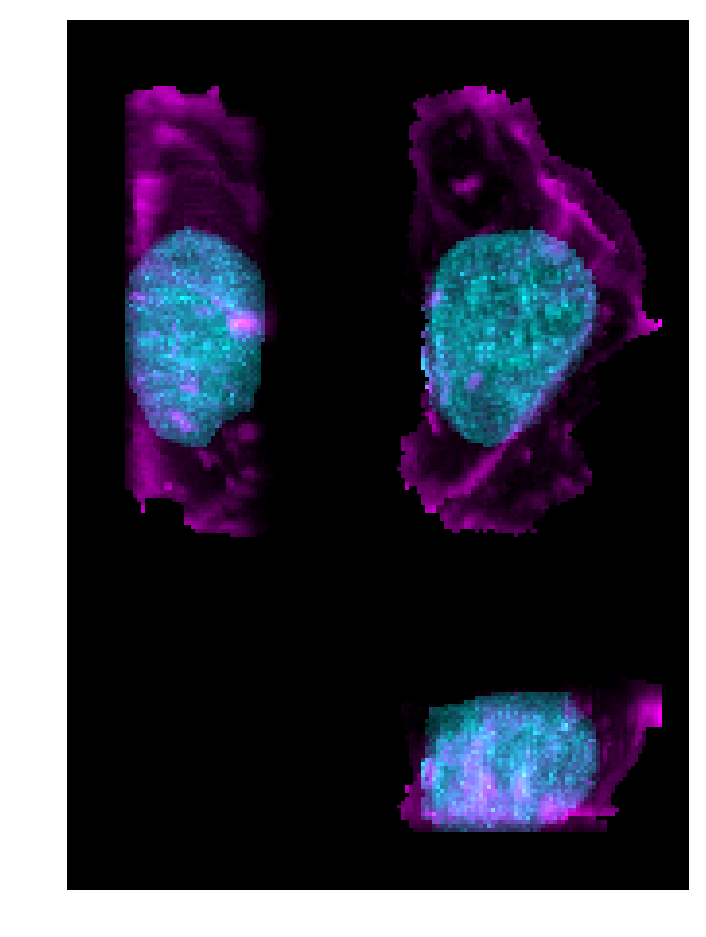

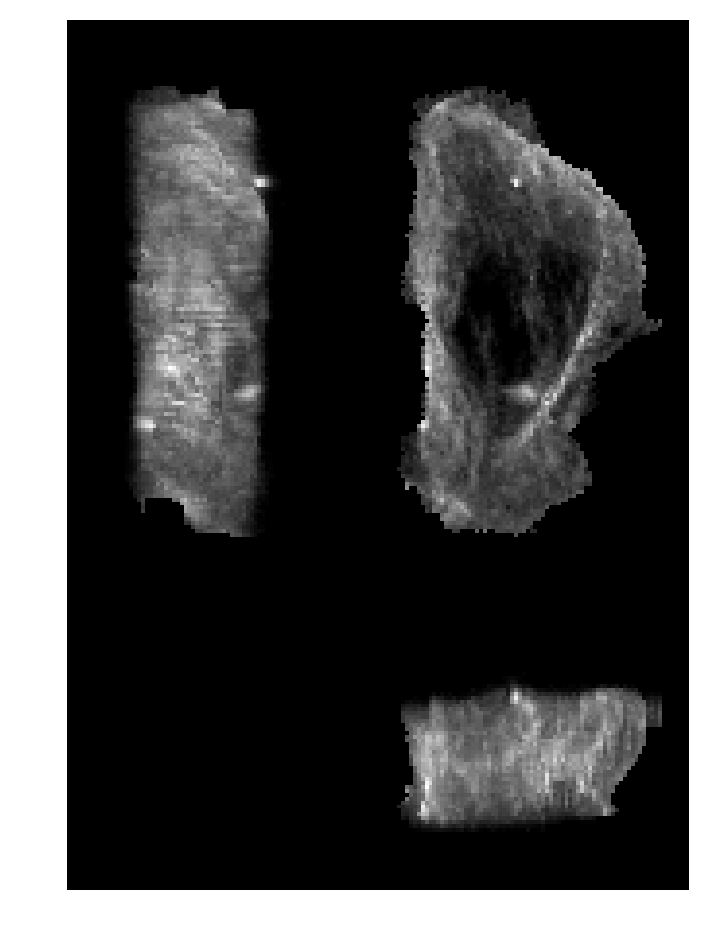

<Figure size 432x288 with 0 Axes>

In [288]:
print(f'image_parent = {dp_ref.image_parent}, {dp_target.image_parent}')

#ind = df_train_filtered_nocontrols.index[5]
ind = 4297

ref_x = dp_ref.get_sample('train', [ind])
target_x = dp_target.get_sample('train', [ind])

#print(f"{df_train_filtered_nocontrols.loc[ind][['UnsplitCsvIndex', 'CellId', 'CellIndex', 'Mitotic state', 'Gene', 'Protein', 'ProteinDisplayName', 'Structure', 'StructureDisplayName', 'StructureShortName', 'ProteinId/Name', 'StructureId/Name', 'save_reg_path', 'ControlMask']]}")
print(f"{ind}: {df_train_filtered_nocontrols.loc[ind]['save_reg_path']}")

#print(f'ref_x.shape = {ref_x.shape}')
#print(f'target_x.shape = {target_x.shape}')

plt.figure(figsize=(6, 8))
imshow(ref_x, scale_channels=True, scale_global=False)
plt.figure(figsize=(6, 8))
imshow(target_x[0], scale_channels=True, scale_global=False)

plt.tight_layout()

In [284]:
iterIdx = iter(df_train_filtered_nocontrols.index)
print(f'{len(df_train_filtered_nocontrols.index)}')

1784


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_parent = /raid/shared/ipp/scp_19_04_10/, /raid/shared/ipp/scp_19_04_10/
0 (4286): plate_3500000722/534_69858_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 (4288): plate_3500000722/534_69860_reg.tiff
2 (4289): plate_3500000722/432_69861_reg.tiff
3 (4290): plate_3500000722/444_69862_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 (4291): plate_3500000722/444_69863_reg.tiff
5 (4294): plate_3500000722/531_69866_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 (4295): plate_3500000722/531_69867_reg.tiff
7 (4297): plate_3500000722/430_69871_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 (4298): plate_3500000722/430_69872_reg.tiff
9 (4299): plate_3500000722/475_69873_reg.tiff


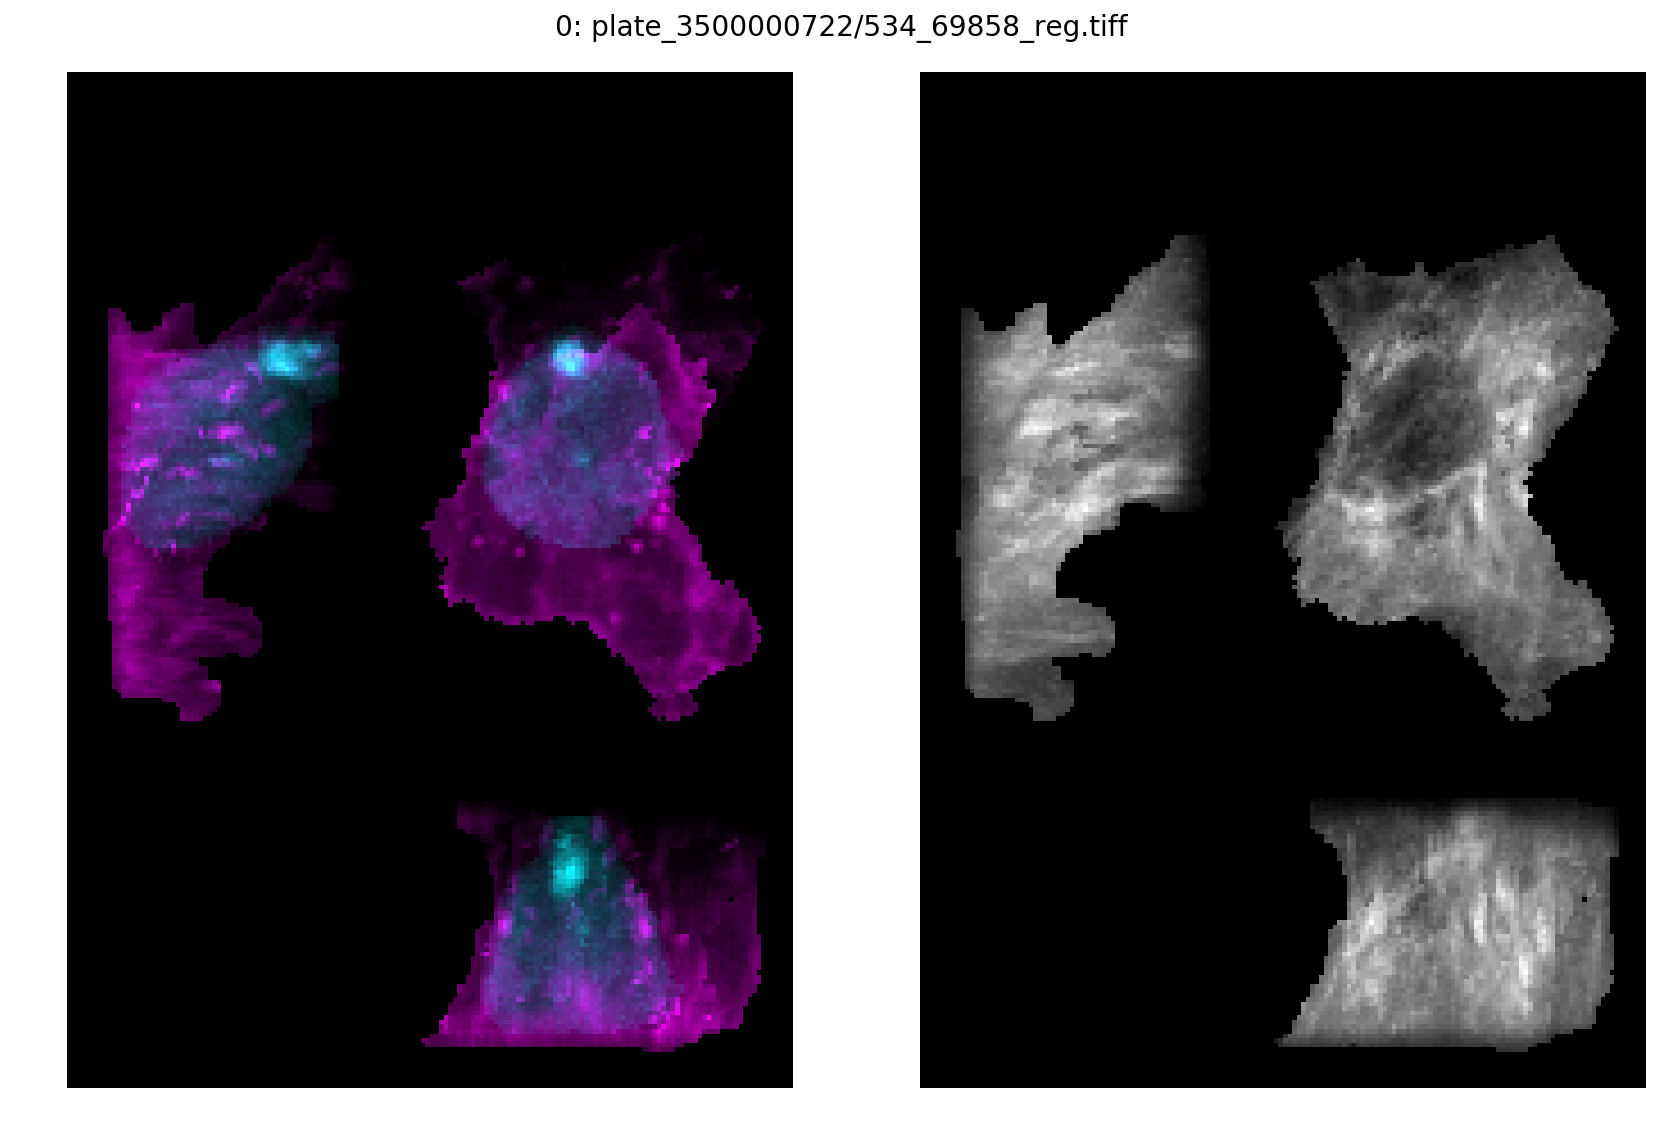

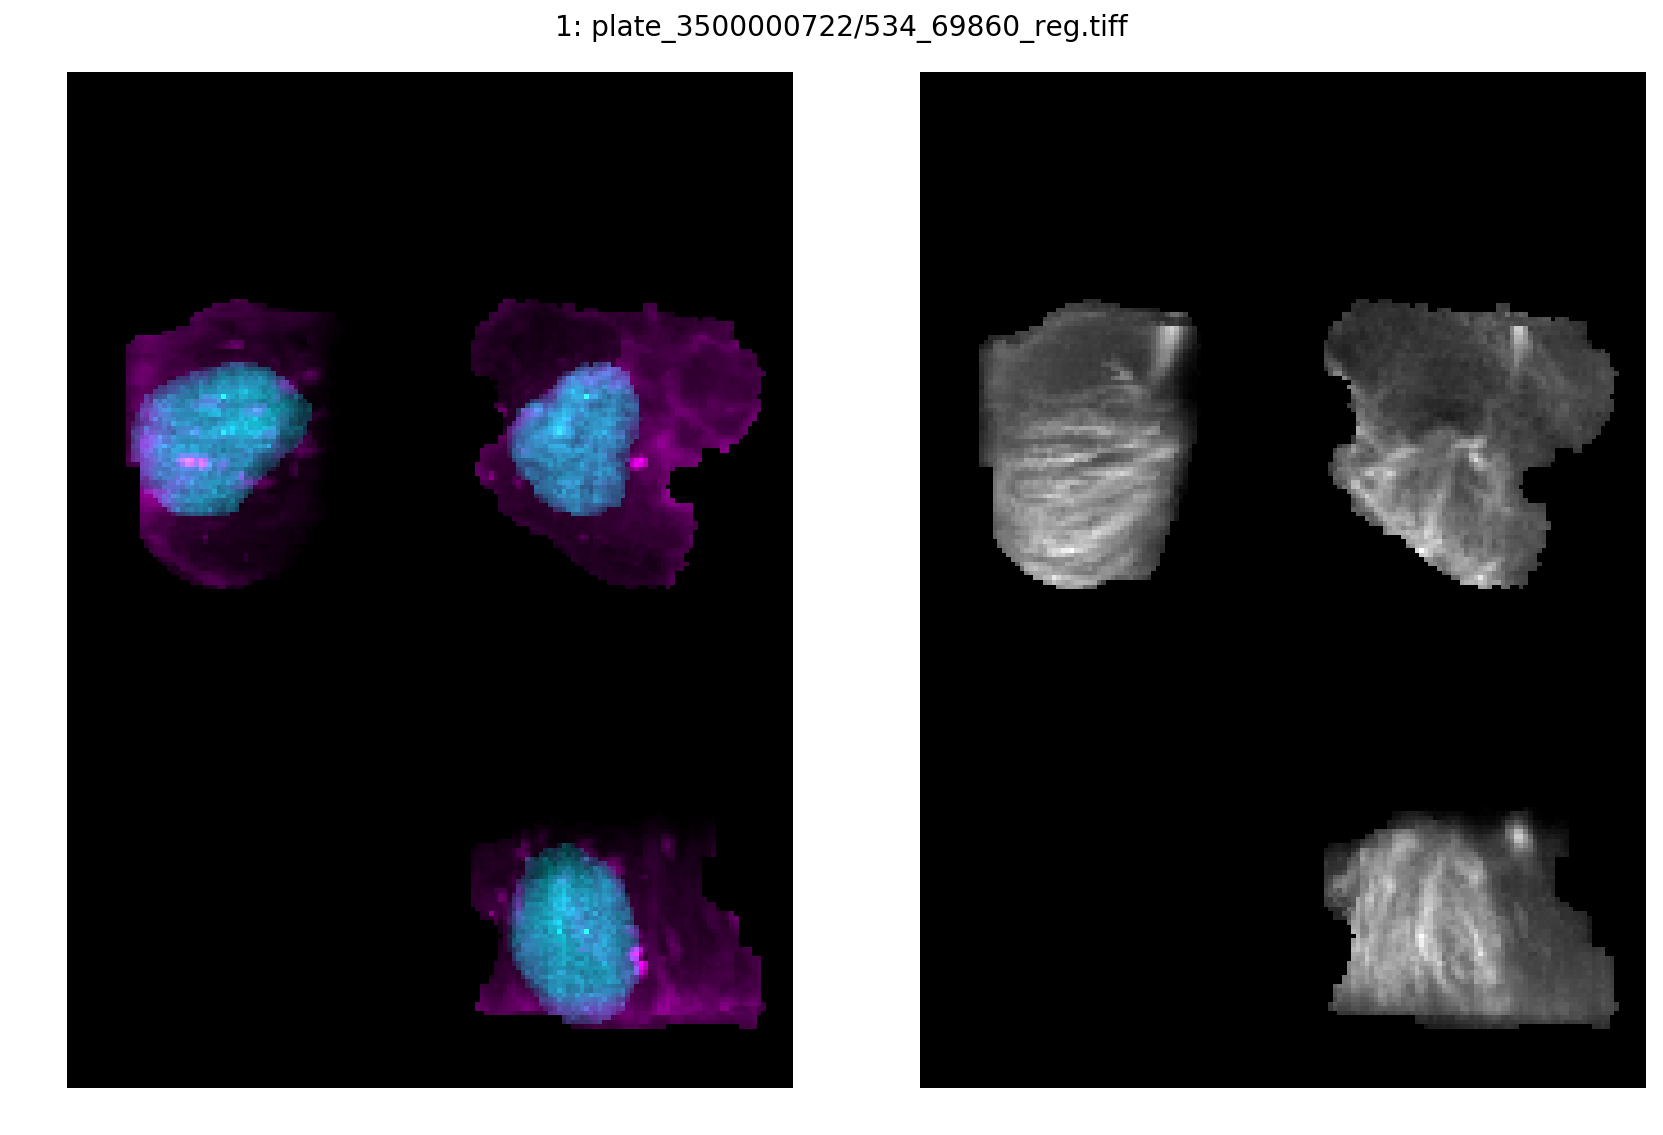

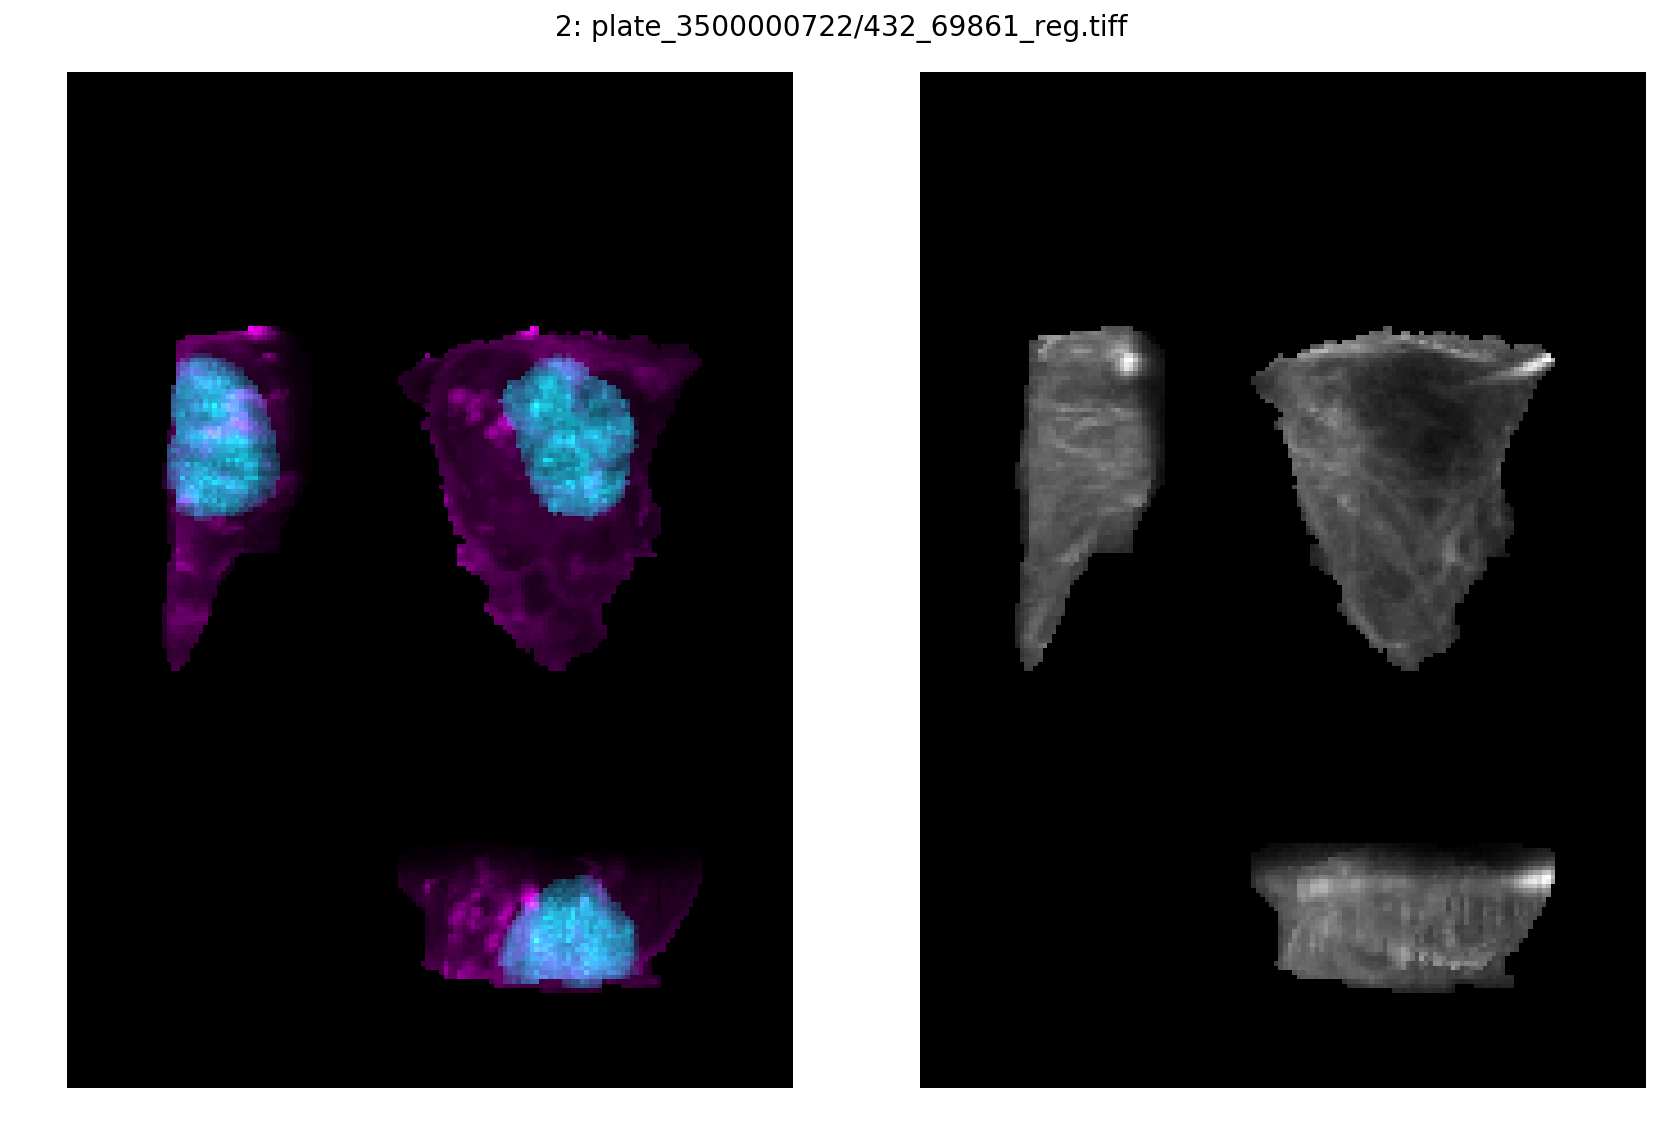

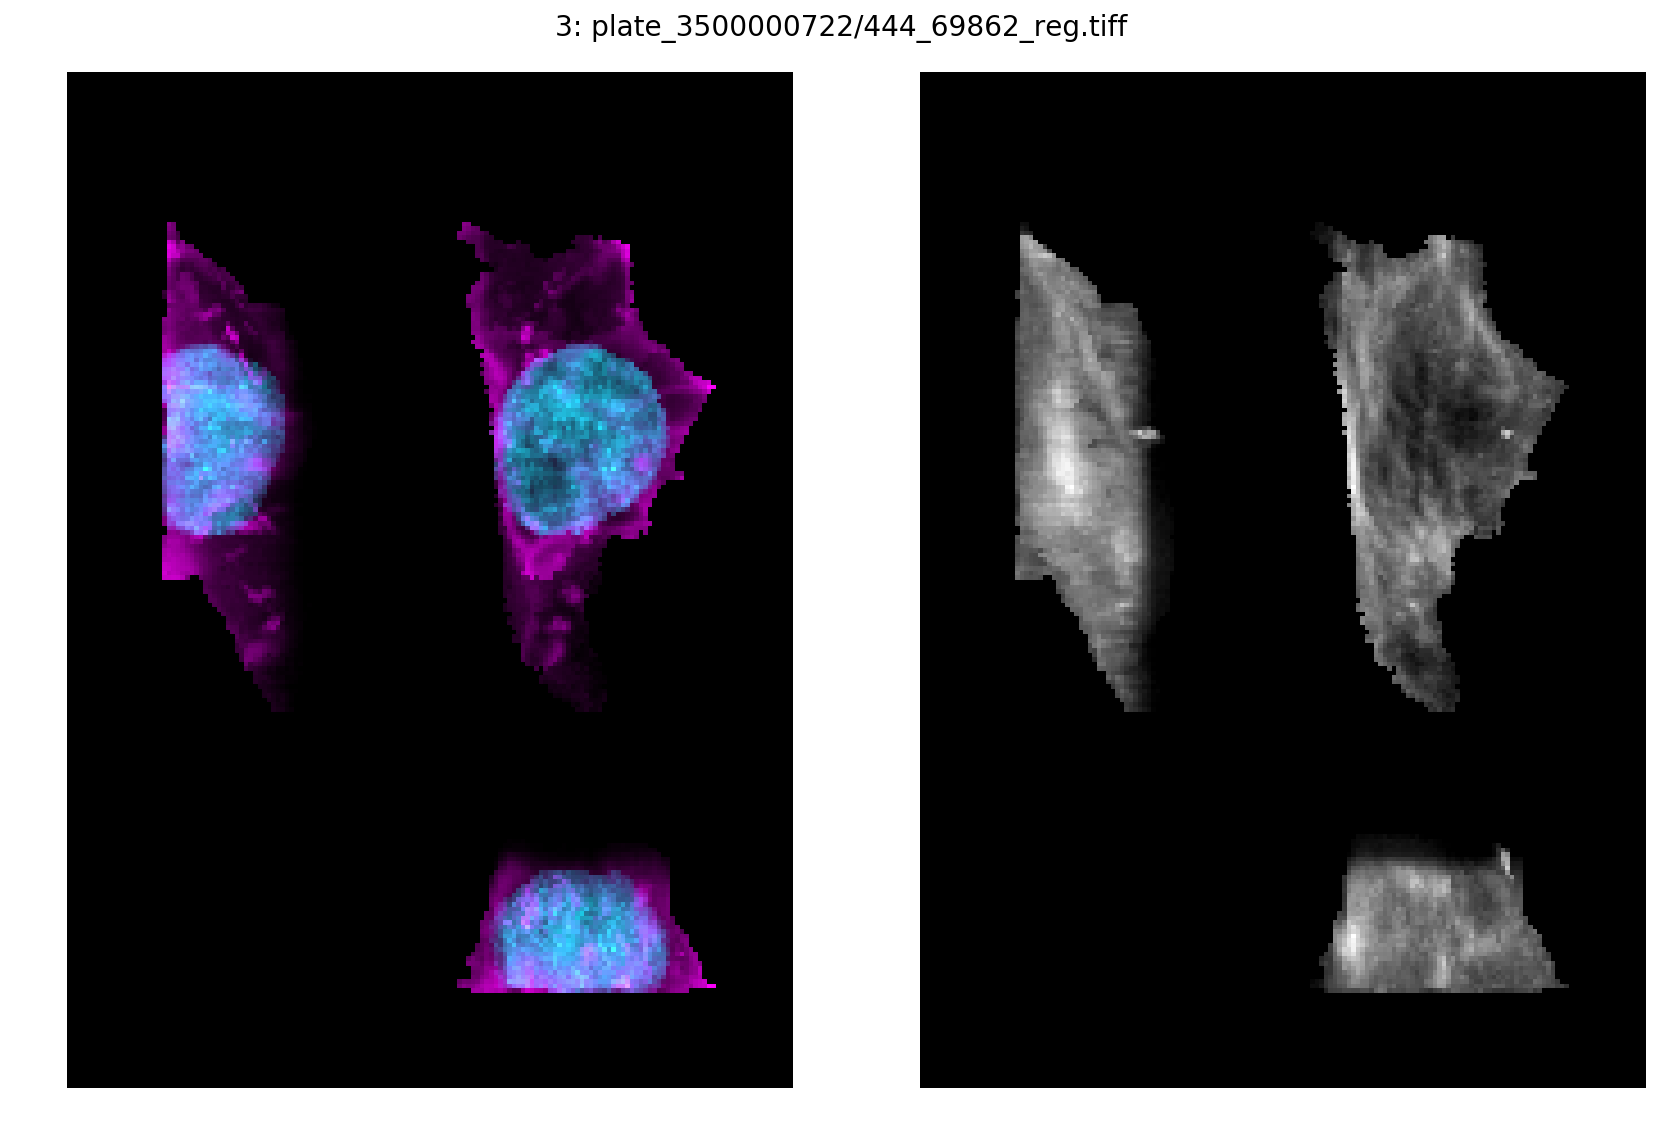

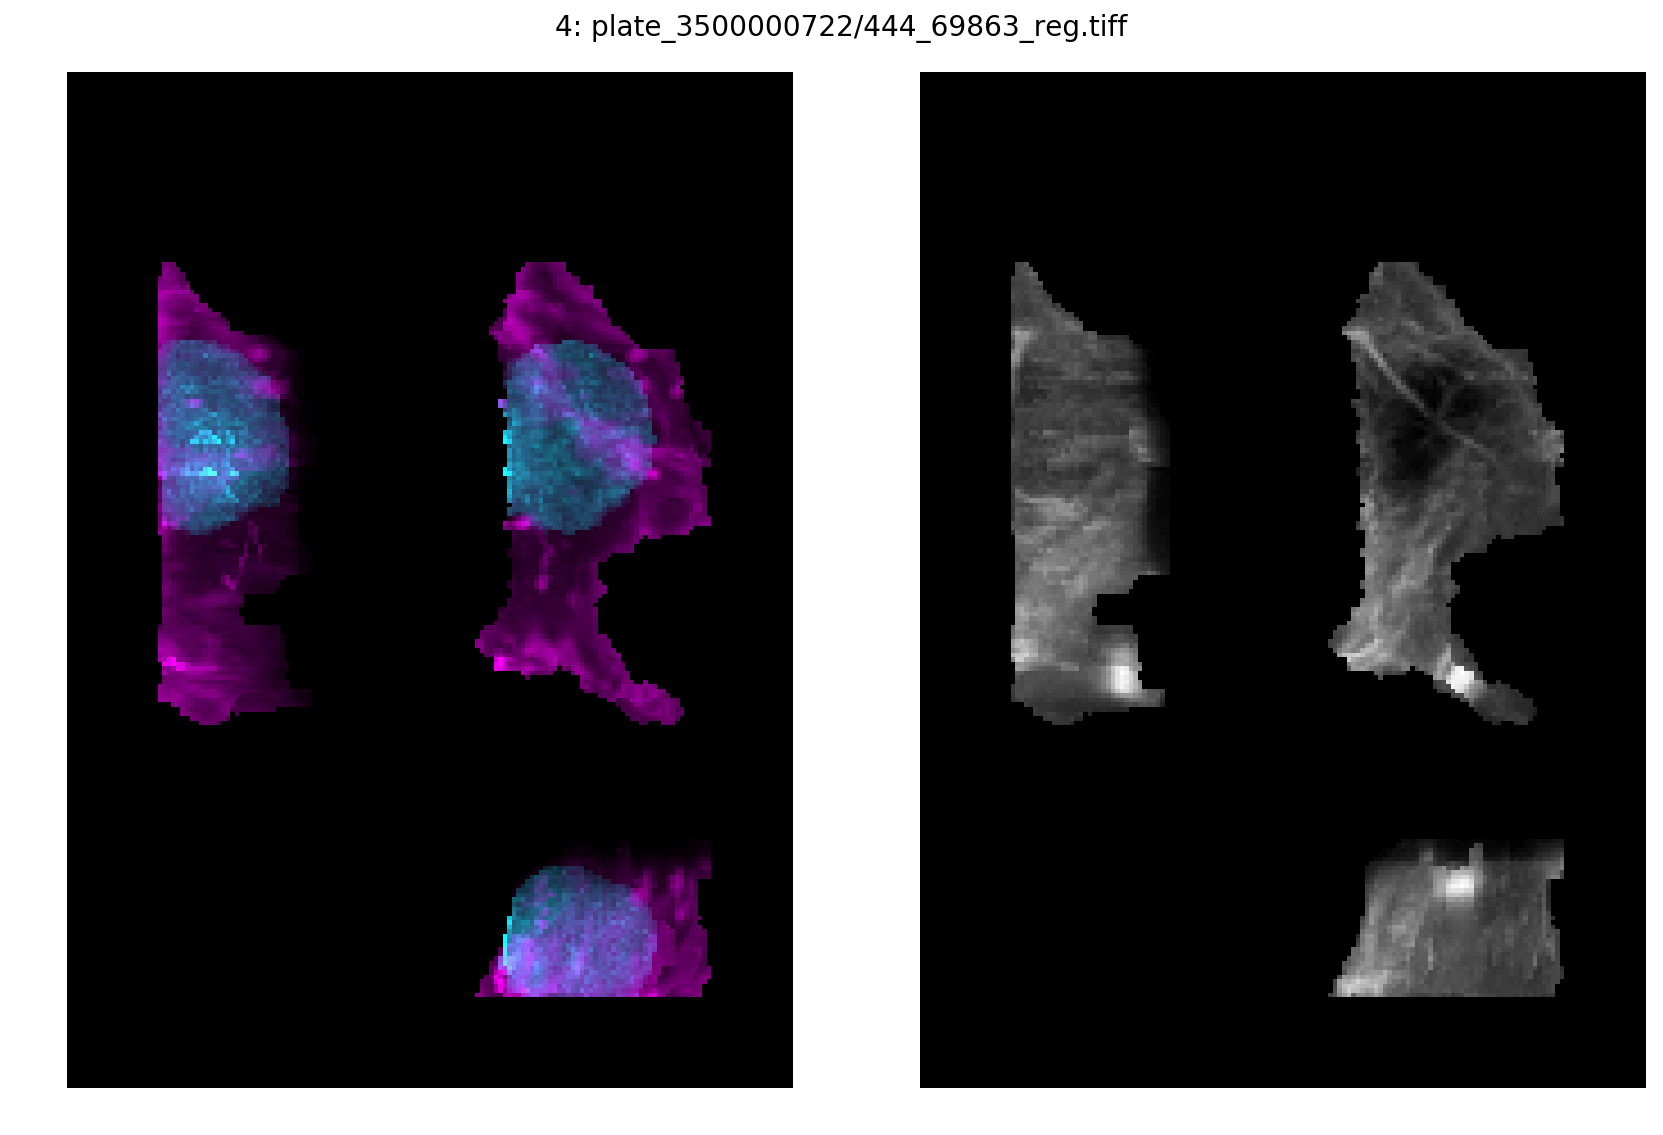

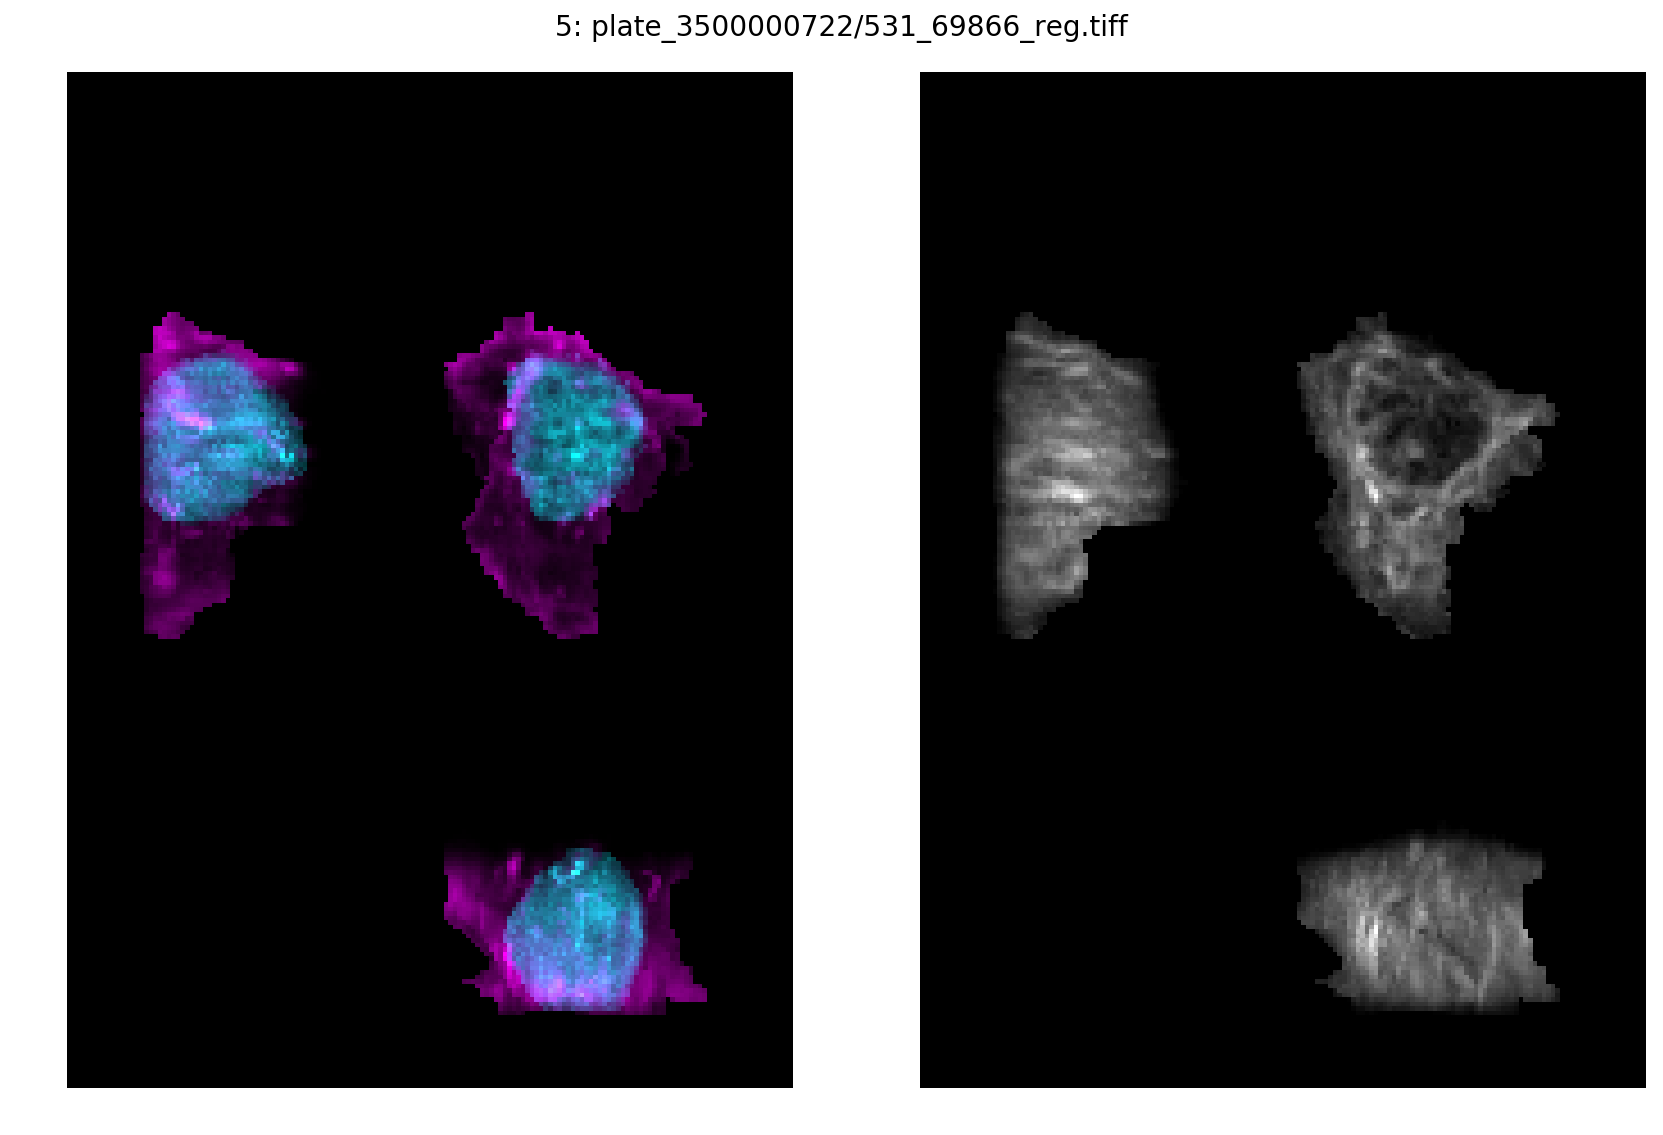

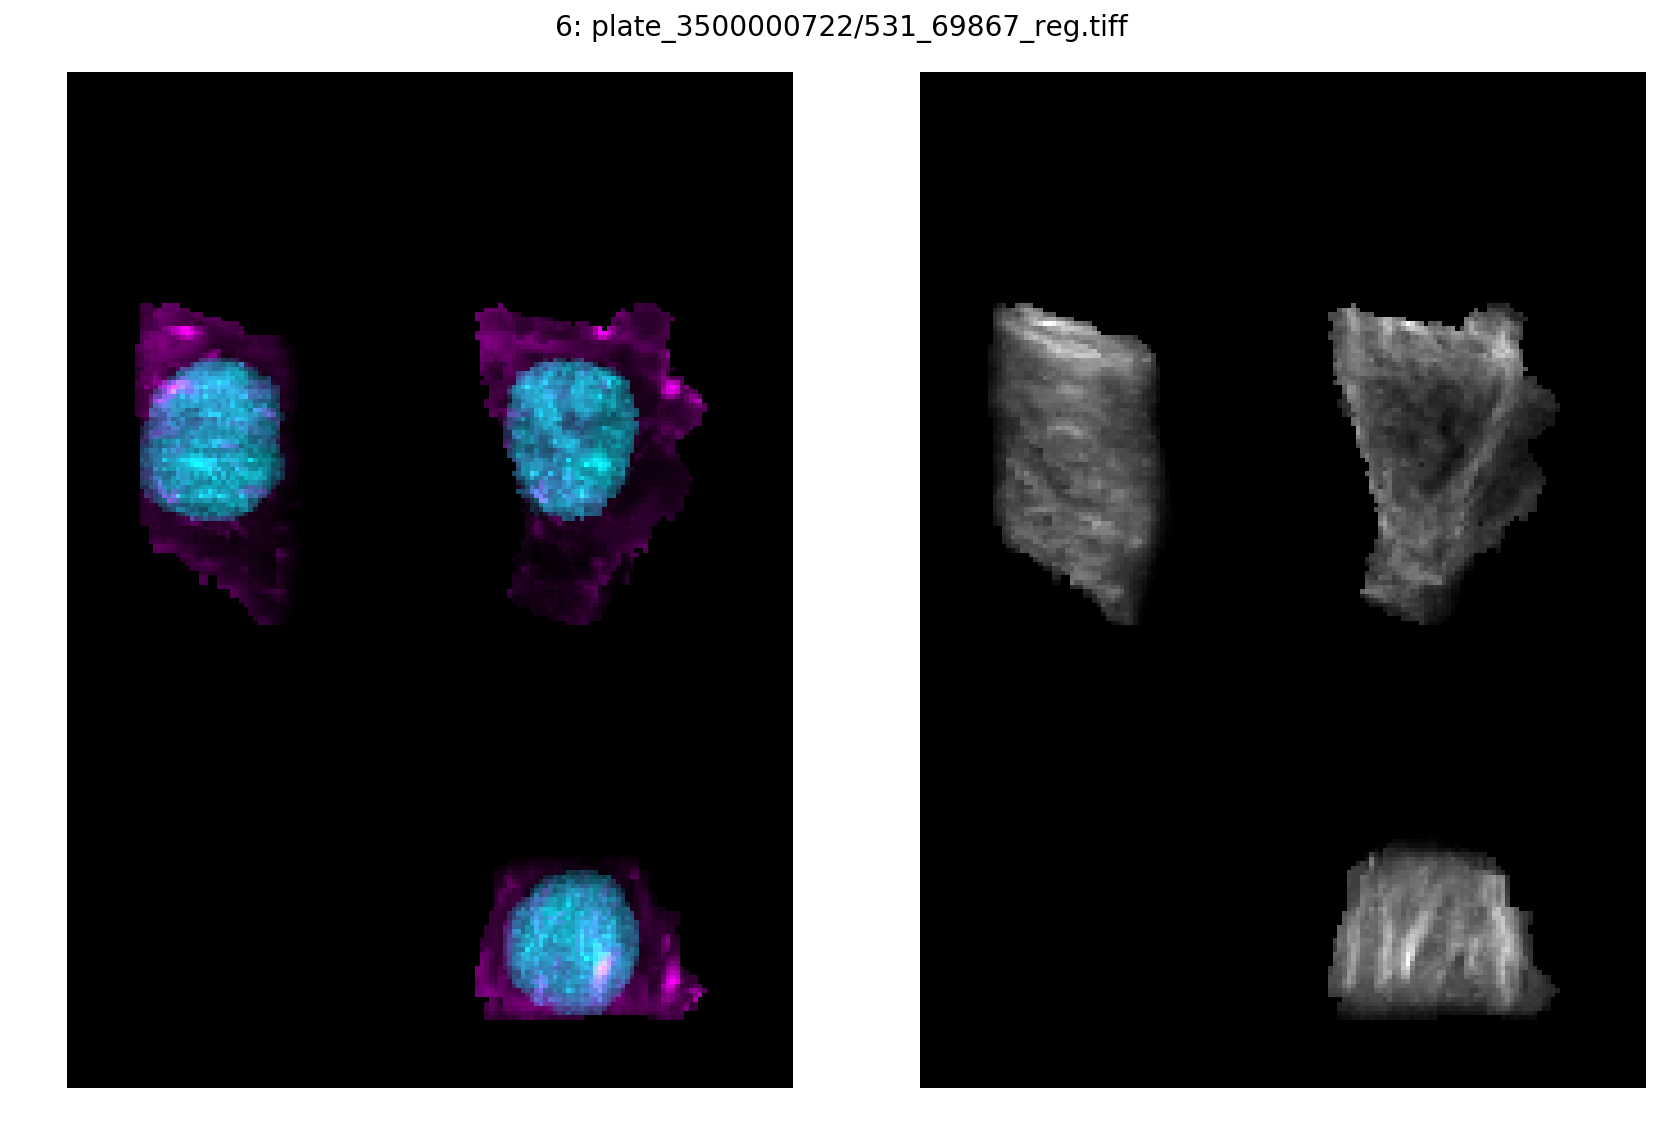

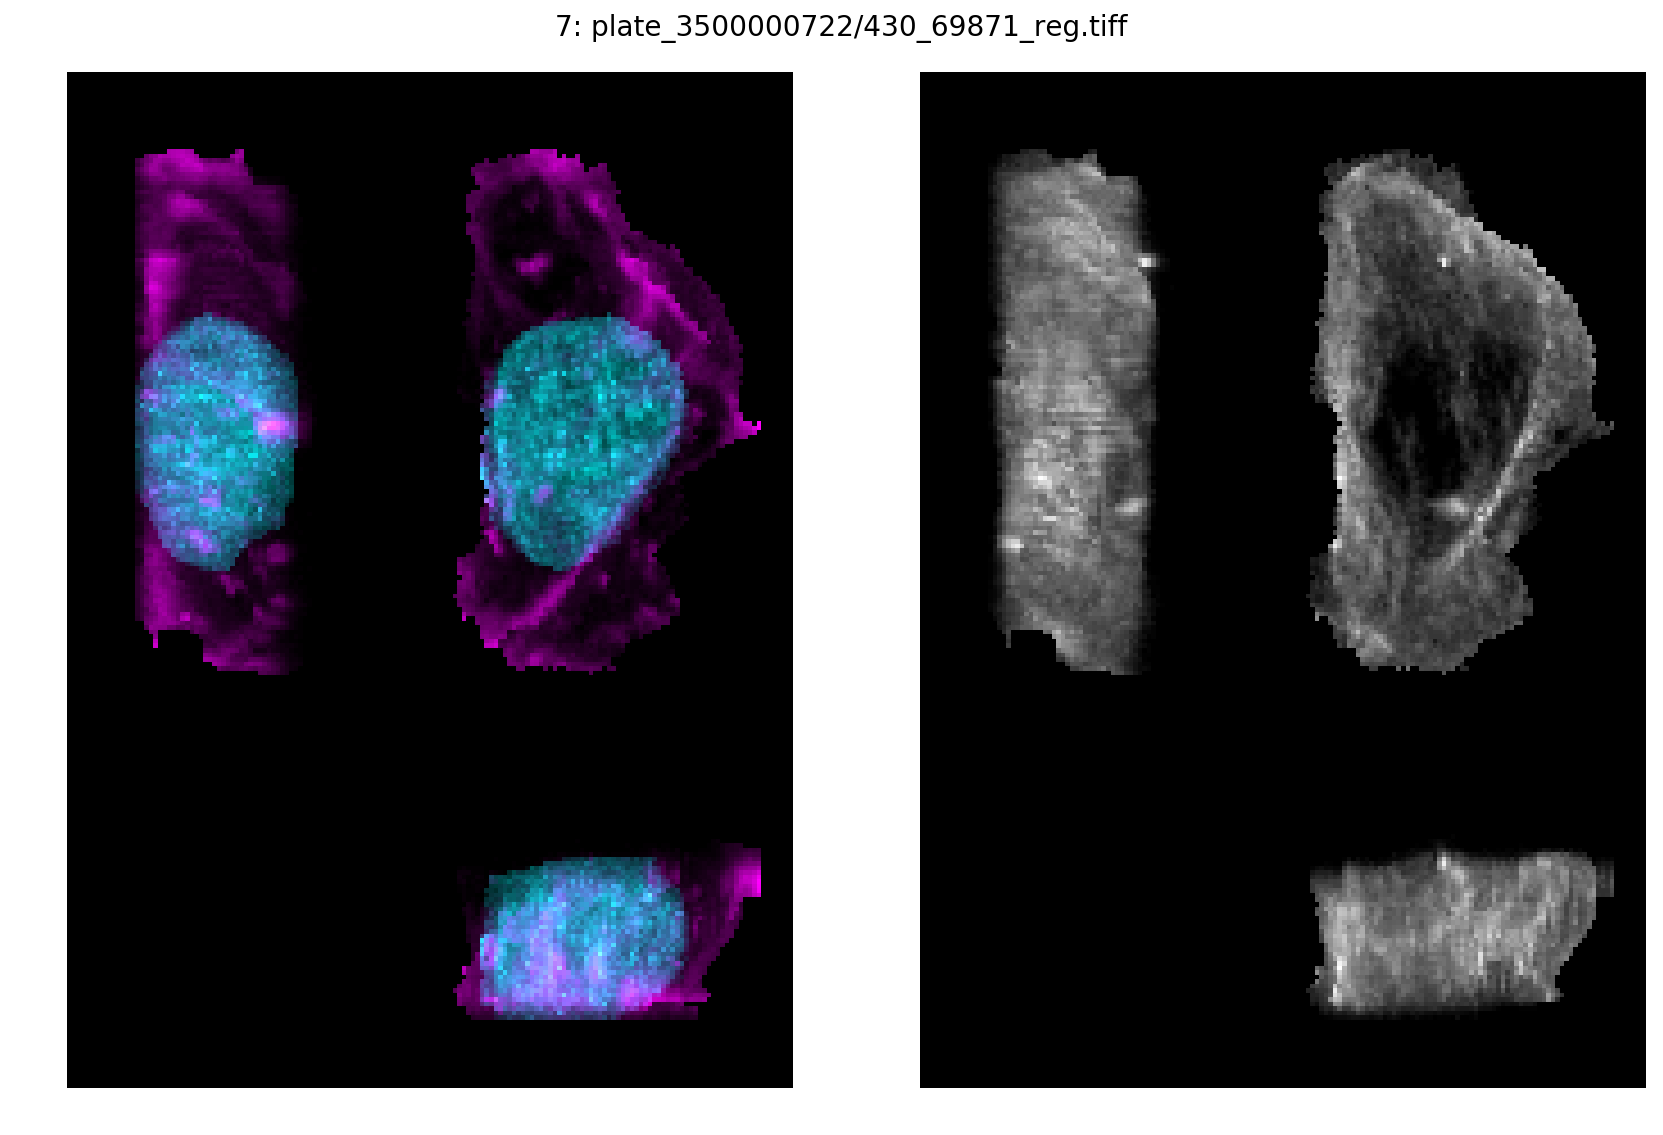

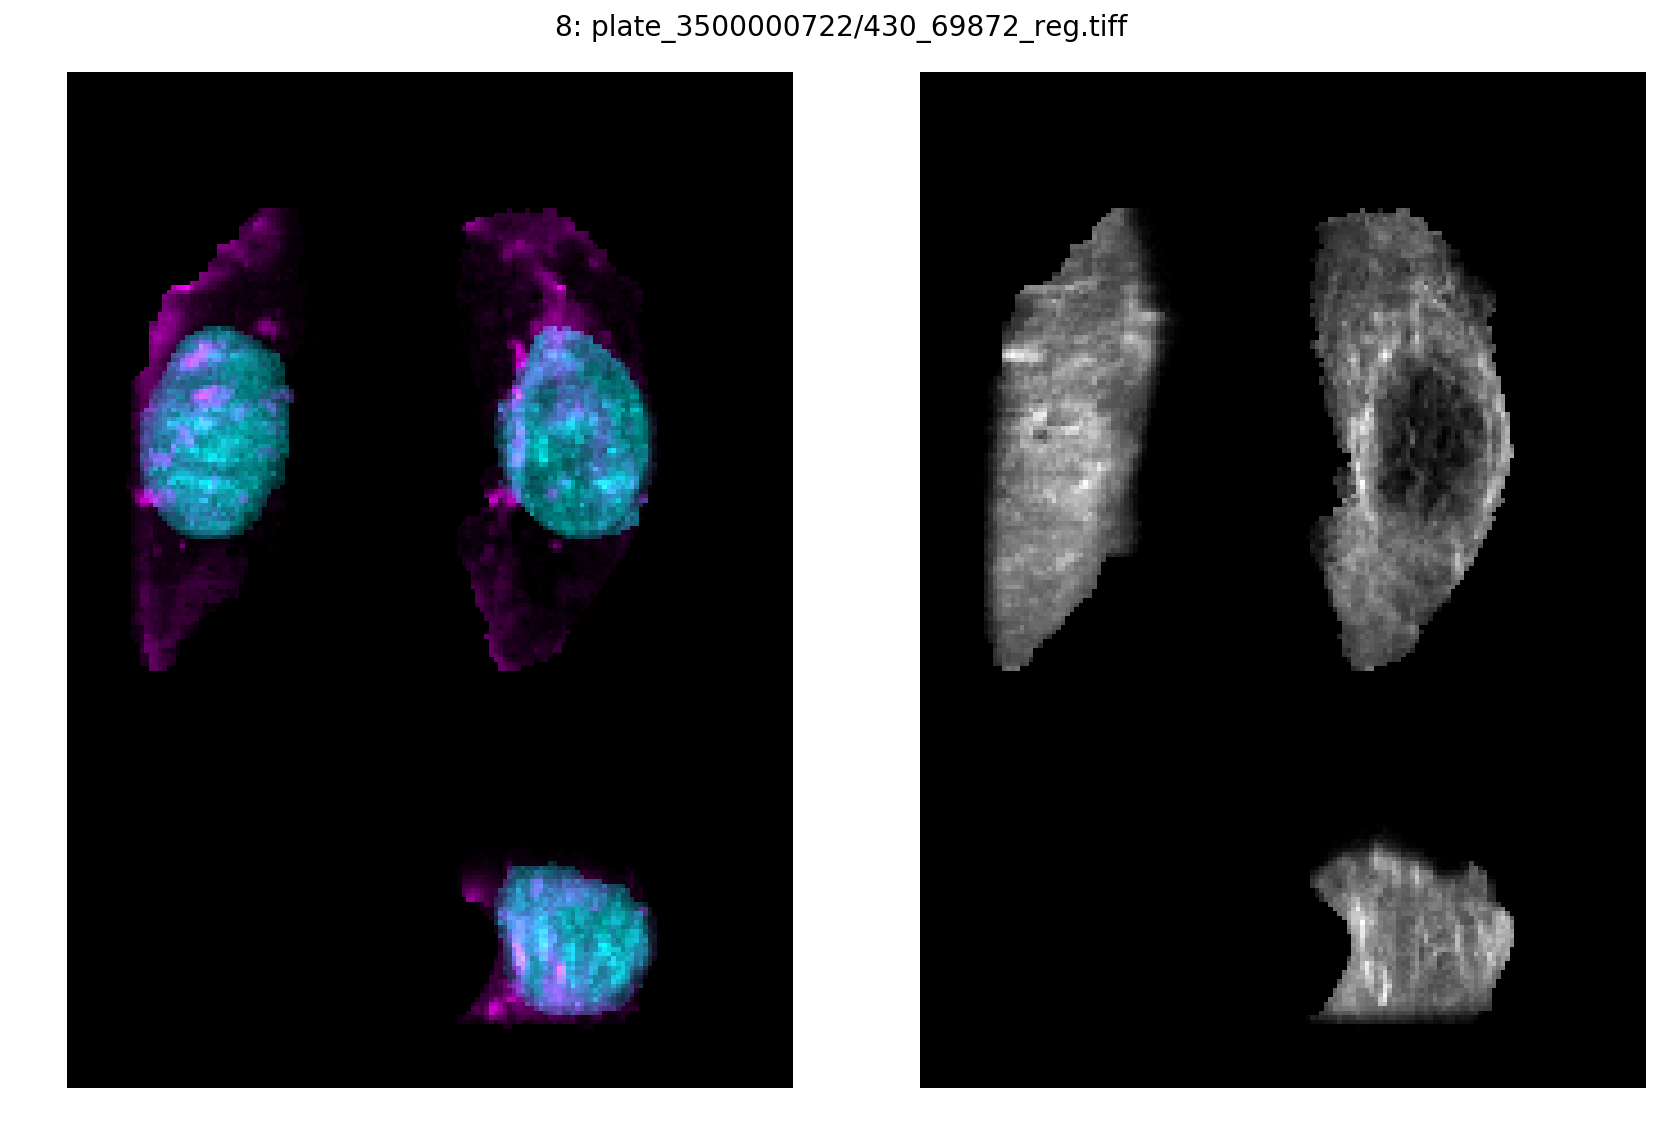

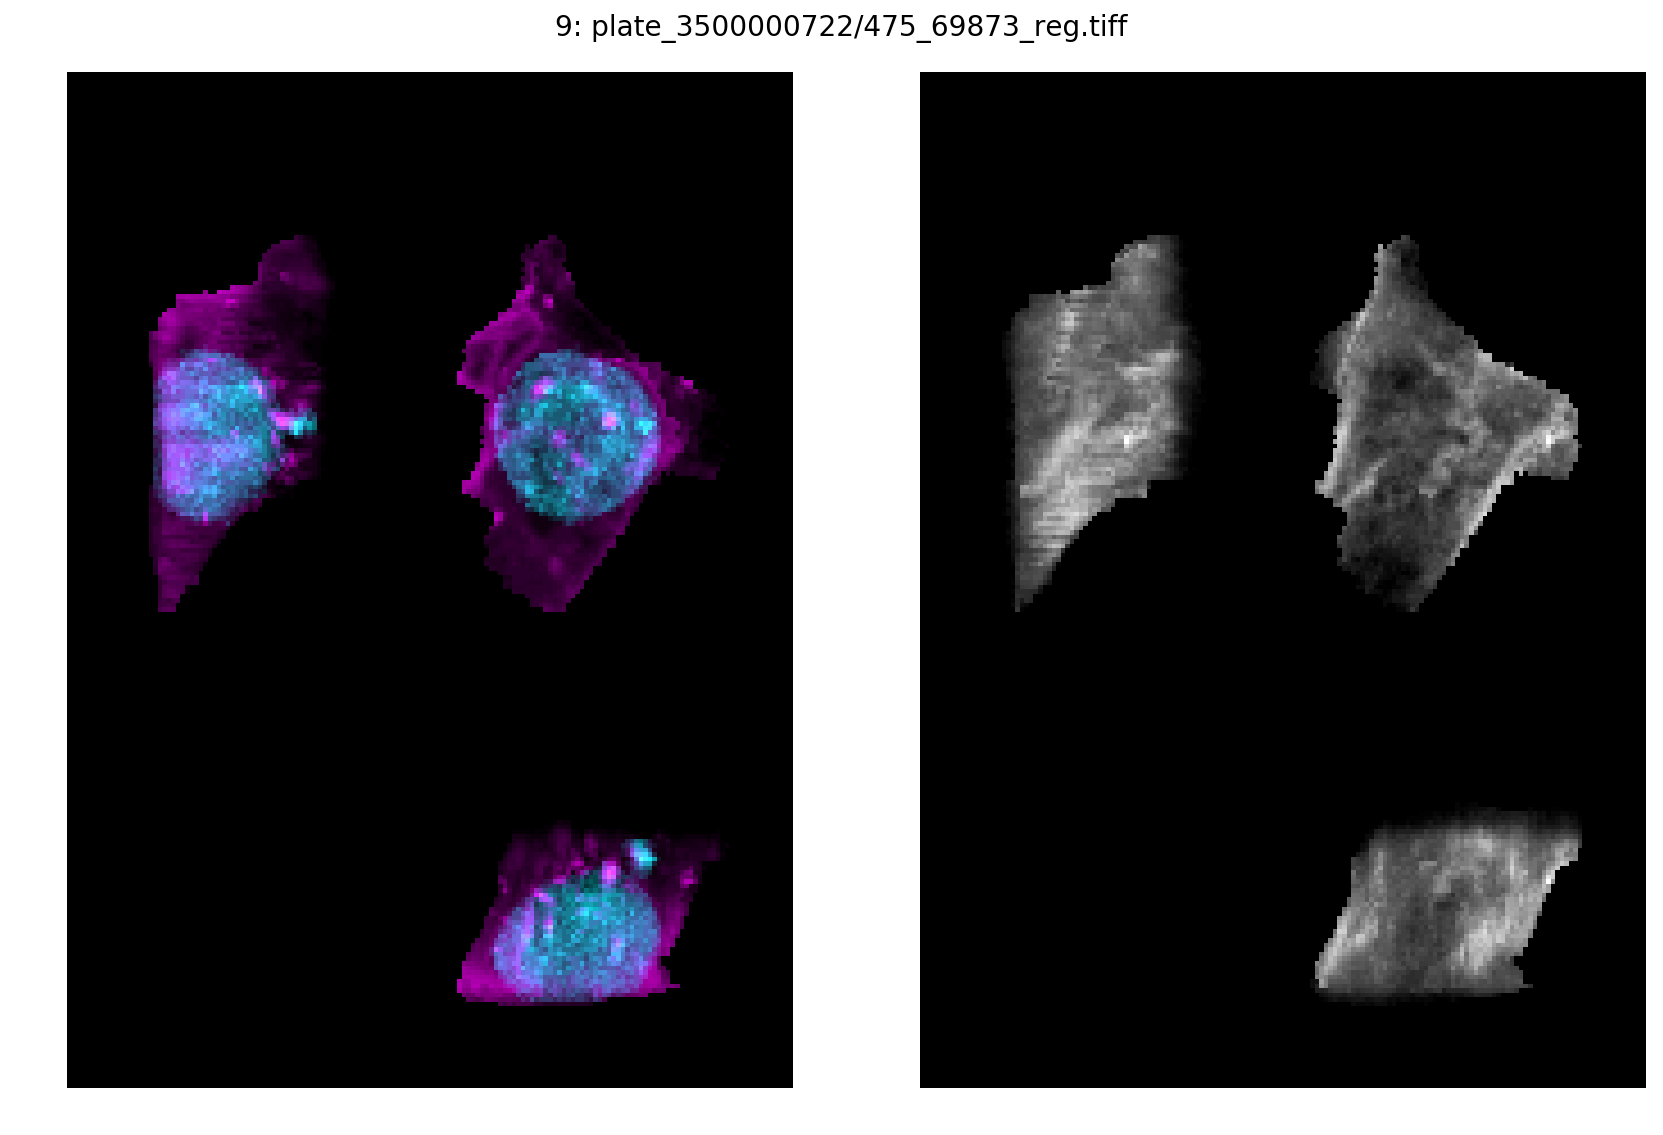

In [287]:
print(f'image_parent = {dp_ref.image_parent}, {dp_target.image_parent}')

for intIdx in np.arange(10):
    #ind = df_train_filtered_nocontrols.index[20]
    ind = next(iterIdx)

    ref_x = dp_ref.get_sample('train', [ind])
    target_x = dp_target.get_sample('train', [ind])

    #print(f"{df_train_filtered_nocontrols.loc[ind][['UnsplitCsvIndex', 'CellId', 'CellIndex', 'Mitotic state', 'Gene', 'Protein', 'ProteinDisplayName', 'Structure', 'StructureDisplayName', 'StructureShortName', 'ProteinId/Name', 'StructureId/Name', 'save_reg_path', 'ControlMask']]}")
    print(f"{intIdx} ({ind}): {df_train_filtered_nocontrols.loc[ind]['save_reg_path']}")

    #print(f'ref_x.shape = {ref_x.shape}')
    #print(f'target_x.shape = {target_x.shape}')

    objFig, (objAx1, objAx2) = plt.subplots(1, 2, figsize = (12, 8))
    plt.suptitle(f"{intIdx}: {df_train_filtered_nocontrols.loc[ind]['save_reg_path']}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    imshow_subplot(ref_x, objAx1, scale_channels=True, scale_global=False)
    imshow_subplot(target_x[0], objAx2, scale_channels=True, scale_global=False)

## Filter by cell features (leaving out control cells)

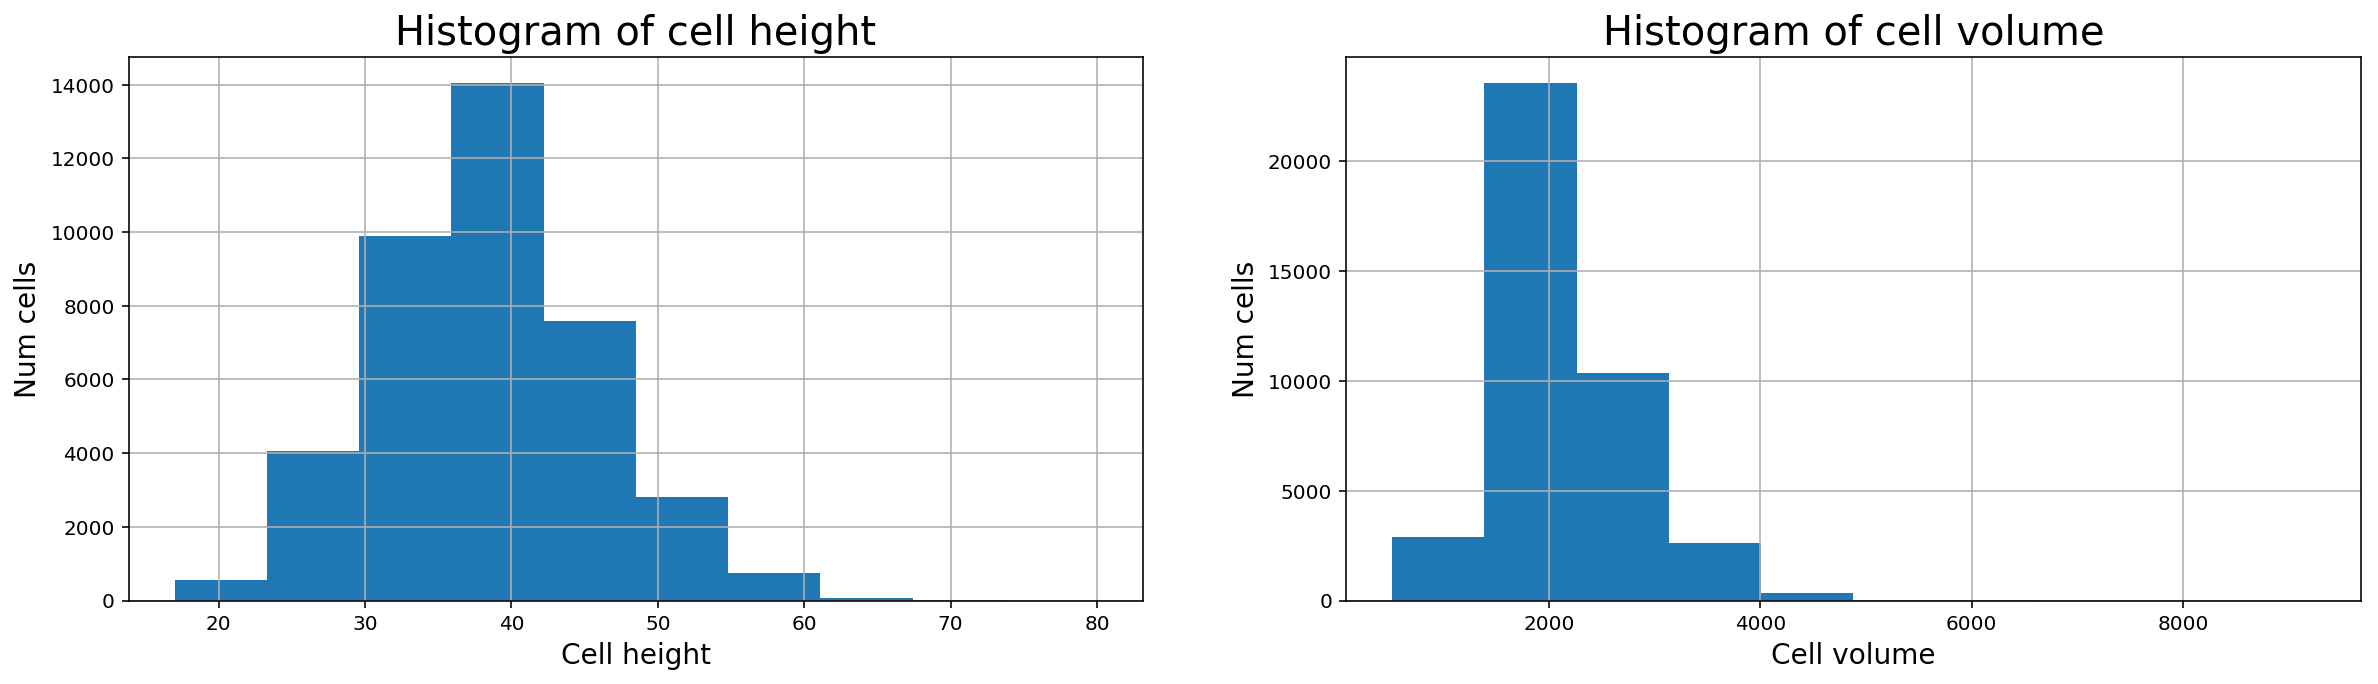

In [179]:
objFig, objAxes = plt.subplots(1, 2, figsize=(20, 5))

_ = df_embeddings_plus_meta_train_pretty_names['Cell height'].hist(ax=objAxes[0])
_ = objAxes[0].set_title('Histogram of cell height', fontsize=20)
_ = objAxes[0].set_xlabel('Cell height', fontsize=14)
_ = objAxes[0].set_ylabel('Num cells', fontsize=14)

_ = df_embeddings_plus_meta_train_pretty_names['Cell volume'].hist(ax=objAxes[1])
_ = objAxes[1].set_title('Histogram of cell volume', fontsize=20)
_ = objAxes[1].set_xlabel('Cell volume', fontsize=14)
_ = objAxes[1].set_ylabel('Num cells', fontsize=14)

In [294]:
mitotic_state = 'M0'
#structure = 'Lysosome'
cell_height = 20
#cell_height = 50
operator = '<='
#operator = '>='
sort_dir=False

#df_train_filtered = df_embeddings_plus_meta_train_pretty_names.query(f"`Mitotic state` == @mitotic_state & Structure == @structure & `Cell height` {operator} @cell_height")
df_train_filtered = df_embeddings_plus_meta_train_pretty_names.query(f"`Mitotic state` == @mitotic_state & `Cell height` {operator} @cell_height")
df_train_filtered_nocontrols = df_train_filtered[df_train_filtered['ControlMask'] == False].sort_values('Cell height', ascending=sort_dir)

df_train_filtered_nocontrols[['UnsplitCsvIndex', 'CellId', 'Mitotic state', 'Structure', 'Cell height', 'save_reg_path']]

,UnsplitCsvIndex,CellId,Mitotic state,Structure,Cell height,save_reg_path
28565,35528,93758,M0,Nucleolus (Granular Component),20.0,plate_3500001988/12209_93758_reg.tiff
16278,20211,73297,M0,Nuclear envelope,20.0,plate_3500000953/16142_73297_reg.tiff
18277,22737,81314,M0,Nuclear envelope,20.0,plate_3500000956/15322_81314_reg.tiff
2092,2604,12988,M0,Mitochondria,20.0,plate_3500000974/3059_12988_reg.tiff
23820,29599,126370,M0,Matrix adhesions,20.0,plate_3500001917/11669_126370_reg.tiff
24047,29873,127089,M0,Matrix adhesions,20.0,plate_3500001920/11696_127089_reg.tiff
17737,22053,79298,M0,Nuclear envelope,20.0,plate_3500000949/2536_79298_reg.tiff
24062,29892,127141,M0,Matrix adhesions,20.0,plate_3500001920/11674_127141_reg.tiff
24071,29907,127173,M0,Matrix adhesions,20.0,plate_3500001920/11750_127173_reg.tiff
21528,26766,50869,M0,Tight junctions,20.0,plate_3500001327/6416_50869_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24047: plate_3500001920/11696_127089_reg.tiff


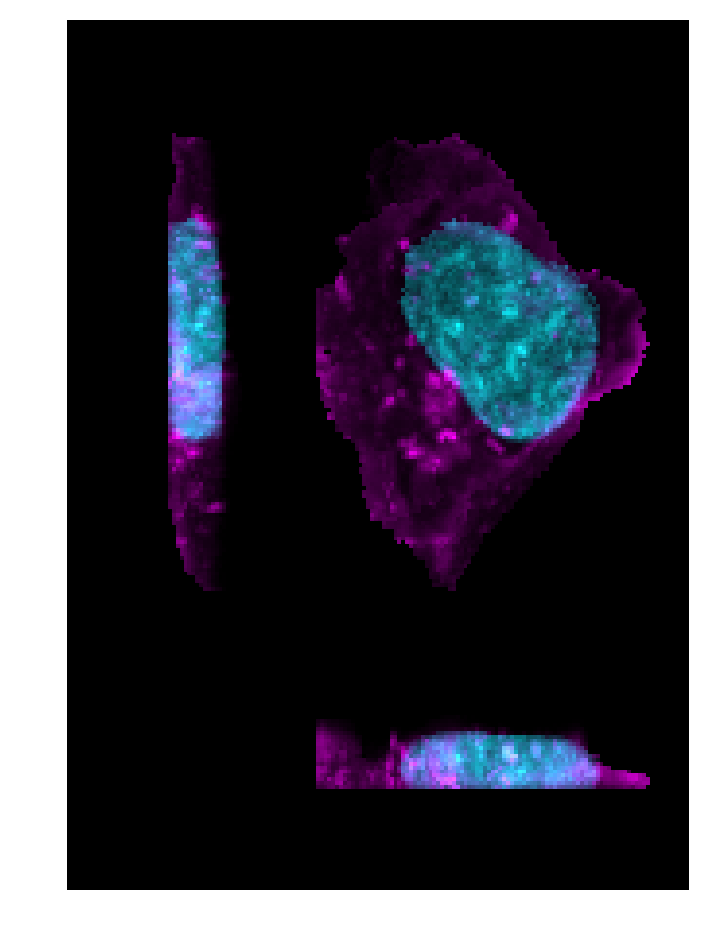

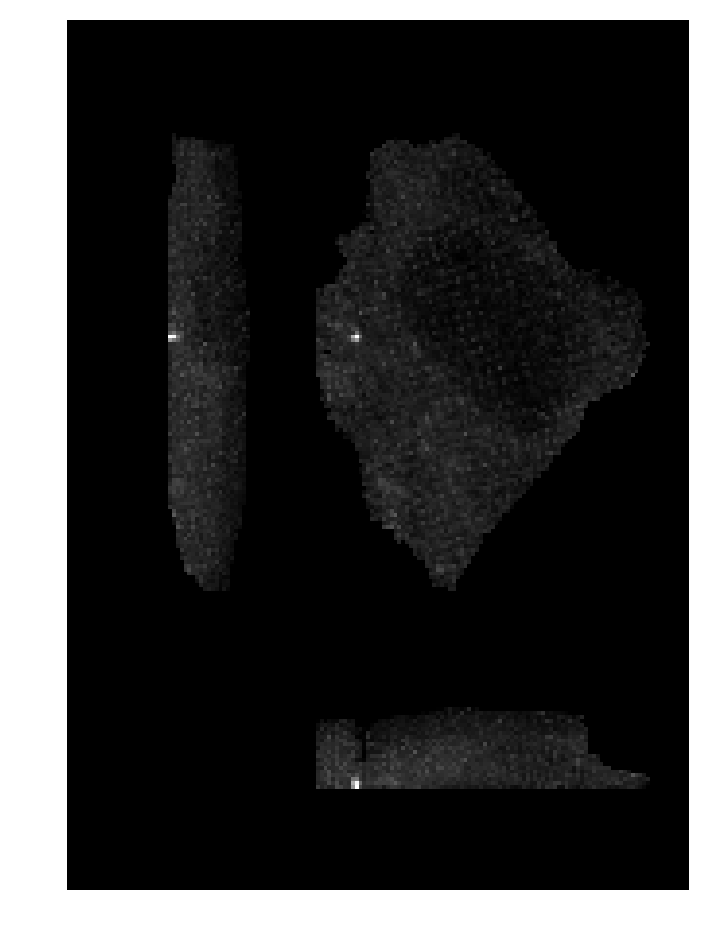

In [297]:
#ind = df_train_filtered_nocontrols.index[-1]
ind = 24047

ref_x = dp_ref.get_sample('train', [ind])
target_x = dp_target.get_sample('train', [ind])

#print(f"{df_train_filtered_nocontrols.loc[ind][['UnsplitCsvIndex', 'CellId', 'CellIndex', 'Mitotic state', 'Gene', 'Protein', 'ProteinDisplayName', 'Structure', 'StructureDisplayName', 'StructureShortName', 'ProteinId/Name', 'StructureId/Name', 'save_reg_path', 'ControlMask']]}")
print(f"{ind}: {df_train_filtered_nocontrols.loc[ind]['save_reg_path']}")

#print(f'ref_x.shape = {ref_x.shape}')
#print(f'target_x.shape = {target_x.shape}')

plt.figure(figsize=(6, 8))
imshow(ref_x, scale_channels=True, scale_global=False)
plt.figure(figsize=(6, 8))
imshow(target_x[0], scale_channels=True, scale_global=False)

In [295]:
iterIdx = iter(df_train_filtered_nocontrols.index)
print(f'{len(df_train_filtered_nocontrols.index)}')

45


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_parent = /raid/shared/ipp/scp_19_04_10/, /raid/shared/ipp/scp_19_04_10/
0 (28565): plate_3500001988/12209_93758_reg.tiff
1 (16278): plate_3500000953/16142_73297_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 (18277): plate_3500000956/15322_81314_reg.tiff
3 (2092): plate_3500000974/3059_12988_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 (23820): plate_3500001917/11669_126370_reg.tiff
5 (24047): plate_3500001920/11696_127089_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 (17737): plate_3500000949/2536_79298_reg.tiff
7 (24062): plate_3500001920/11674_127141_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 (24071): plate_3500001920/11750_127173_reg.tiff
9 (21528): plate_3500001327/6416_50869_reg.tiff


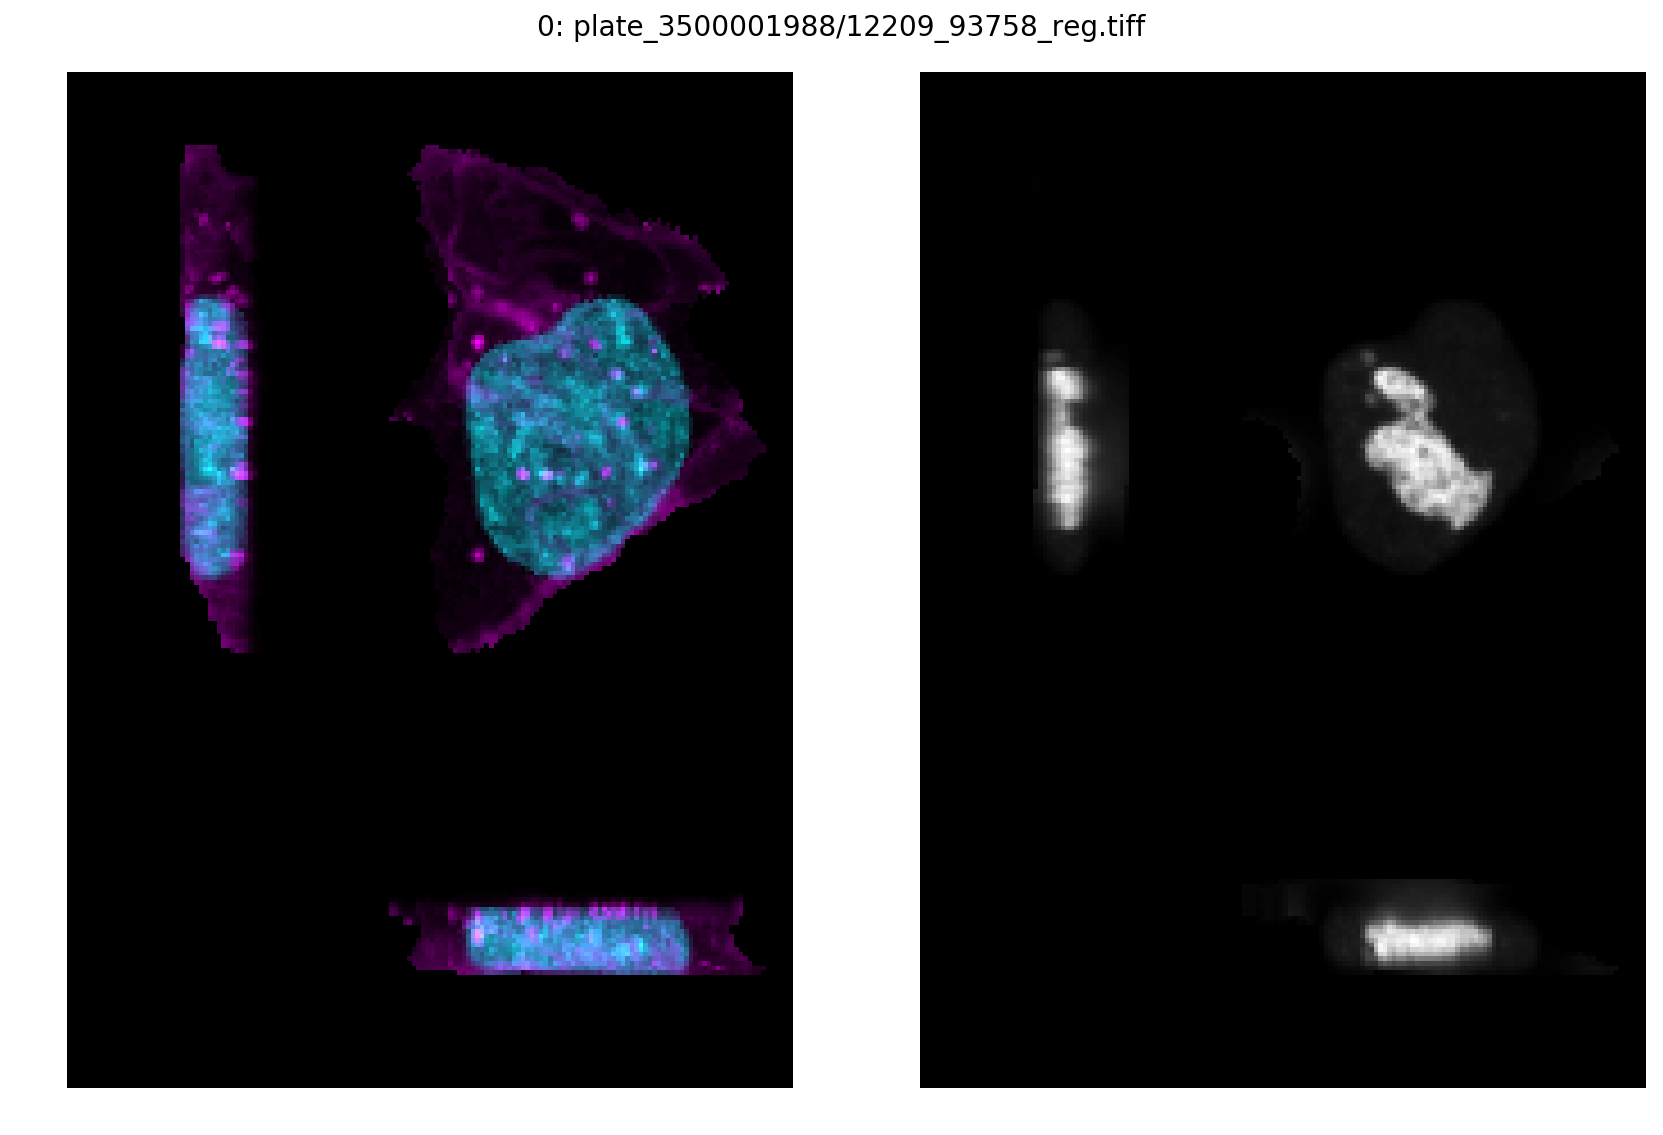

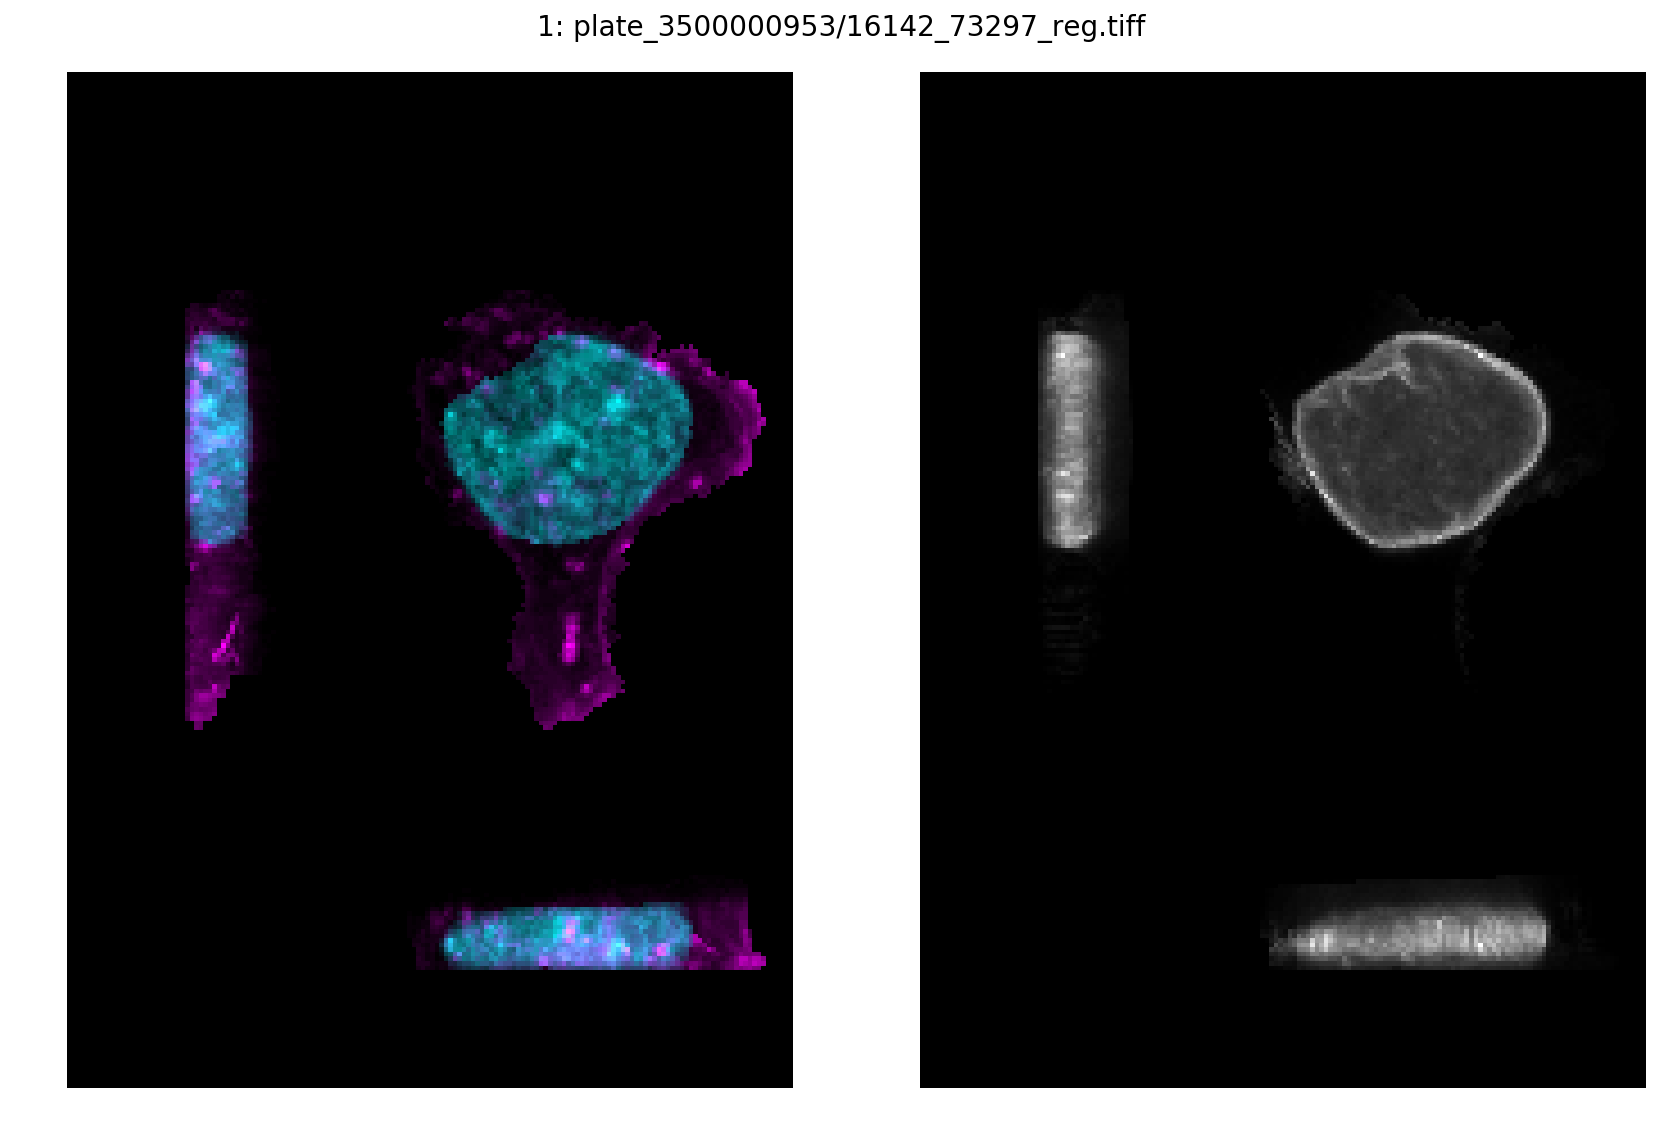

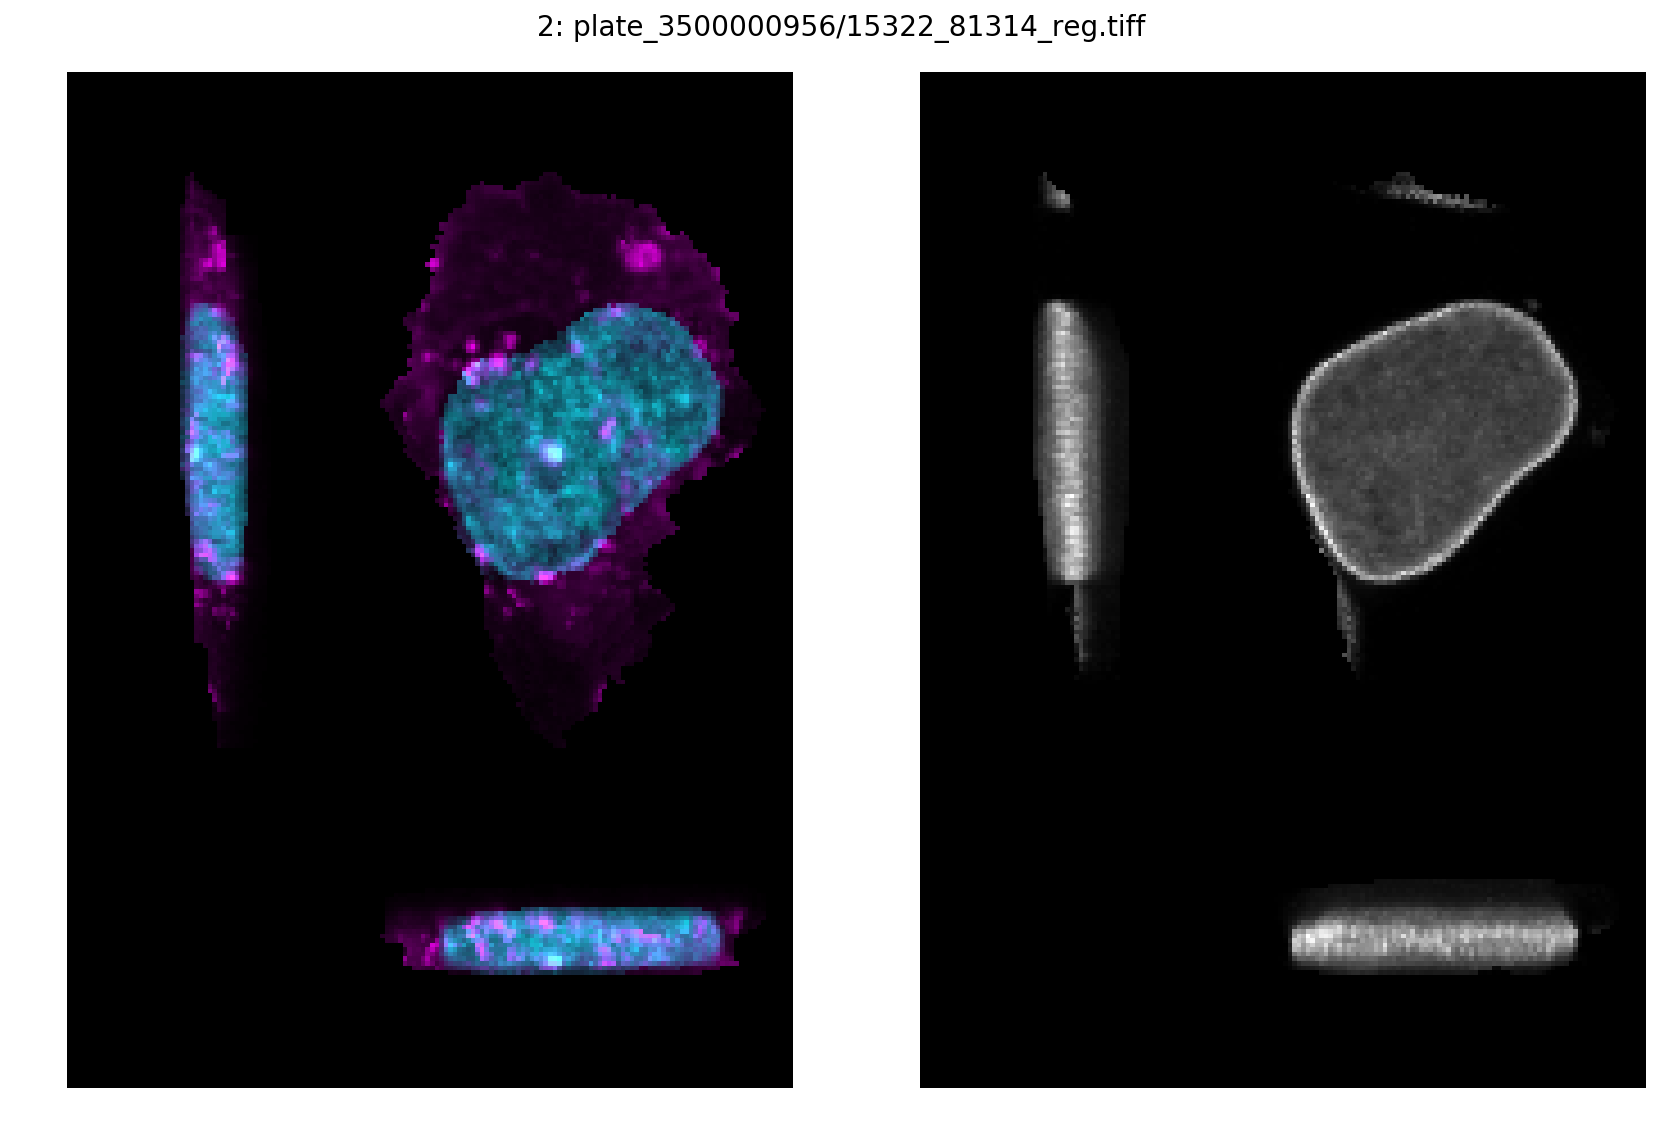

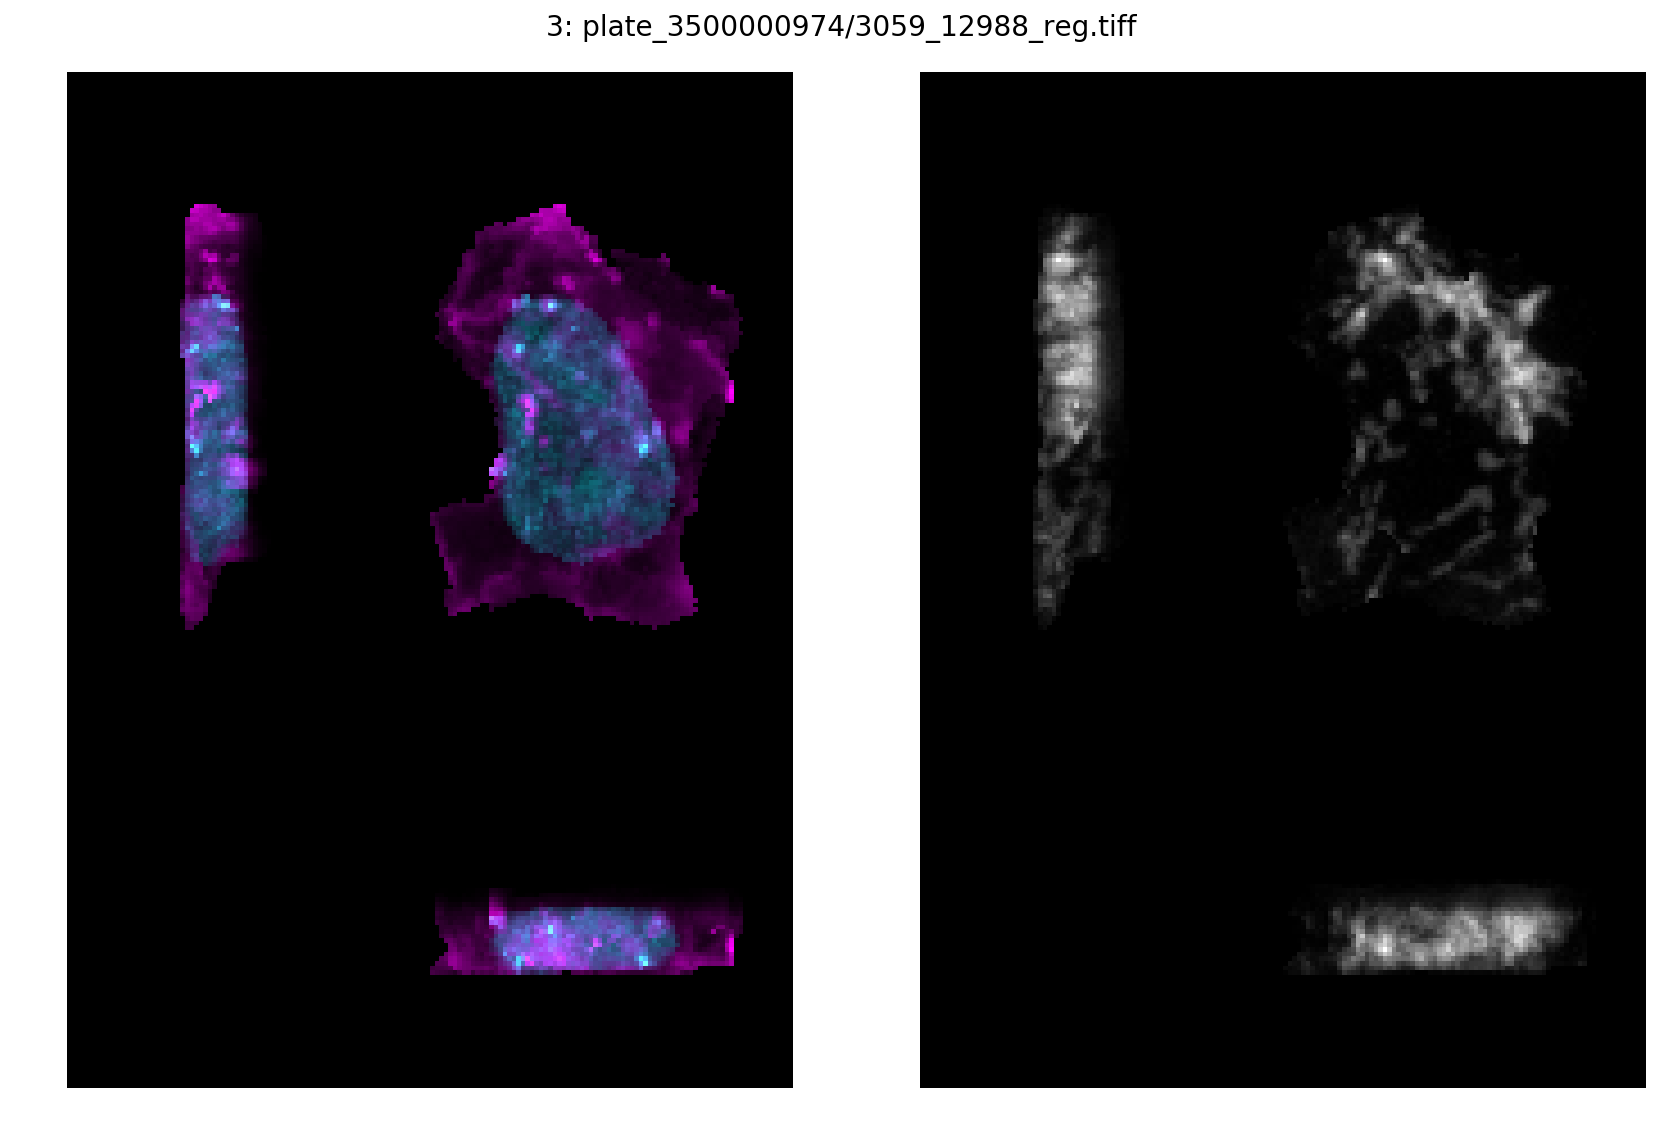

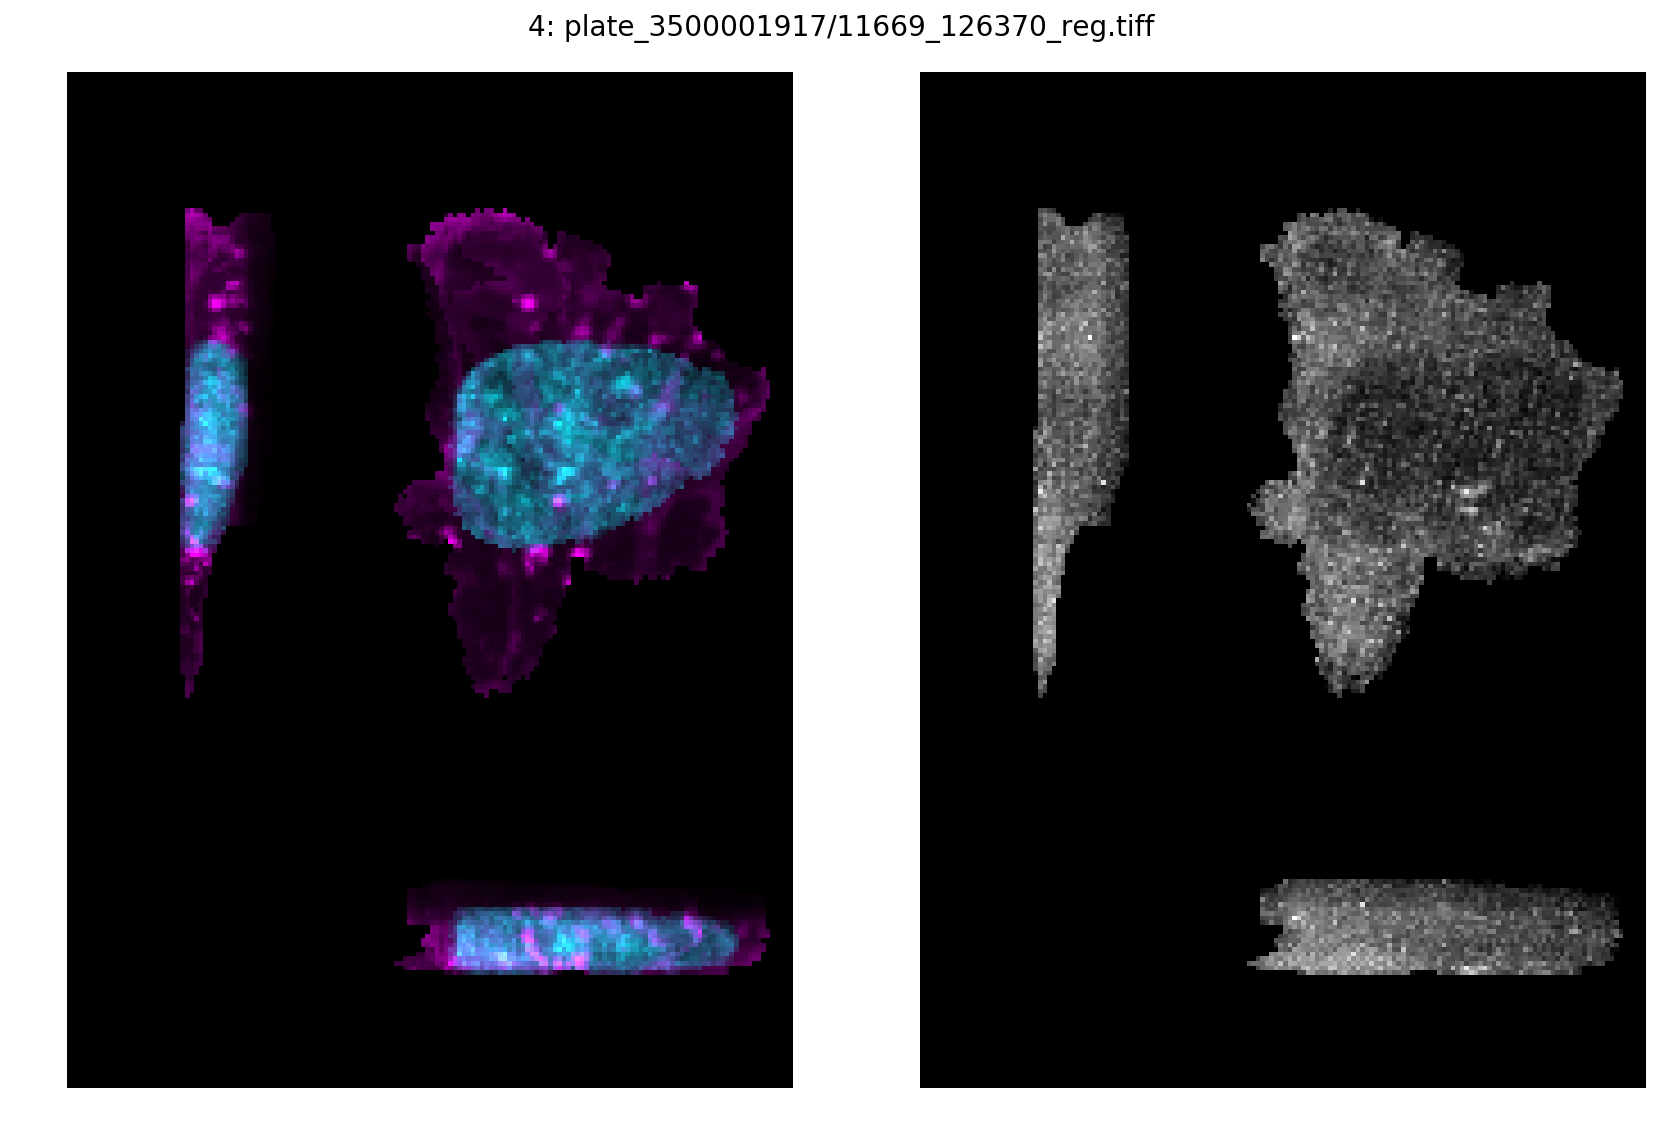

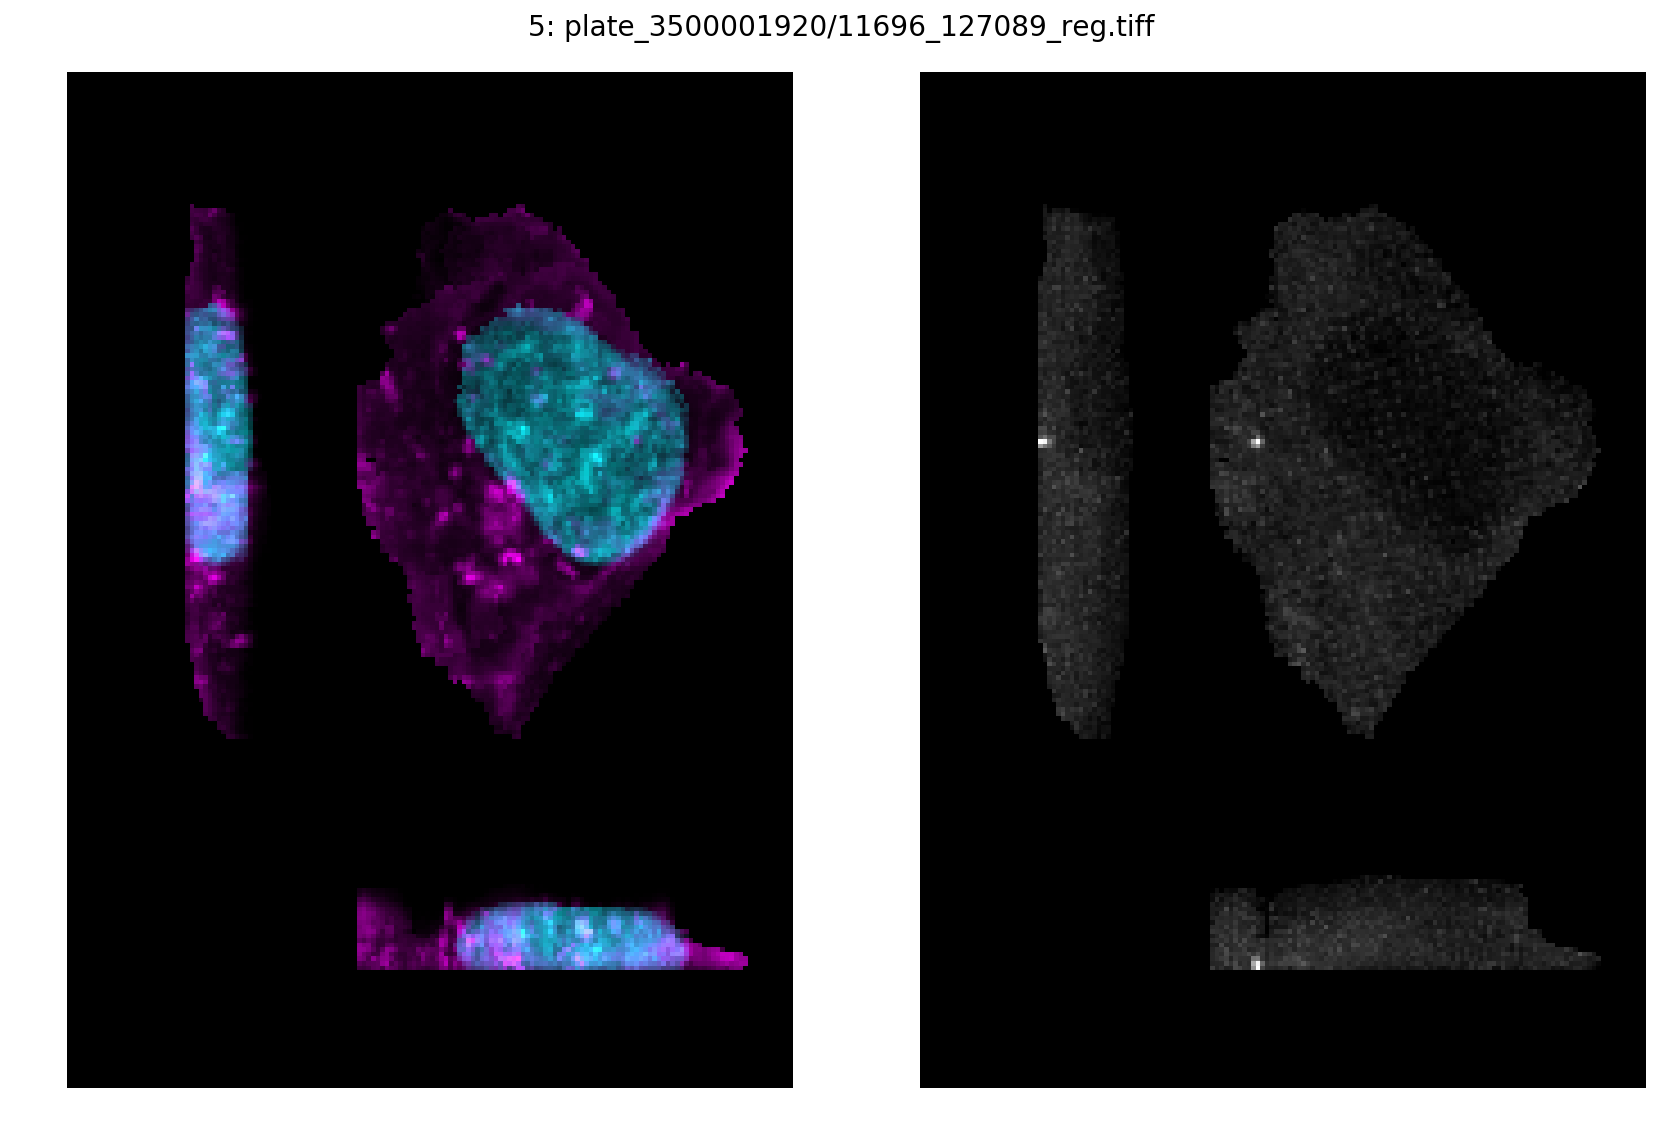

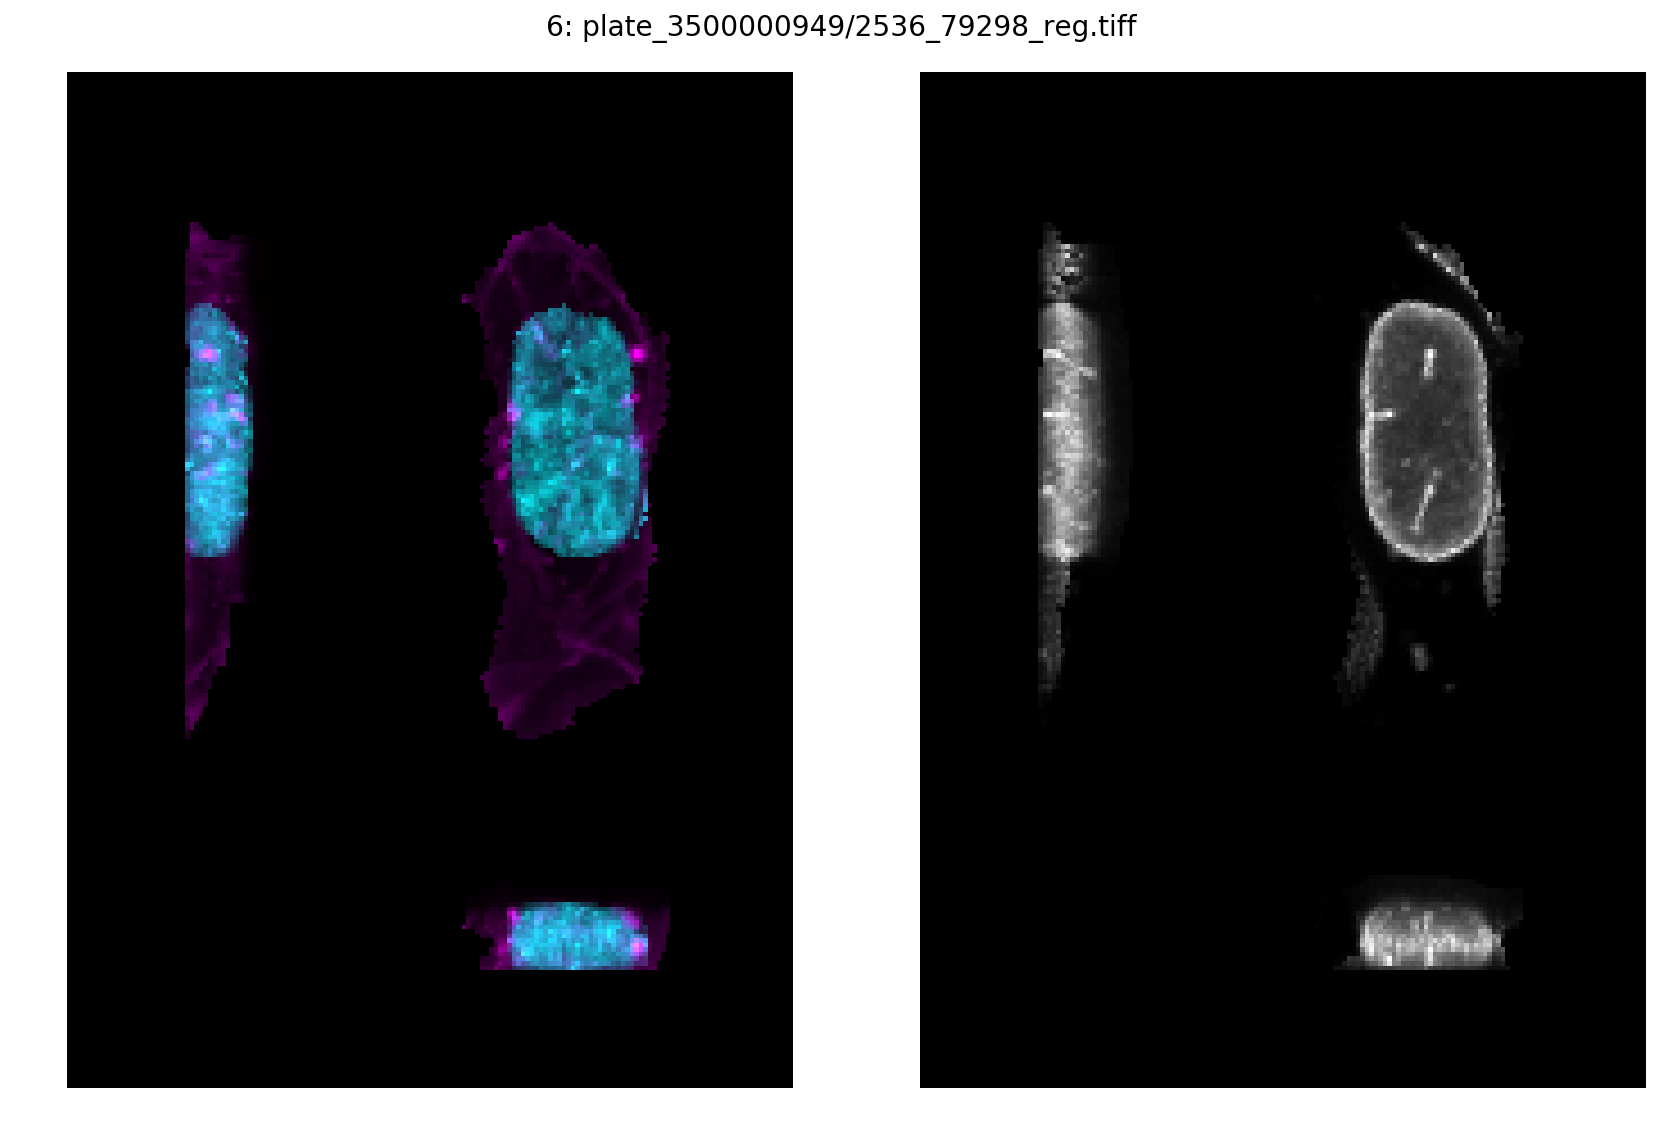

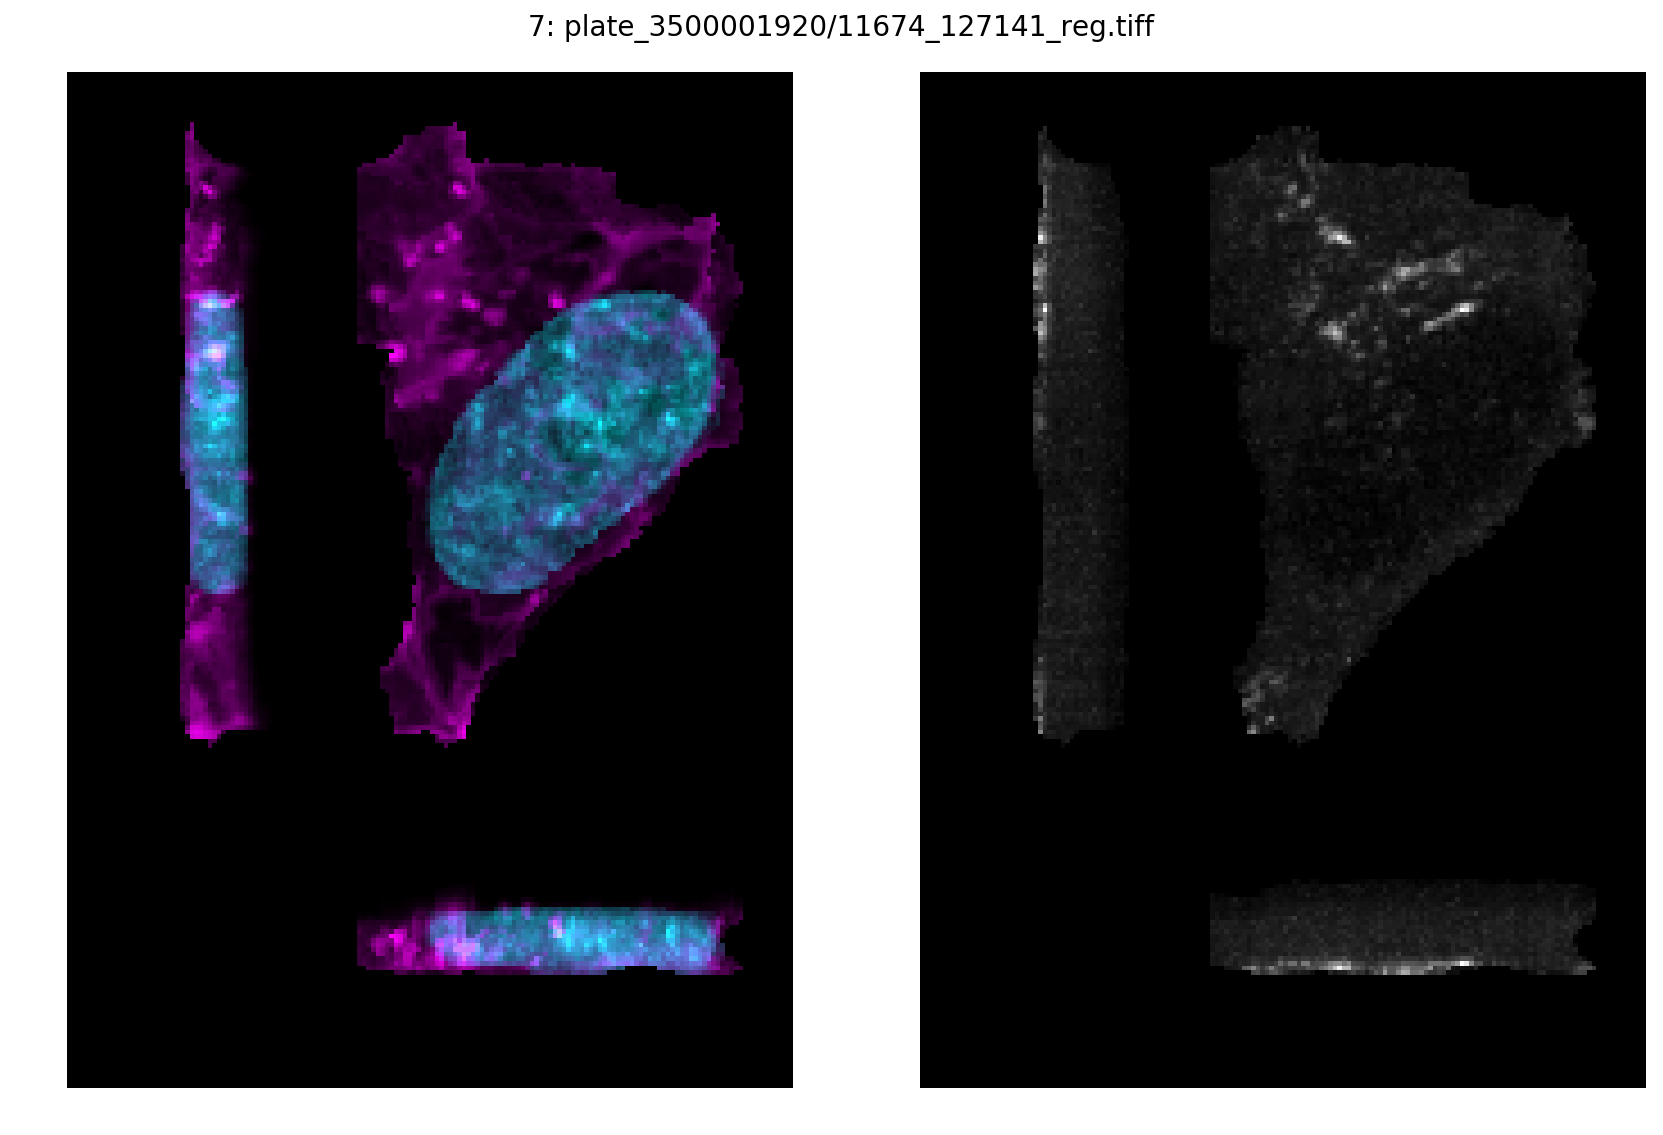

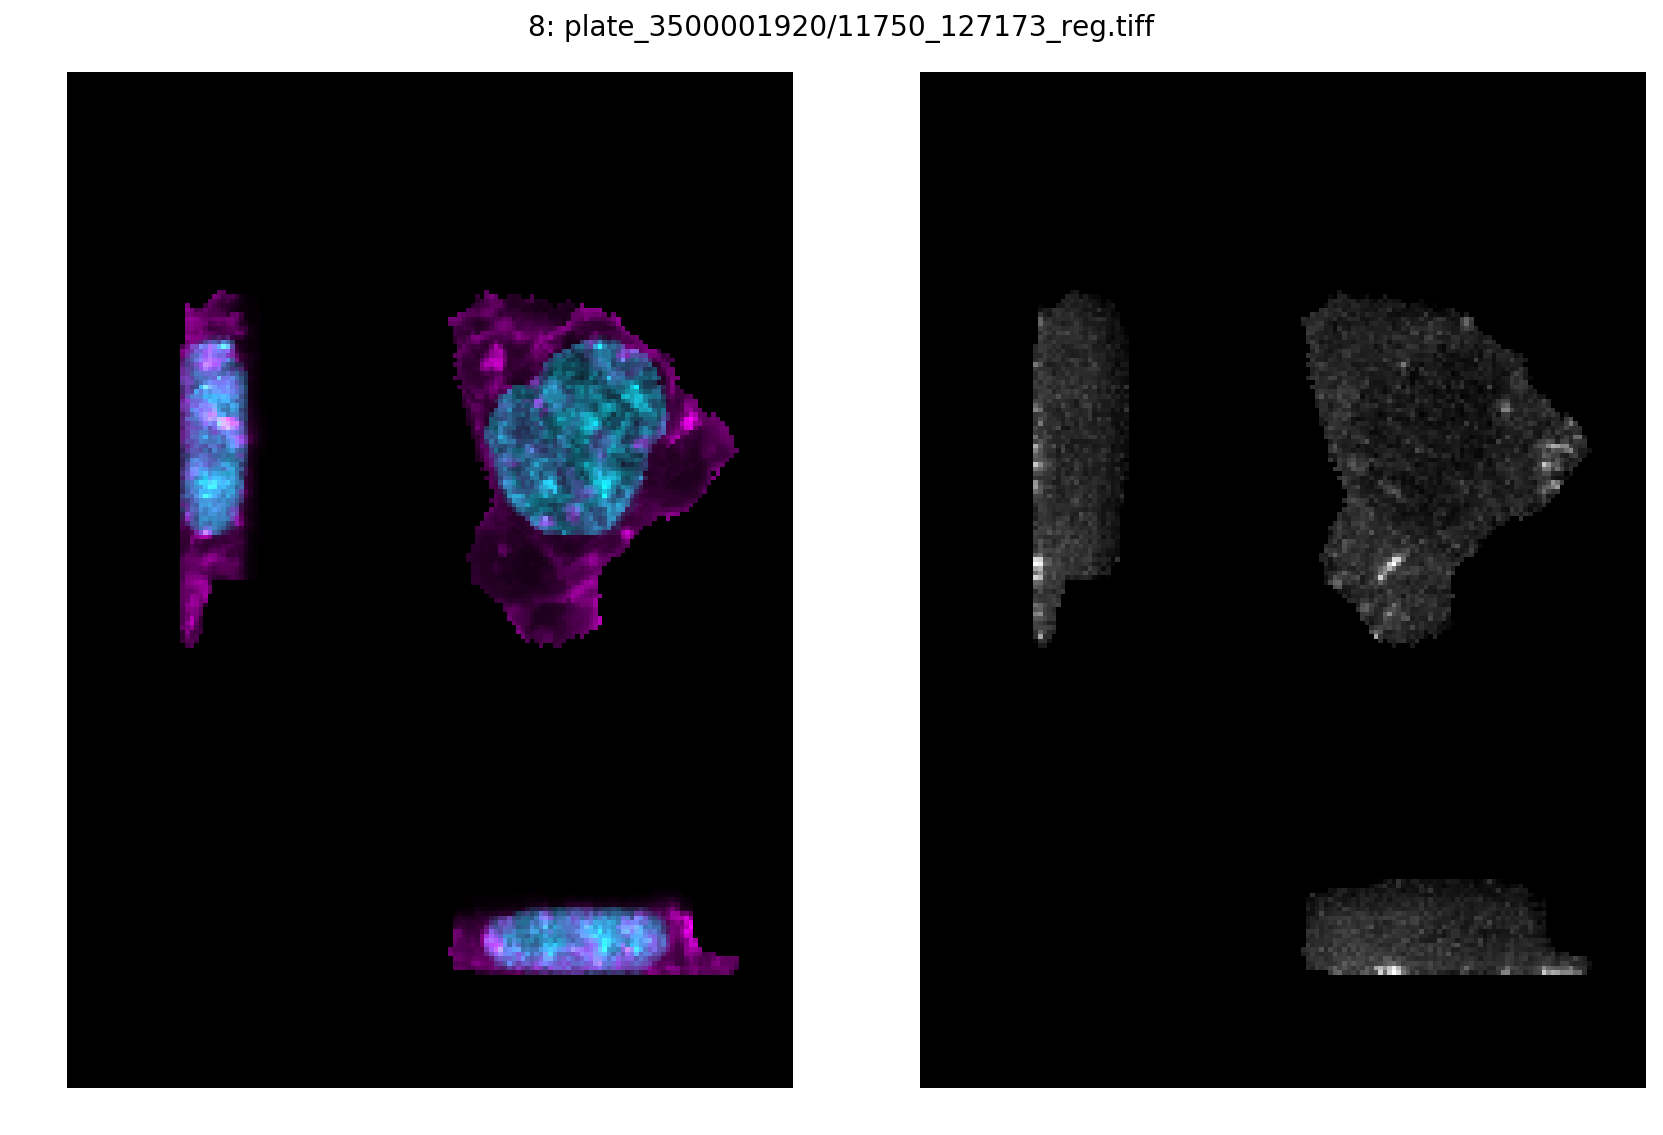

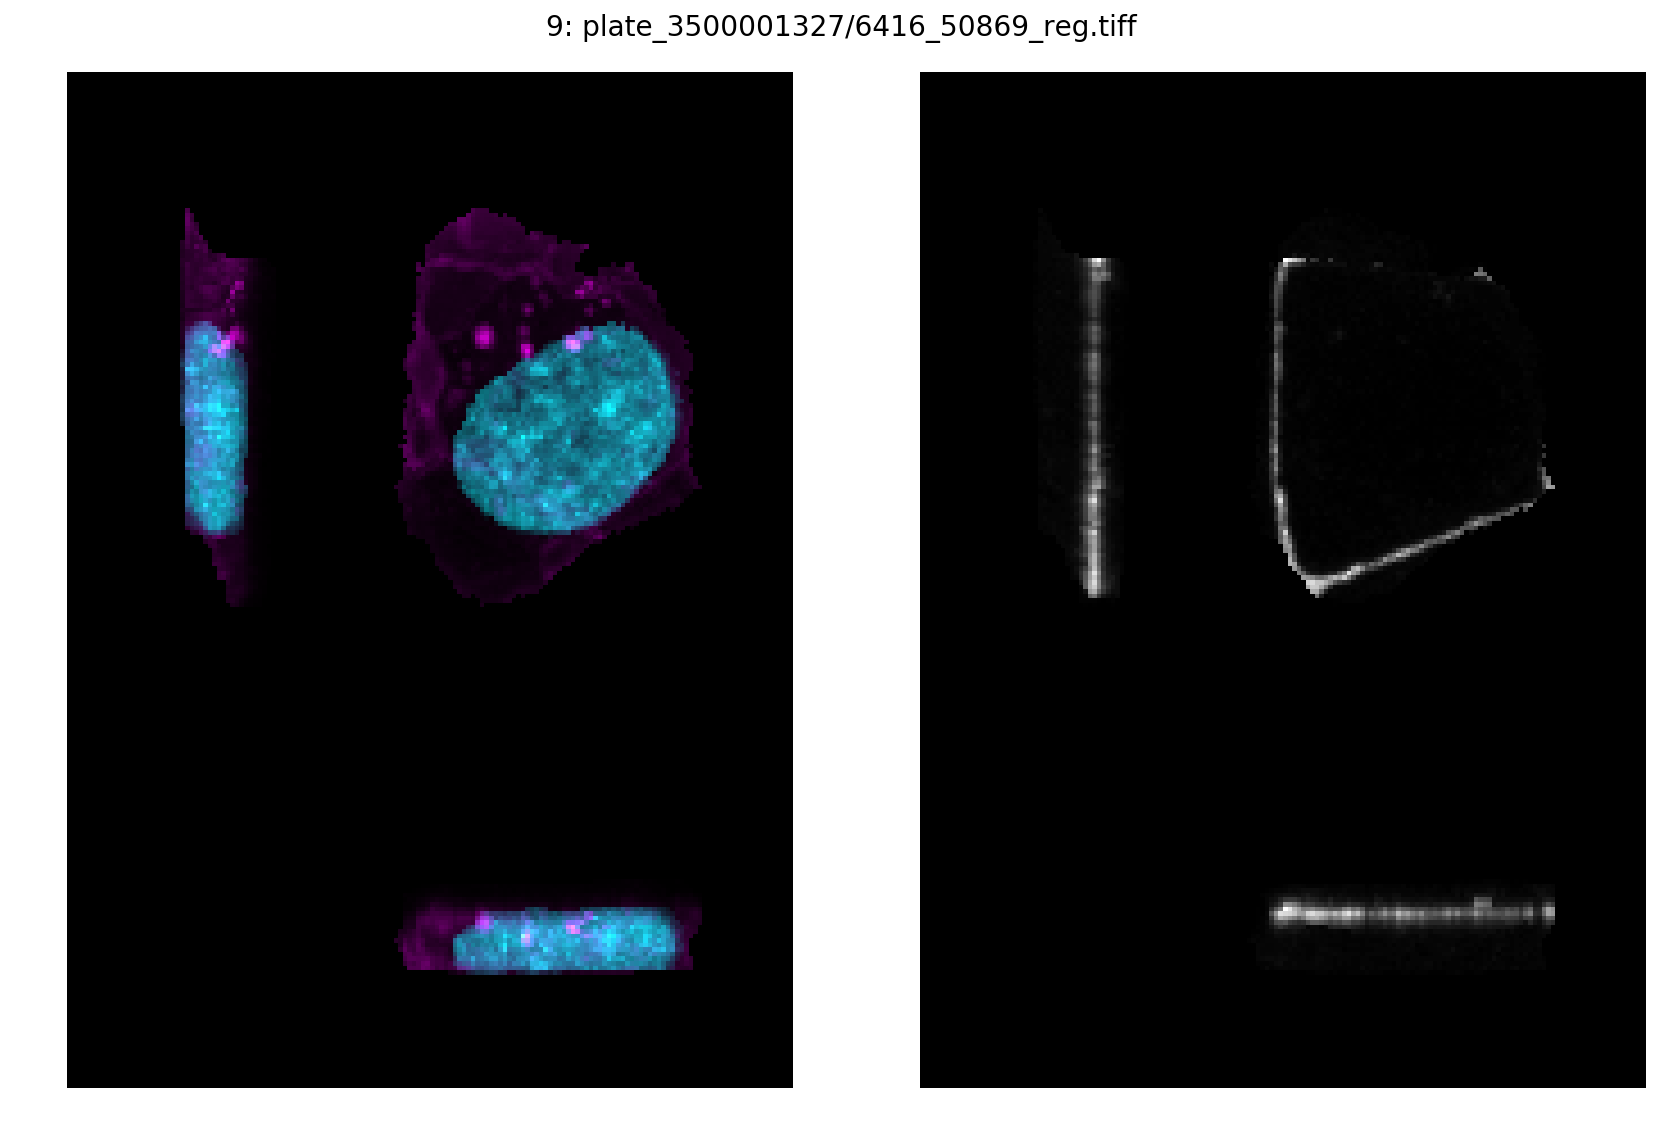

In [296]:
print(f'image_parent = {dp_ref.image_parent}, {dp_target.image_parent}')

for intIdx in np.arange(10):
    #ind = df_train_filtered_nocontrols.index[-1]
    ind = next(iterIdx)

    ref_x = dp_ref.get_sample('train', [ind])
    target_x = dp_target.get_sample('train', [ind])

    #print(f"{df_train_filtered_nocontrols.loc[ind][['UnsplitCsvIndex', 'CellId', 'CellIndex', 'Mitotic state', 'Gene', 'Protein', 'ProteinDisplayName', 'Structure', 'StructureDisplayName', 'StructureShortName', 'ProteinId/Name', 'StructureId/Name', 'save_reg_path', 'ControlMask']]}")
    print(f"{intIdx} ({ind}): {df_train_filtered_nocontrols.loc[ind]['save_reg_path']}")

    #print(f'ref_x.shape = {ref_x.shape}')
    #print(f'target_x.shape = {target_x.shape}')

    objFig, (objAx1, objAx2) = plt.subplots(1, 2, figsize = (12, 8))
    plt.suptitle(f"{intIdx}: {df_train_filtered_nocontrols.loc[ind]['save_reg_path']}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    imshow_subplot(ref_x, objAx1, scale_channels=True, scale_global=False)
    imshow_subplot(target_x[0], objAx2, scale_channels=True, scale_global=False)

## Load the drug dataproviders

In [51]:
from integrated_cell.utils import load_drug_data_provider

dp_ref_drugs = load_drug_data_provider(dp_ref, args_ref)
dp_target_drugs = load_drug_data_provider(dp_target, args_target)

#sanity check
assert dp_ref_drugs.__len__('test') == dp_target_drugs.__len__('test')

reading csv manifest
im_path = /allen/aics/modeling/gregj/results/ipp/scp_drug_pilot_fixed//plate_3500001171/nan_0_reg.tiff
DrugID-Concentration combinations
[[ 1.   5. ]
 [ 2.   5. ]
 [ 3.   0.1]
 [ 4.  25. ]
 [ 5.  50. ]
 [ 6.   0.5]]
reading csv manifest
im_path = /allen/aics/modeling/gregj/results/ipp/scp_drug_pilot_fixed//plate_3500001171/nan_0_reg.tiff
DrugID-Concentration combinations
[[ 1.   5. ]
 [ 2.   5. ]
 [ 3.   0.1]
 [ 4.  25. ]
 [ 5.  50. ]
 [ 6.   0.5]]



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [235]:
dp_ref_drugs.csv_data[
    [
        'index', 
        'CellId', 
        'CellIndex', 
        'drug_label', 
        'drug_name', 
        'concentration', 
        'save_dir', 
        'save_flat_reg_path', 
        'save_flat_proj_reg_path', 
        'save_feats_path', 
        'save_reg_path', 
        'save_reg_path_flat', 
        'save_reg_path_flat_proj', 
    ]
]

,index,CellId,CellIndex,drug_label,drug_name,concentration,save_dir,save_flat_reg_path,save_flat_proj_reg_path,save_feats_path,save_reg_path,save_reg_path_flat,save_reg_path_flat_proj
0,0,0,1,Paclitaxel 5.0 μM,Paclitaxel,5.0,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,plate_3500001171/nan_0_reg.tiff,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...
1,1,-1,2,Paclitaxel 5.0 μM,Paclitaxel,5.0,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,plate_3500001171/nan_-1_reg.tiff,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...
2,2,-2,3,Paclitaxel 5.0 μM,Paclitaxel,5.0,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,plate_3500001171/nan_-2_reg.tiff,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...
3,3,-3,4,Paclitaxel 5.0 μM,Paclitaxel,5.0,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,plate_3500001171/nan_-3_reg.tiff,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...
4,4,-4,9,Paclitaxel 5.0 μM,Paclitaxel,5.0,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,plate_3500001171/nan_-4_reg.tiff,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,1514,-1514,2,Brefeldin 5.0 μM,Brefeldin,5.0,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,plate_3500001474/nan_-1514_reg.tiff,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...
1515,1515,-1515,4,Brefeldin 5.0 μM,Brefeldin,5.0,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,plate_3500001474/nan_-1515_reg.tiff,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...
1516,1516,-1516,6,Brefeldin 5.0 μM,Brefeldin,5.0,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,plate_3500001474/nan_-1516_reg.tiff,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...
1517,1517,-1517,7,Brefeldin 5.0 μM,Brefeldin,5.0,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...,plate_3500001474/nan_-1517_reg.tiff,/allen/aics/modeling/gregj/results/ipp/scp_dru...,/allen/aics/modeling/gregj/results/ipp/scp_dru...


## Filter by drug name, concentration, and structure (no control cells to filter out)

In [245]:
print(f"Drug names = {dp_ref_drugs.csv_data['drug_name'].unique()}")
print(f"Concentrations = {dp_ref_drugs.csv_data['concentration'].unique()}")
print(f"Treatment group = {dp_ref_drugs.csv_data['treatment_group'].unique()}")
print(f"Structures = {dp_ref_drugs.csv_data['Structure'].unique()}")

Drug names = ['Paclitaxel' 'Brefeldin' 'Staurosporine' 'S-Nitro-Blebbistatin'
 'Rapamycin']
Concentrations = [ 5.   0.5 50.  25.   0.1]
Treatment group = ['Drug' 'Vehicle']
Structures = ['Microtubules' 'Endoplasmic reticulum' 'Actin filaments' 'Golgi'
 'Tight junctions' 'Actomyosin bundles' 'Lysosome']


In [244]:
dp_ref_drugs.csv_data.to_csv('/allen/aics/modeling/caleb/data/dp_ref_drugs.csv')
dp_target_drugs.csv_data.to_csv('/allen/aics/modeling/caleb/data/dp_target_drugs.csv')

In [266]:
#drug = 'Paclitaxel'
drug = 'Brefeldin'
concentration = 5.0
#structure = 'Microtubules'
structure = 'Golgi'

df_train_drugs_filtered = dp_ref_drugs.csv_data.query("drug_name == @drug & concentration == @concentration & Structure == @structure")
# No need to filter out control cells since there are no control cells in the drug data providers
#df_train_drugs_filtered_nocontrols = df_train_drugs_filtered[~df_train_drugs_filtered['StructureDisplayName'].str.contains('Control')]

df_train_drugs_filtered[['CellId', 'drug_name', 'concentration', 'Structure', 'save_reg_path']]

,CellId,drug_name,concentration,Structure,save_reg_path
321,-321,Brefeldin,5.0,Golgi,plate_3500001236/nan_-321_reg.tiff
322,-322,Brefeldin,5.0,Golgi,plate_3500001236/nan_-322_reg.tiff
323,-323,Brefeldin,5.0,Golgi,plate_3500001236/nan_-323_reg.tiff
324,-324,Brefeldin,5.0,Golgi,plate_3500001236/nan_-324_reg.tiff
325,-325,Brefeldin,5.0,Golgi,plate_3500001236/nan_-325_reg.tiff
326,-326,Brefeldin,5.0,Golgi,plate_3500001236/nan_-326_reg.tiff
327,-327,Brefeldin,5.0,Golgi,plate_3500001236/nan_-327_reg.tiff
328,-328,Brefeldin,5.0,Golgi,plate_3500001236/nan_-328_reg.tiff
329,-329,Brefeldin,5.0,Golgi,plate_3500001236/nan_-329_reg.tiff
330,-330,Brefeldin,5.0,Golgi,plate_3500001236/nan_-330_reg.tiff


## Visualize cell images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_parent = /allen/aics/modeling/gregj/results/ipp/scp_drug_pilot_fixed/, /allen/aics/modeling/gregj/results/ipp/scp_drug_pilot_fixed/
plate_3500001236/nan_-336_reg.tiff


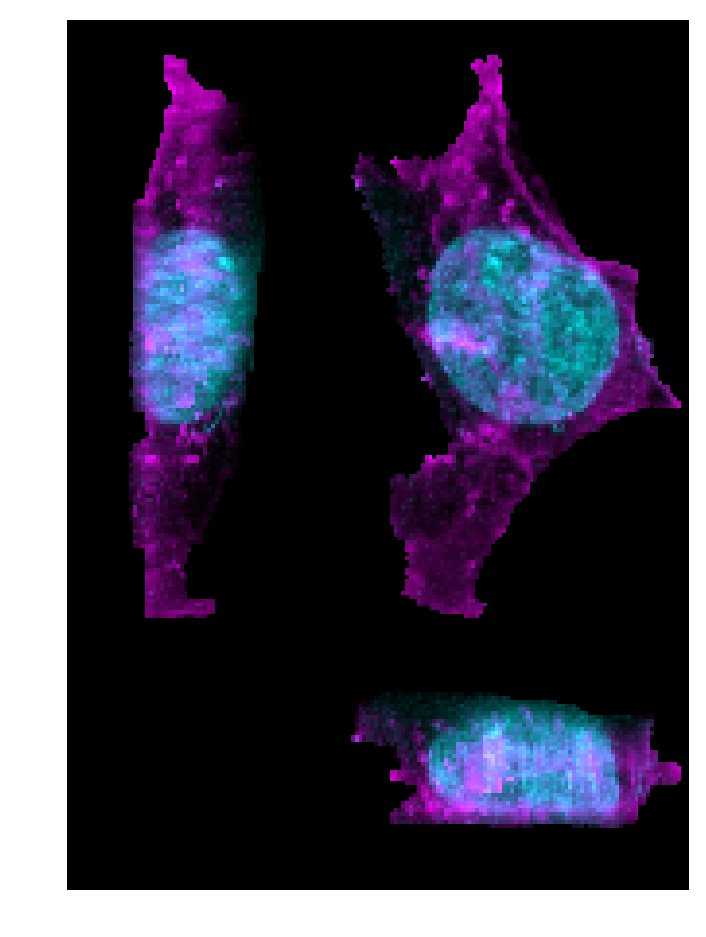

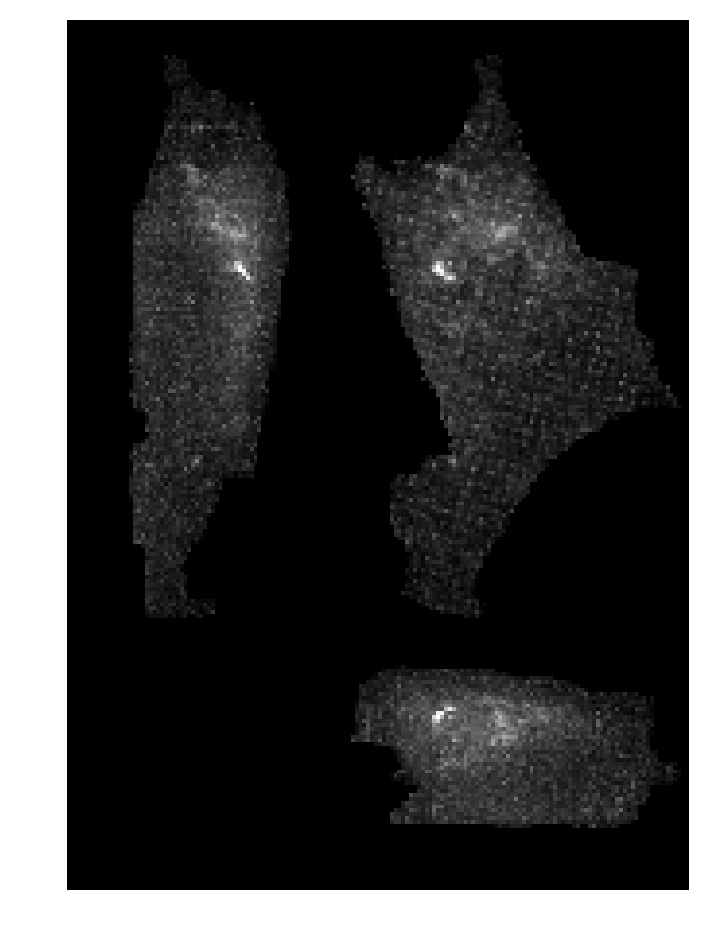

In [271]:
print(f'image_parent = {dp_ref_drugs.image_parent}, {dp_target_drugs.image_parent}')

ind = df_train_drugs_filtered.index[15]

ref_x_drugs = dp_ref_drugs.get_sample('test', [ind])
target_x_drugs = dp_target_drugs.get_sample('test', [ind])

#print(f"{df_train_drugs_filtered.loc[ind][['index', 'CellId', 'CellIndex', 'drug_label', 'drug_name', 'concentration', 'Gene', 'Protein', 'ProteinDisplayName', 'Structure', 'StructureDisplayName', 'StructureShortName', 'ProteinId/Name', 'StructureId/Name', 'save_dir', 'save_reg_path']]}")
print(f"{df_train_drugs_filtered.loc[ind]['save_reg_path']}")

#print(f'ref_x_drugs.shape = {ref_x_drugs.shape}')
#print(f'target_x_drugs.shape = {target_x_drugs.shape}')

plt.figure(figsize=(6, 8))
imshow(ref_x_drugs, scale_channels=True, scale_global=False)
plt.figure(figsize=(6, 8))
imshow(target_x_drugs[0], scale_channels=True, scale_global=False)

In [268]:
iterIdx = iter(df_train_drugs_filtered.index)
print(f'{len(df_train_drugs_filtered.index)}')

105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image_parent = /allen/aics/modeling/gregj/results/ipp/scp_drug_pilot_fixed/, /allen/aics/modeling/gregj/results/ipp/scp_drug_pilot_fixed/
0: plate_3500001236/nan_-331_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1: plate_3500001236/nan_-332_reg.tiff
2: plate_3500001236/nan_-333_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3: plate_3500001236/nan_-334_reg.tiff
4: plate_3500001236/nan_-335_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5: plate_3500001236/nan_-336_reg.tiff
6: plate_3500001236/nan_-337_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7: plate_3500001236/nan_-338_reg.tiff
8: plate_3500001236/nan_-339_reg.tiff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9: plate_3500001236/nan_-340_reg.tiff


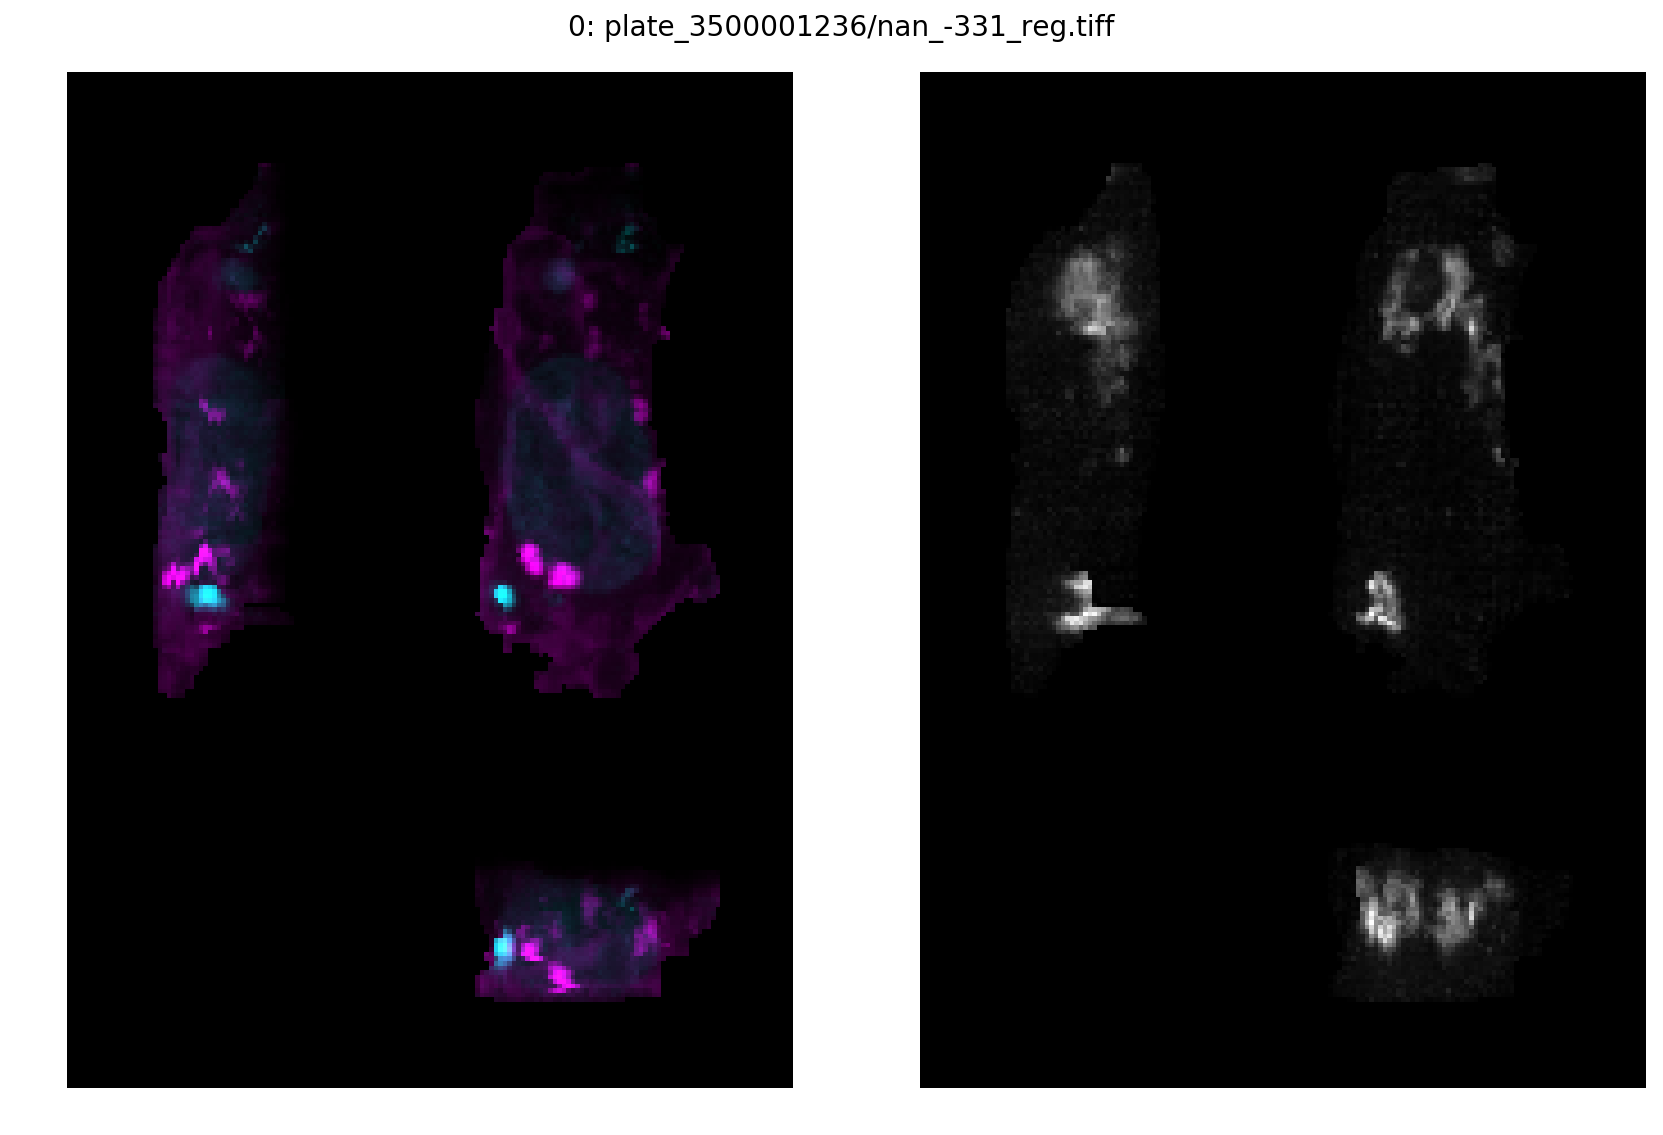

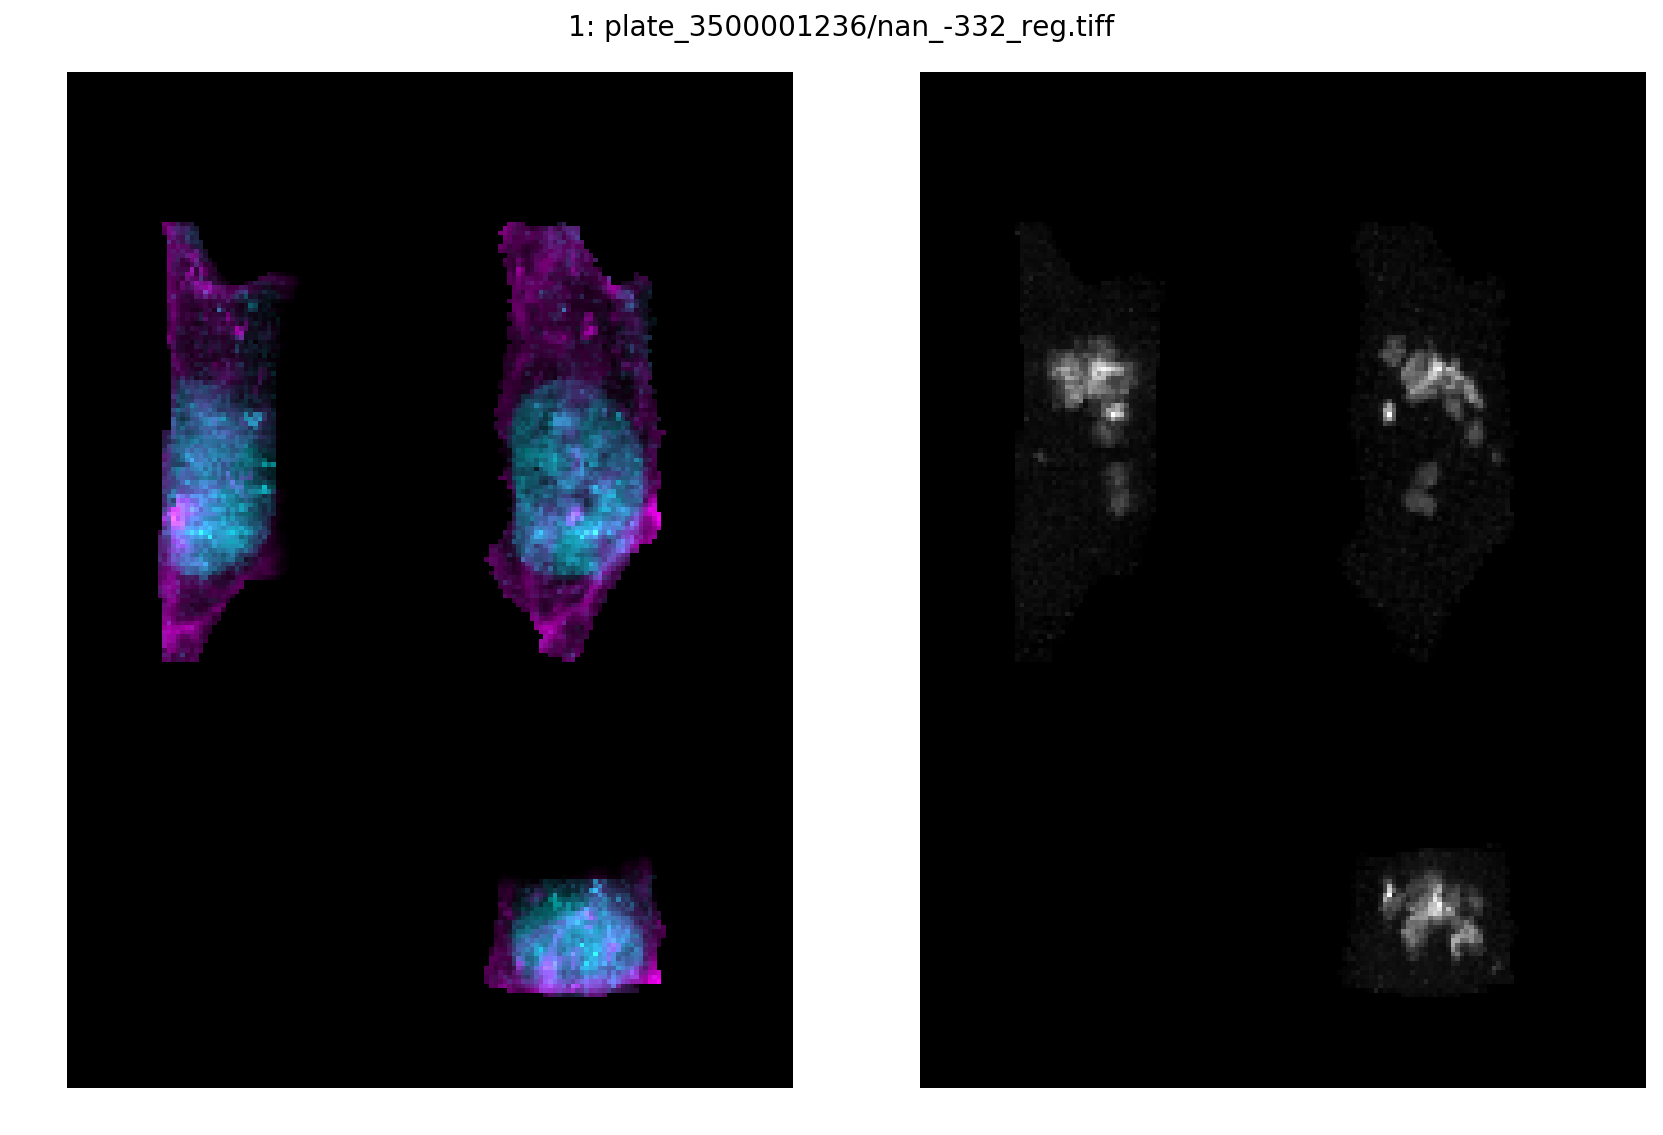

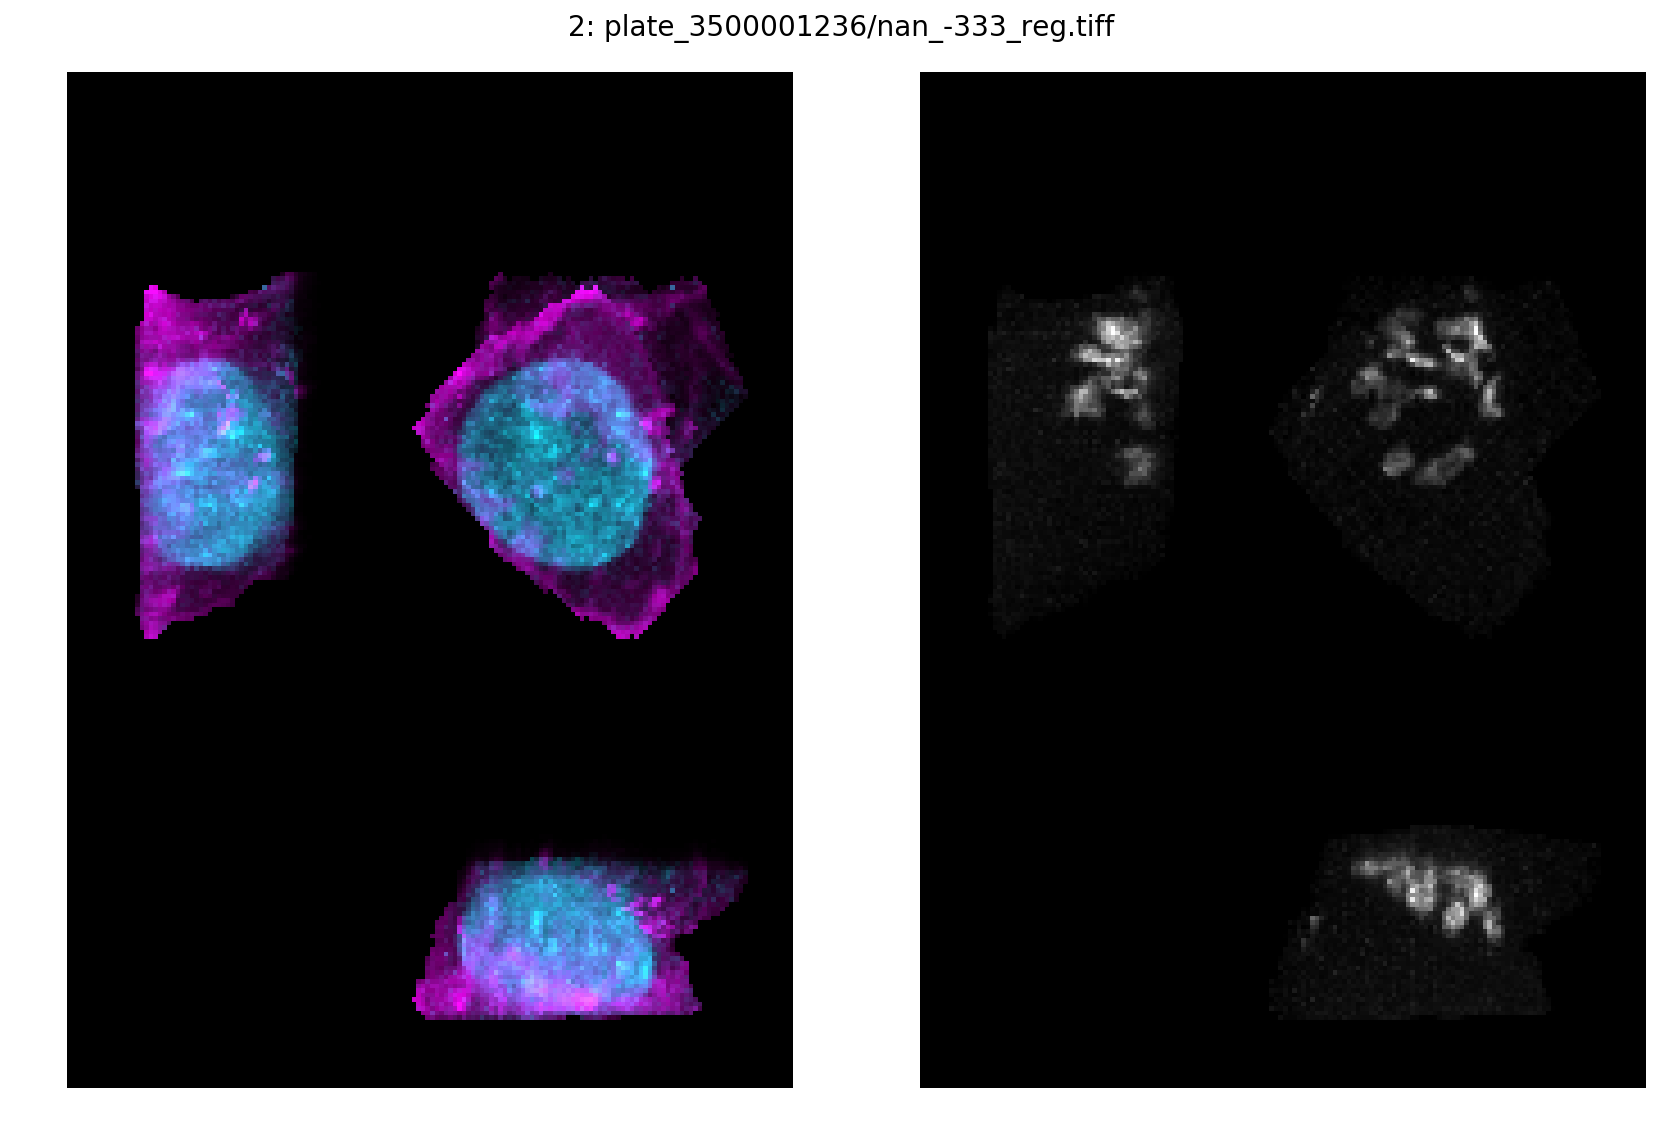

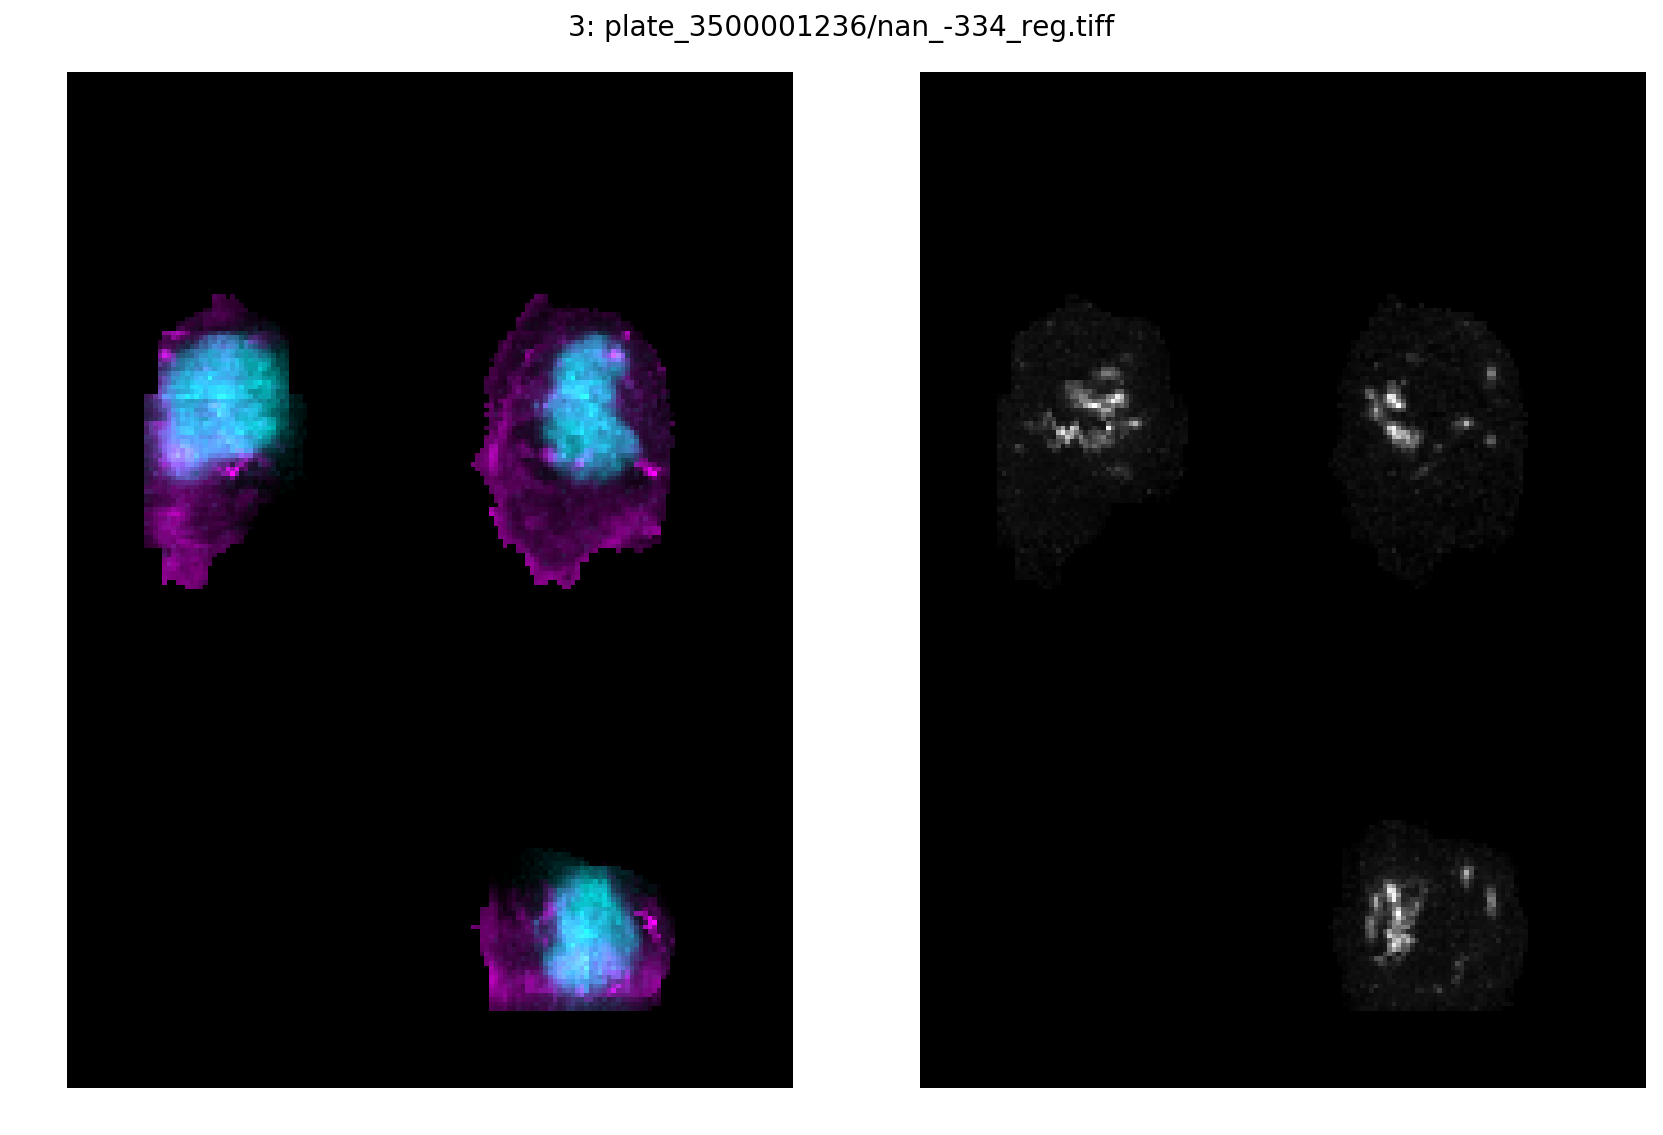

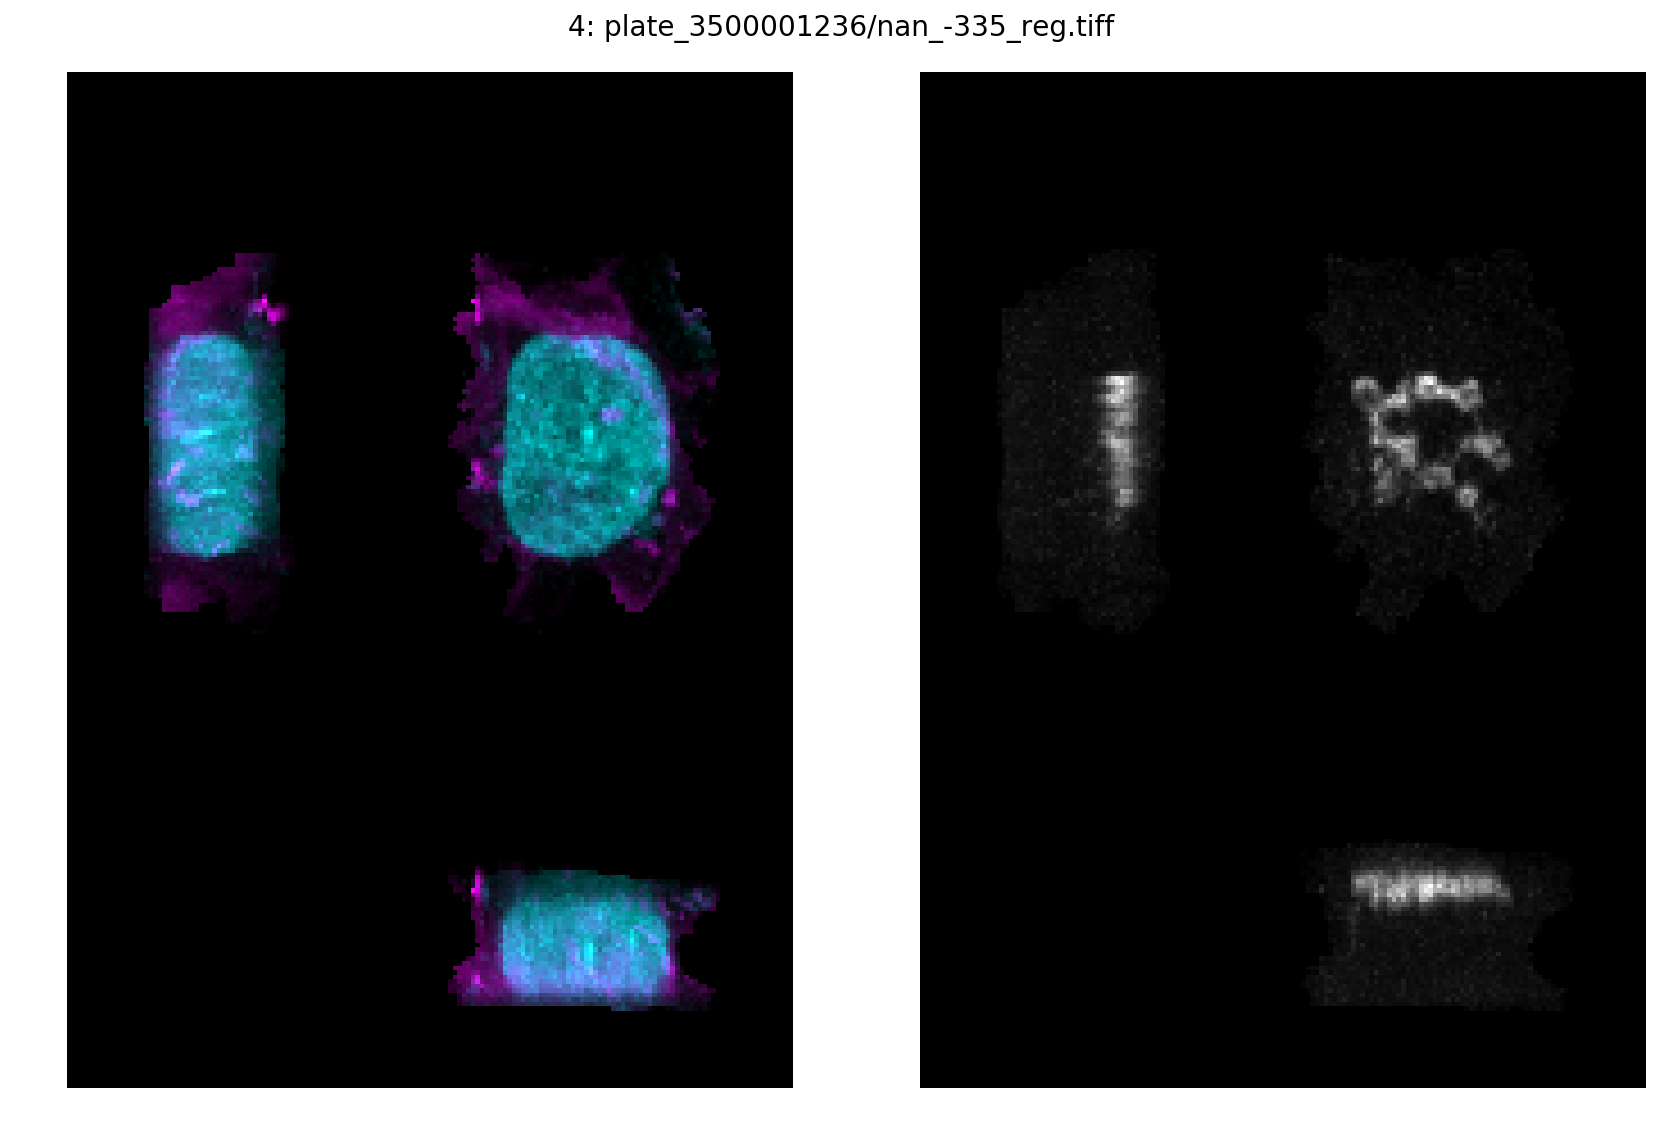

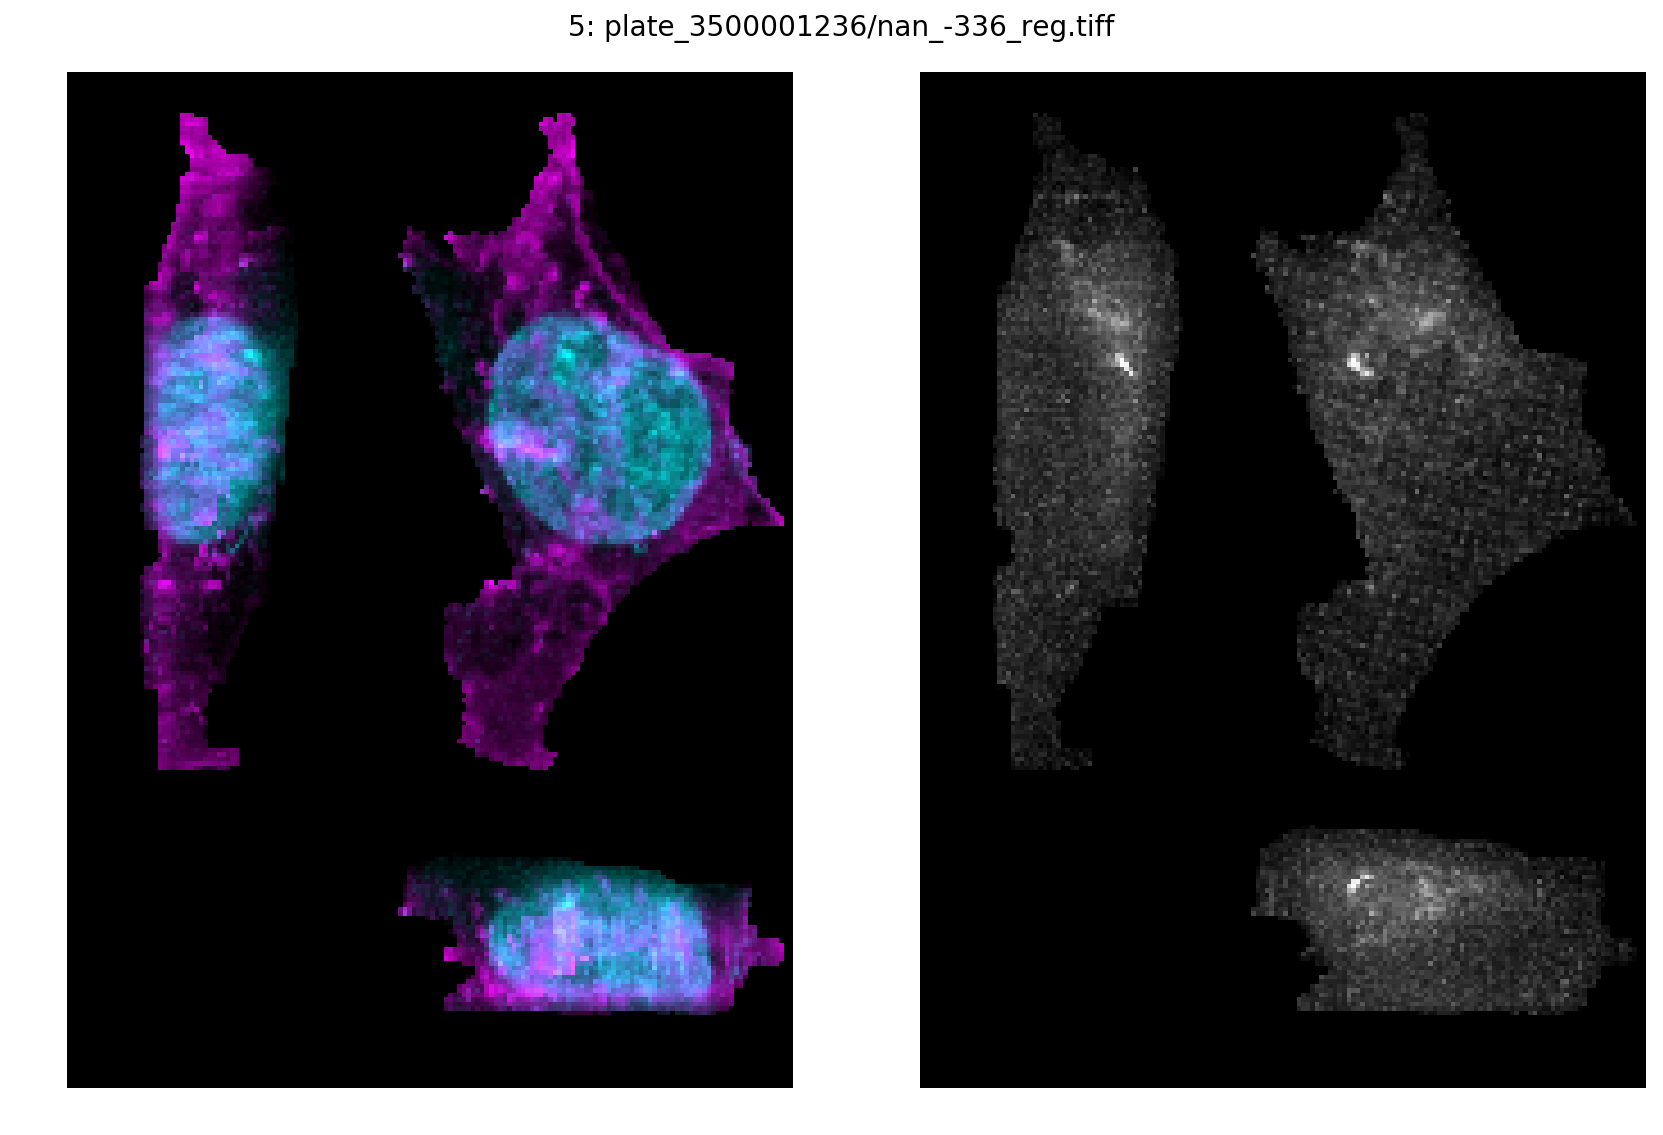

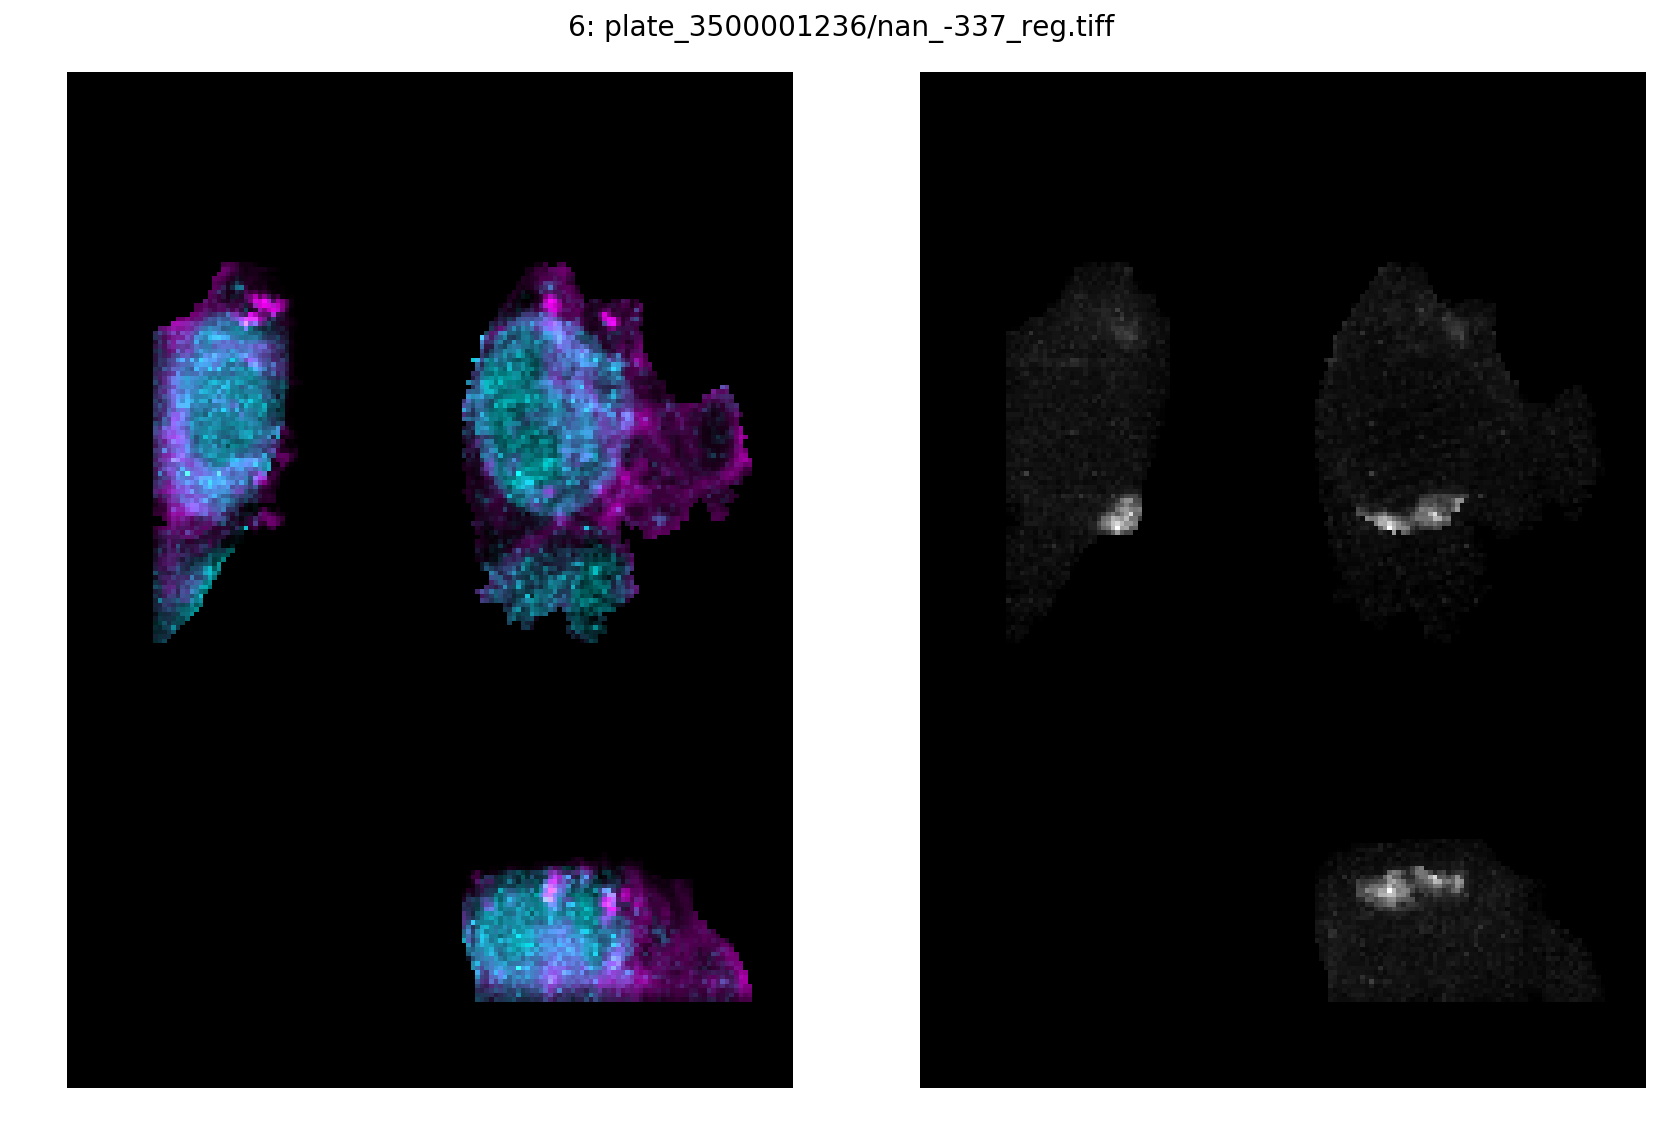

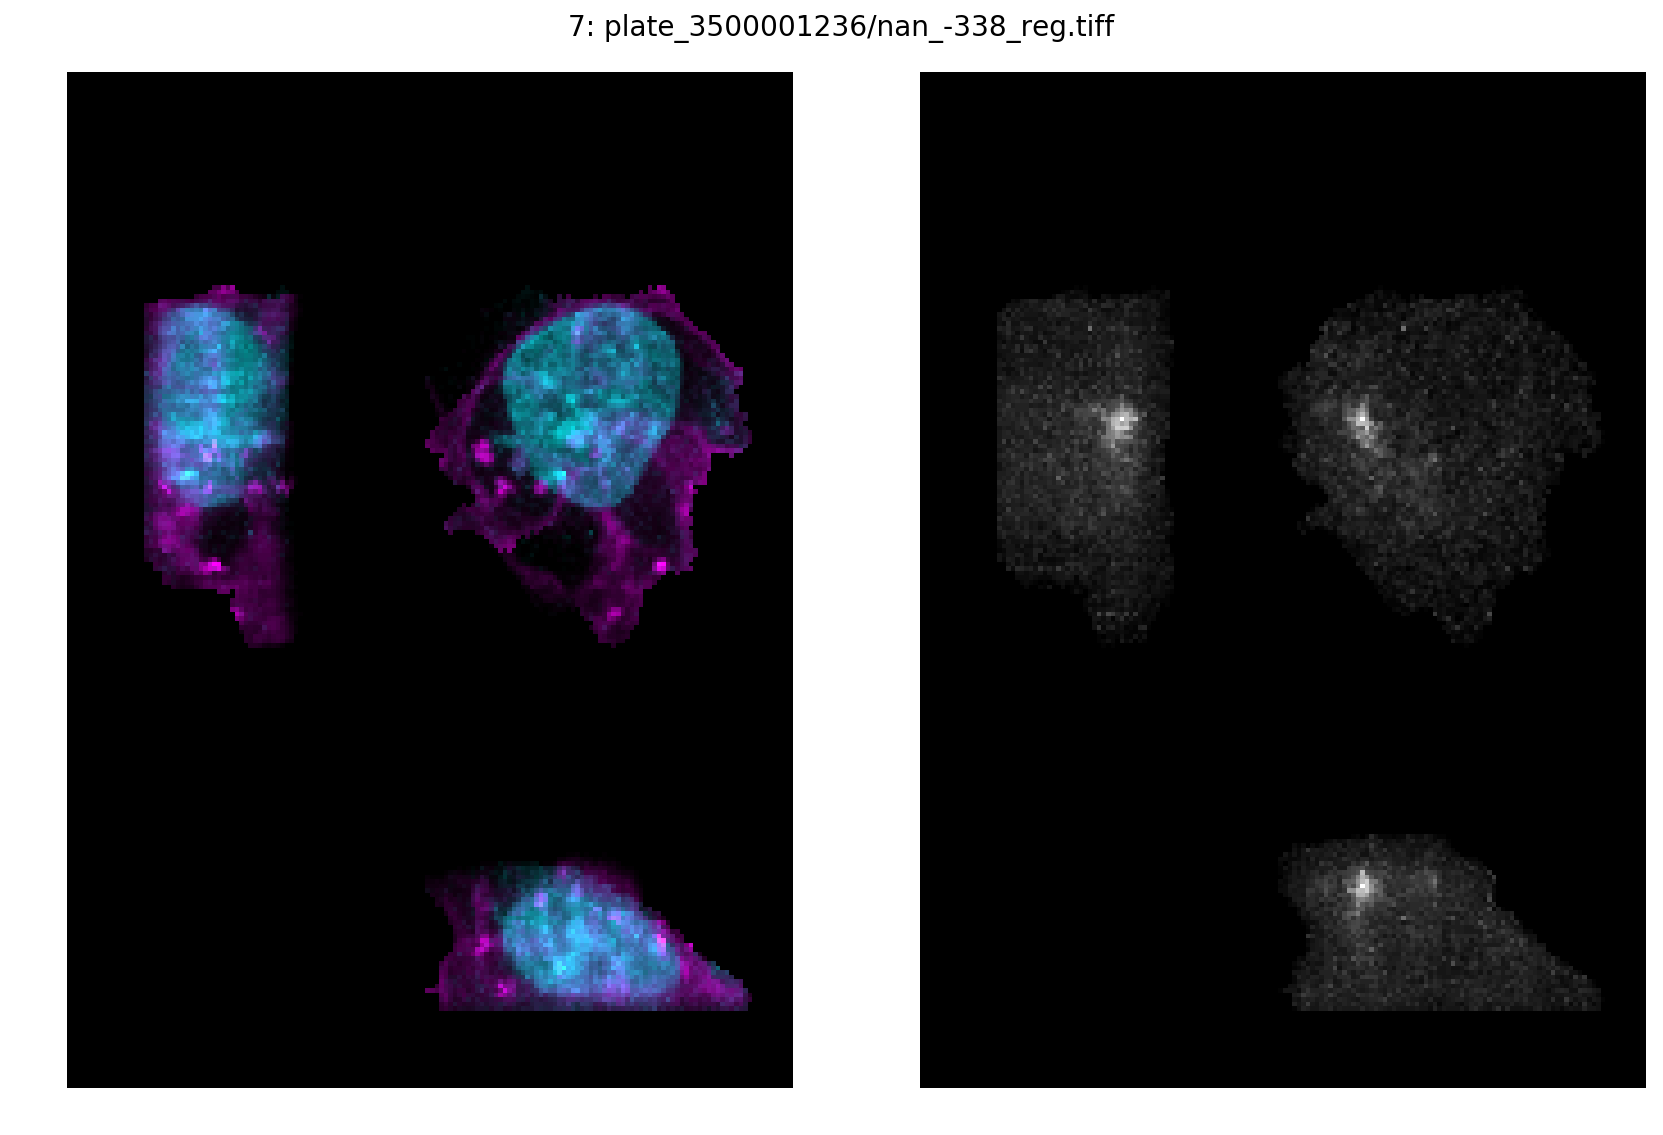

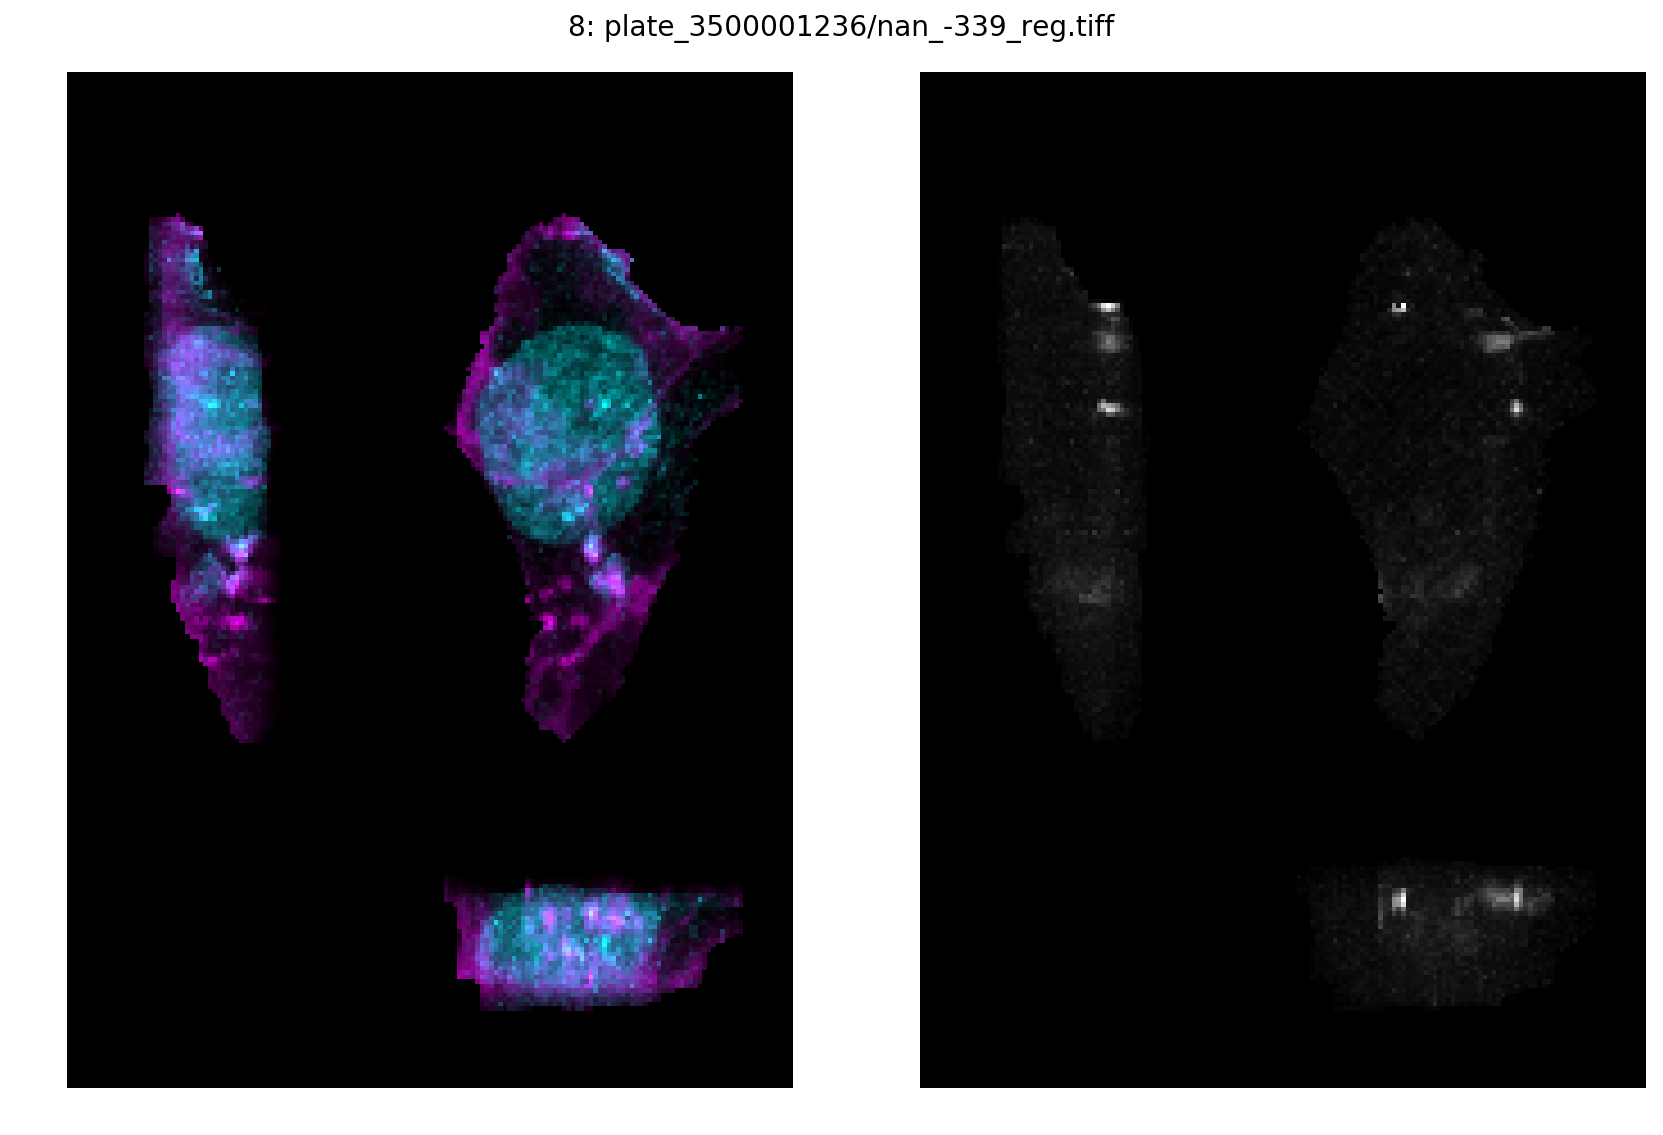

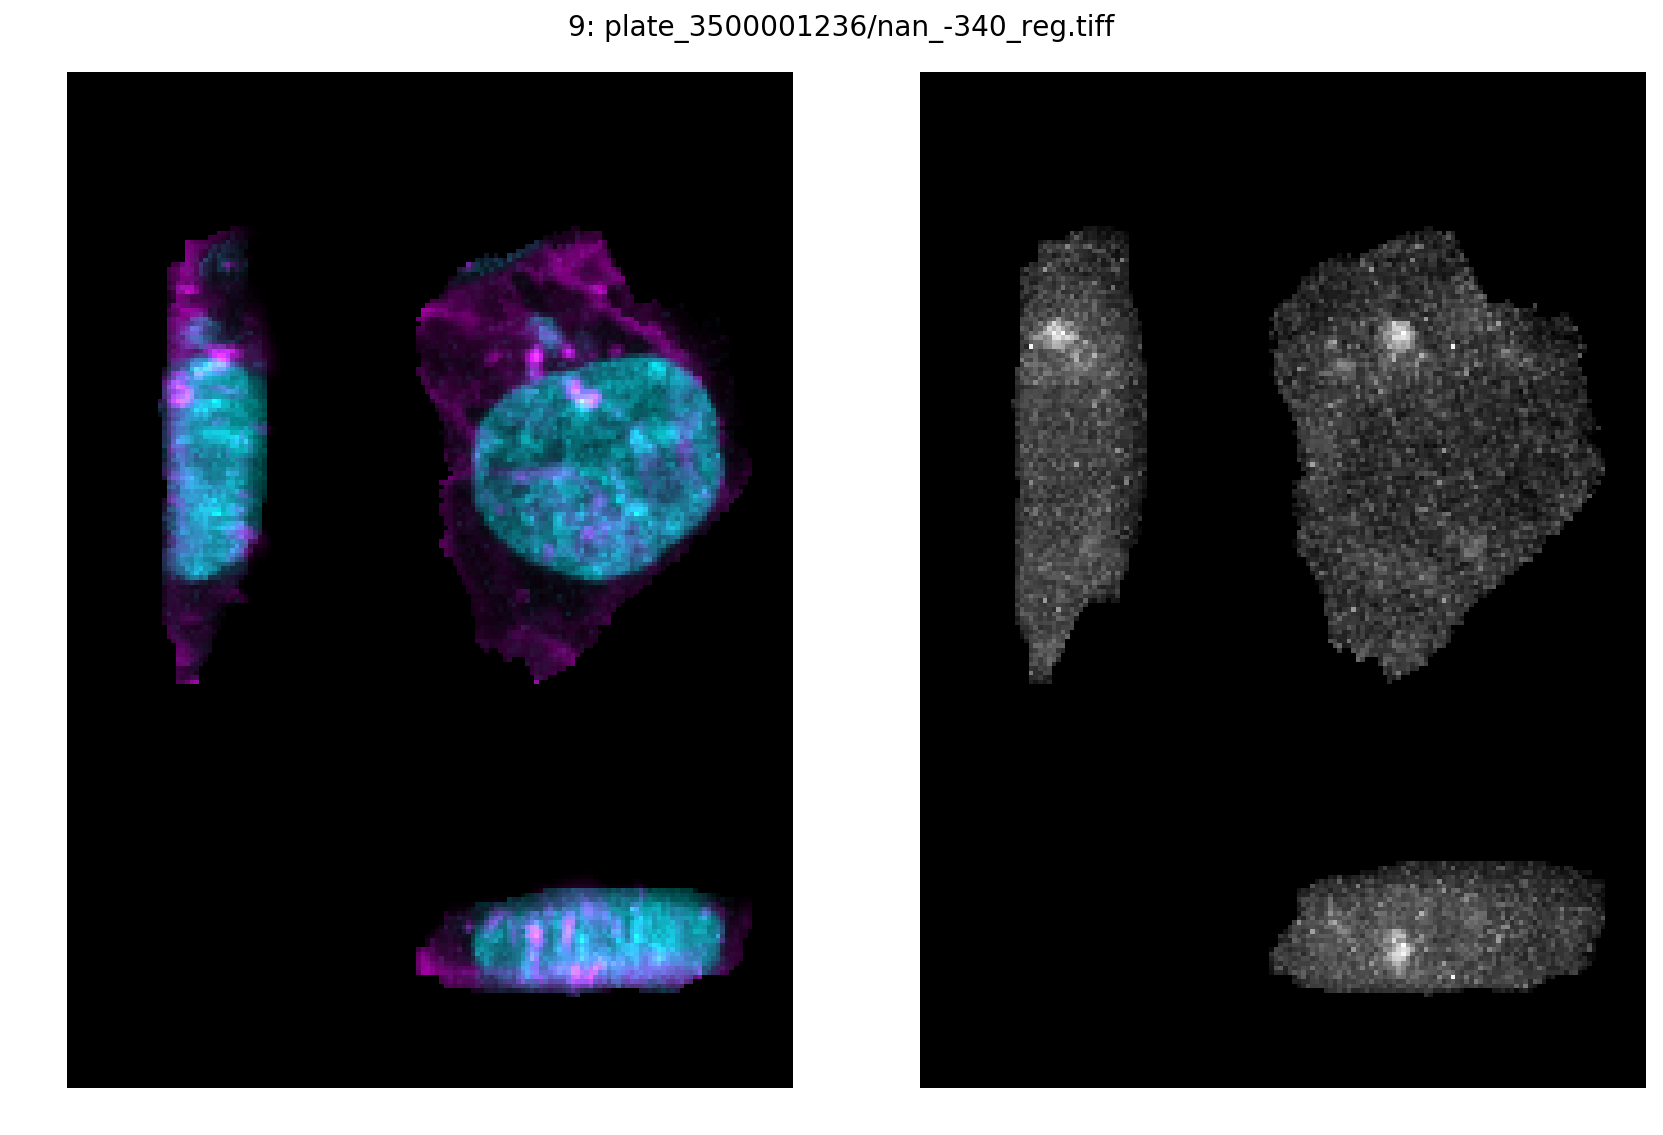

In [270]:
print(f'image_parent = {dp_ref_drugs.image_parent}, {dp_target_drugs.image_parent}')

for intIdx in np.arange(10):
    #ind = df_train_drugs_filtered.index[0]
    ind = next(iterIdx)

    ref_x_drugs = dp_ref_drugs.get_sample('test', [ind])
    target_x_drugs = dp_target_drugs.get_sample('test', [ind])

    #print(f"{df_train_drugs_filtered.loc[ind][['index', 'CellId', 'CellIndex', 'drug_label', 'drug_name', 'concentration', 'Gene', 'Protein', 'ProteinDisplayName', 'Structure', 'StructureDisplayName', 'StructureShortName', 'ProteinId/Name', 'StructureId/Name', 'save_dir', 'save_reg_path']]}")
    print(f"{intIdx}: {df_train_drugs_filtered.loc[ind]['save_reg_path']}")

    #print(f'ref_x_drugs.shape = {ref_x_drugs.shape}')
    #print(f'target_x_drugs.shape = {target_x_drugs.shape}')

    objFig, (objAx1, objAx2) = plt.subplots(1, 2, figsize = (12, 8))
    plt.suptitle(f"{intIdx}: {df_train_drugs_filtered.loc[ind]['save_reg_path']}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    imshow_subplot(ref_x_drugs, objAx1, scale_channels=True, scale_global=False)
    imshow_subplot(target_x_drugs[0], objAx2, scale_channels=True, scale_global=False)